# Analytische oefeningen t.b.v de Voortoets

@Theo Olsthoorn (12-03-2024 .. 30-11-2024)

# Intro, verantwoording

Na de vorige vergadering van 12 maart 2024 heb ik een aantal aspecten geanalyseerd die van belang zouden kunnen zijn voor een relatief eenvoudige, analytische analyse van de impact van een ingreep op een grondwatersysteem. De analyse heb ik uitgevoerd en gedocumenteerd in voorliggend Jupyter (Python) notebook, dat uitleg en code bevat om het uitgelegde te kwantificeren en te laten zien.

Voor een aantal complexere concepten zoals vertraagde nalevering, debietverloop van een bemaling met constante verlaging, hoe lang het duurt voor de verlaging stationair wordt e.d. zijn vereenvoudigingen voorgesteld die in de praktijk goed zullen werken.

Voor een zinvolle analyse van een fysische ingreep in het grondwatersysteem, zoals een nieuwe puntonttrekking, bemaling of verandering van de loop of het niveau van oppervlaktewater, is een beeld nodig van de opbouw van de ondergrond en van de drainage in het gebied (de randvoorwaarden). Bovendien is men geïnteresseerd in de overlap van de impact met bijzondere beschermingsgebieden. Deze drie vormen van informatie zijn gebonden aan beschikbare kaarten zoals die van de habitatgebieden, het oppervlaktewater, en bodemlagen. De laatste twee zijn aanwezig in de kaarten waarop het grondwatermodel van Vlaanderen is gebaseerd. Deze kaarten bevatten ook de benodigde informatie over de waarden van de bodemconstanten, zoals doorlaatvermogen, weerstand tussen lagen en bergingscoëfficiënten. Mogelijk kunnen op basis van de beschikbare laagverbreidingskaarten ook complexere situaties worden gesignaleerd, zoals breuken en andere scherpere overgangen tussen gebieden,  die niet met eenvoudige formules kunnen worden geanalyseerd of waarvoor een aangepaste berekening kan worden voorgesteld of voorgeschreven. Het uit kaarten halen van de randvoorwaarden voor een berekening is vermoedelijk het meest complex of valt in de praktijk het meest op af te dingen. Uiteraard kunnen randvoorwaarden worden voorgeschreven zoals een invloedsradius of duur van de onttrekking waarmee moet worden gerekend, zoals dat nu reeds in de Voortoets het geval is.

Voor de benodigde onderliggende gegevens moet er i de Voortoets toegreep zijn tot het Vlaamse grondwatermodel, of althans de kaarten waar dit op gebaseerd is, zodat deze kaarten als een ruimtelijke database kunnen worden beschouwd en bevrraagd op bodemconstanten die voor een gegeven locatie moeten worden gebruikt.

Door op een dergelijke manier de voor elke vraag benodigde informatie op te vragen, kan de onderliggende machinerie van de voortoets steeds gemakkelijk worden aangepast en verbeterd naar nieuwe inzichten.

Het resultaat van de Voortoets zol op deze wijze ook steeds in lijn zijn met de eventueel naderhand uit te voeren bredere analyse, waar dan zonodig een ruimtelijk grondwatermodel aan te pas komt, dat immers op dezelfde gegevens is gebaseerd. Een kernpunt zou dus moeten zijn dat de gegevens die gebruikt worden in de voortoets dezelfde zijn als die in het ruimtelijke model van Vlaanderen, waarbij de voortoetsberekeningen zich zullen baseren op de ondergrond gegevens ter plaatse van de ingreep en het ruimtelijk model met de ruimtelijke variatie rekening houdt. 

De info-vraag van de Voortoets zal altijd zeer beperkt zijn, zodat de ICT-belasting navenant laag blijft en de informatie dus real-time over het internet (via een URL) moet kunnen worden opgevraagd en worden opgezocht op de ruimtelijke kaarten.


# Imports voor de benodigde functionaliteit

In [3]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from scipy.special import exp1 as Wt, exp1
from scipy.special import k0 as K0, k1 as K1
from scipy.integrate import quad
from scipy.signal import lfilter, filtfilt
import pandas as pd
from itertools import cycle
from fdm.fdm3t import dtypeH, dtypeQ, fdm3t
from fdm.mfgrid import Grid
import ttim
from analytic.laplace import inverselaplace
from importlib import reload

Wh(0.001, 0.3)  = (2.7449201210813685, 4.580772753804319e-09)
Wh(0.01, 0.3)   = (2.7104287908047175, 1.8261895390546826e-09)
Wh(0.1, 0.3)    = (1.6703650224009043, 5.50906758939597e-09)


import 

# Grondwaterformules.nl: de verlaging van een kleine onttrekking is maximaal bij een bepaalde kD

$$\siigma = \frac{2 \pi}{Q} s = \frac{1}{T} K_0\left(\frac r \lambda\right)$$


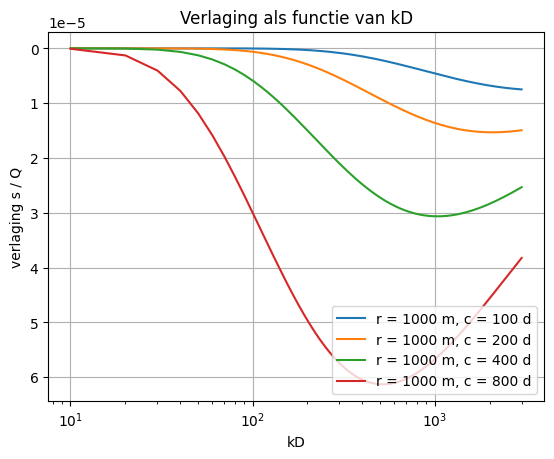

In [19]:
r = 1000 # m
Q = 1500 # m3/d
c = 300 # d
cs = np.array([100, 200, 400, 800.])
kDs = np.linspace(0, 3000, 300)[1:]

fig, ax = plt.subplots()
ax.set_title("Verlaging als functie van kD")
ax.set_xlabel("kD")
ax.set_ylabel("verlaging s / Q")
ax.grid(True)
ax.invert_yaxis()
ax.set_xscale('log')


for c in cs:
    s = np.zeros_like(kDs)
    for i, kD in enumerate(kDs):
        L = np.sqrt(kD * c)
        s[i] = Q / (2 * np.pi * kD) * K0(r / L)
    ax.plot(kDs, s / Q, label=f"r = {r:.4g} m, c = {c:.4g} d")
ax.legend(loc='lower right')

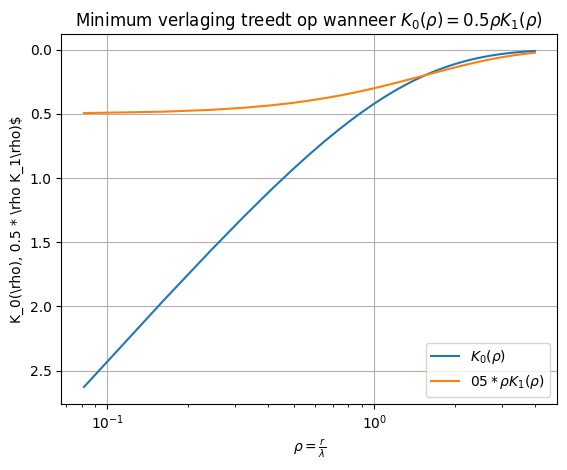

In [22]:
fig, ax = plt.subplots()
ax.set_title(r"Minimum verlaging treedt op wanneer $K_0(\rho) = 0.5 \rho K_1(\rho)$")
ax.set_xlabel(r"$\rho = \frac{r}{\lambda}$")
ax.set_ylabel(r"K_0(\rho), 0.5 * \rho K_1\rho)$")
ax.grid(True)
ax.invert_yaxis()
ax.set_xscale('log')

rhos = np.linspace(0, 4)[1:]
ax.plot(rhos, K0(rhos), label=r"$K_0(\rho)$")
ax.plot(rhos, 0.5 * rhos * K1(rhos), label=r"$05 * \rho K_1(\rho)$")
ax.legend(loc='lower right')

def frho(rho):
    return K0(rho) - 0.5 * rho * K1(rho)
def frhos(rho1, rho2):
    if frho(rho1) * frho(rho2) < 0:
        rho2 = rho2 - 0.5 * (rho2 - rho1)
        return rho1, rho2
    else:
        rho1 = rho1 + 0.5 * (rho2 - rho1)
        return rho1, rho2

rho1, rho2 = 1, 10.
f = K0(rho1) - 0.5 * rho1 * K1(rho1)
rho = rho1
for i in range(20):
    if 0.5 * rho * K1(rho) > K0(rho):
        rho = rho + 0.5 * (rho2 - rho)
    else:
        rho = rho - 0.5 * (rho1 - rho)


# Basisfuncties die verderop worden gebruikt:

In [5]:
def newfig(title, xlabel, ylabel, xlim=None, ylim=None, xscale=None, yscale=None, figsize=None):
    """Set up a new figure with a single axes and return the axes."""
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if xscale is not None:
        ax.set_xscale(xscale)
    if yscale is not None:
        ax.set_yscale(yscale)
    ax.grid(True)
    return ax


def Wh(u, rho=0):
    """Return Hantush's well function values.
    
    Parameters
    ----------
    u = r^s / (4 kD t)
    rho = r / lambda,    lambda = sqrt(kD c)
    
    >>>Wh(0.004, 0.03)
    4.894104204671381    
    """
    def kernel(y, rho):
        """Return the function to be integrated."""
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho): # Integrate the argument
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    return np.asarray(wh(u, rho), dtype=float)

Wh(0.004, 0.03)


def Wb(tau, rho=0):
    """Return Hantush well function values using the Bruggeman (1999) form of Hantush's Well function.
    
    Bruggeman (1999) prefers uses a somewhat different form of Hantush's Well function, one in which
    time and distance to the well are truly separated. However, this looses a bit the connection with
    Theis, which we have always been used to. Bruggeman uses W(tau=t / (cS), rho=r / lambda)
    instead of W(u=r^2 S / (4 kD t), rho=r / lambda)
    
    Parameters
    ----------
    tau = t/ (cS)
    rho = r / lambda, lambda= sqrt(kD c)
    
    >>>Wb(0.05625, 0.03)
    4.894104204671381    
    """
    def kernel(x, rho):
        """Return the function to be integrated."""
        return np.exp(-x - (rho / 2) ** 2 / x) / x
    def w(tau, rho):
        """Integrate the argument."""
        return quad(kernel, 0, tau, args=(rho,))[0]
    
    # Vectorize function w(u, rho) so we can use arrays as input.
    wh = np.frompyfunc(w, 2, 1)
    return np.asarray(wh(tau, rho), dtype=float)


def Wb1(tau, rho=0):
    """Return Hantush well function values using the Bruggeman (1999) form of Hantush's Well function.
    
    Parameters
    ----------
    tau = t/ (cS)
    rho = r / lambda, lambda= sqrt(kD c)
    
    >>>Wb(0.05625, 0.03)
    4.894104204671381    
    """
    u = rho ** 2  / (4 * tau)
    return Wh(u, rho)

def SRtheis(T=None, S=None, r=None, t=None):
    """Return Step Responss for the Theis well function."""
    dt = np.diff(t)
    assert(np.all(np.isclose(dt[0], dt))), "all dt must be the same."
    u = r ** 2 * S / (4  * T * t[1:])
    return np.hstack((0, 1 / (4 * np.pi * T) * exp1(u)))

def BRtheis(T=None, S=None, r=None, t=None):
    """Return Block Response for the Theis well function"""
    SR = SRtheis(T, S, r, t)
    return np.hstack((0, SR[1:] - SR[:-1]))

def IRtheis(T=None, S=None, r=None, t=None):
    dt = np.diff(t)
    assert np.all(np.isclose(dt[0], dt))
    u = np.hstack((np.nan, r ** 2 * S / (4 * T * t[1:])))
    return np.hstack((0, 1 / (4 * np.pi * T) *  np.exp(-u[1:]) / t[1:])) * dt[0]

#u = np.logspace(-4, 1, 51)
u, rho = 0.004, 0.03
print("Wh(u={:.4g}, rho={:.4g}) = {}".format(u, rho, Wh(u, rho)))
tau = rho ** 2 / (4 * u)
print("Wb(tau={:.4g}, rho={:.4g}) = {}".format(tau, rho, Wb(tau, rho)))


Wh(u=0.004, rho=0.03) = 4.894104204671381
Wb(tau=0.05625, rho=0.03) = 4.894104204671358


# Puntonttrekkingen

## De nalijlende verlaging

Hoeveel blijft er na verloop van tijd nog over van een tijdeijke onttrekking in het verleden? Deze vraag is eigenlijk alleen relevant voor de Theis situatie met freatische berging, omdat de semi-gespannen situatie volgens Hantush al snel stationair wordt en dan ook snel geen restantvergelaging meer heeft nadat de onttrekking is gestopt.

De verlaging door een onttrekking in een situatie zonder randvoorwaarden wordt goed beschreven door Theis

$$ \frac Q {2 \pi kD} W(u), \,\,\,\, u =\frac{r^2 S }{4 kD t} $$

Er is in een dergelijke Theis situatie na beëndiging van de onttrekking nog zeer lange tijd sprake van een resterende verlaging, die samen met andere niet permanente onttrekkingen toch tot een cumulatief effect zal leiden.

De resterende verlaging is dan gelijk aan
 $$ s(r, t) = \frac{Q}{4 \pi kD} \left[ W_t \left(\frac{r^2 S}{4 kD t}\right) - W_t \left( \frac{r^2 S}{4 kD (t - \Delta t)} \right)\right]$$

Het voorbeeld hieronder laat de verlaing als functie van de tijd zien, inclusief het naijlen ervan nadat de bemaling is gestopt.


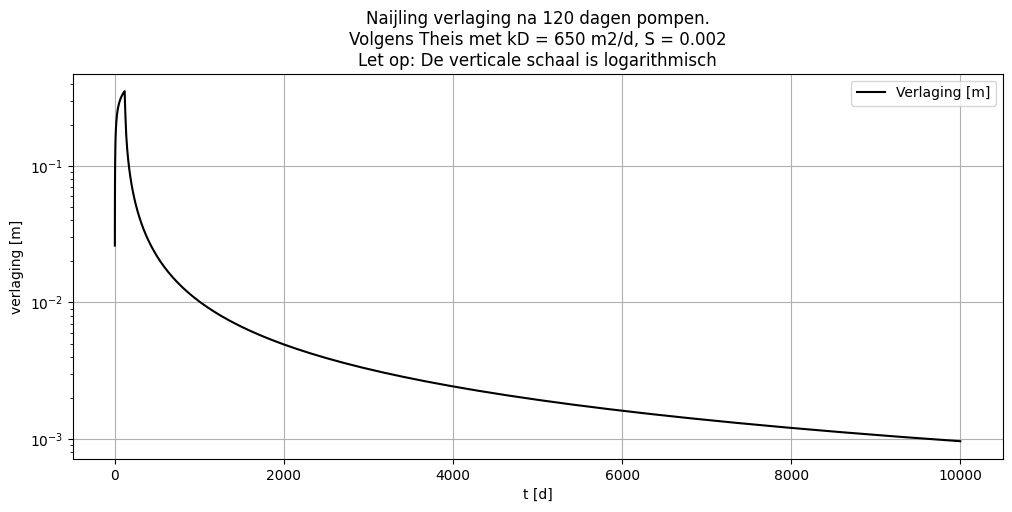

In [6]:
kD, S = 650, 0.002 # [m2/d]
Dt = 120 # [d] Duur van de onttrekking
r = 1000 # [m]
t = np.logspace(0, 4, 121) # [d]

putten = {
    0: {'Q': +650., 'tStart':   0.},
    1: {'Q': -650., 'tStart': 120.}
}

s = np.zeros_like(t)
for k, put in putten.items():
    Q, tStart = put['Q'], put['tStart']
    u = r ** 2 * S  / (4 * kD * (t[t > tStart] - tStart))
    s[t > tStart] += Q / (4 * np.pi * kD) * Wt(u)

ax = newfig((f'Naijling verlaging na {tStart:.0f} dagen pompen.\n' +
             f'Volgens Theis met kD = {kD:.0f} m2/d, S = {S:.3g}\n' +
            'Let op: De verticale schaal is logarithmisch'),
            't [d]', 'verlaging [m]', yscale='log', figsize=(12, 5))
ax.plot(t, s,  color='k', label='Verlaging [m]')
ax.legend()

## Het cumulatieve effect van gelijktijdige en in de tijd verschoven onttrekkingen

Bij een groot aantal bemalingen willekeurig in de tijd ontstaat zo een cumulatief effect.

Veronderstel een stad met een oppervlak van 3x3 km, waar op eerste van elke maand op een willekeurige locatie in de stad een bemaling start van 1800 m3/d start, die drie maanden aanhoudt. Dat betekent dat vanaf maand 3 er steeds 3 bemalignen actief zijn elke op een willekeurige locatie in de stad. De bemalingen vinden plaats over een periode van 120 maanden. De periode daarna laat naijling zien. De periode gedurende de beschouwde 120 maanden laat het cumulatieve effect van de bemalingen zien.

De bodemconstantn $kD$ en $S$ zijn zodanig dat bij 1800 m3/d op 10 m afstand na 120 dagfen een verlaging optreedt van 3 m. Dit zijn allemaal redelijke aannamen zoals je die in een stad zou verwachten.



In [7]:
kD, S = 650, 0.002 # [m2/d]
Q, duur, r = 1800, 120, 10

print('Verlaging na {} d, bij Q = {:.0f} m3/d op r = {:.1f} m bij kD ={:.0f} m2/den S = {:.3g} m: = {:.2f} m'.format(
    duur, Q, r, kD, S, Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * duur))))

Verlaging na 120 d, bij Q = 1800 m3/d op r = 10.0 m bij kD =650 m2/den S = 0.002 m: = 3.02 m


## Voorbeeld cumulatief effect van over een stad verdeelde gelijktijdige en in de tijd verschoven bemalingen

Deze denkbeeldige stad van 3x3 km heeft 100 bemalingen verdeeld over 10 jaar, die alle gedurende 3 maanden actief zijn. De locaties zijn willekeurig over de stad verdeeld. Elke maand start een nieuw onttrekking op een van de 100 locaties, en duurt da 3 maanden. Dit impliceert dat er vanaf maand 3 steeds 3 bemalingen actief zijn op 3 van de 100 willekeurige locaties. Na 103 maanden zijn alle bemalingen beëindigd.

In [8]:
# Plot de bemaling op de kaart
tend = 10 * 365

# Kies 120 x,y locaties binnen de stad van 3x3 km.
xy = np.round((np.random.rand(240).reshape(2, 120) - 0.5) * 3000)

# Elke maand start een volgende bemaling
tStart = np.linspace(0, tend, 120).reshape(1, 120)

bemaling = pd.DataFrame(data=np.vstack((xy, tStart)).T, columns=['x', 'y', 'tStart'])
      
bemaling.index.name = 'bemaling'
bemaling['Q']    = -1800 # d
bemaling['duur'] =   90  # d
print(bemaling)

               x       y       tStart     Q  duur
bemaling                                         
0          270.0  -330.0     0.000000 -1800    90
1         1453.0  -297.0    30.672269 -1800    90
2         1075.0  -830.0    61.344538 -1800    90
3         -920.0  -390.0    92.016807 -1800    90
4         -161.0   618.0   122.689076 -1800    90
...          ...     ...          ...   ...   ...
115        827.0   -68.0  3527.310924 -1800    90
116       1221.0    46.0  3557.983193 -1800    90
117       1267.0  -700.0  3588.655462 -1800    90
118        848.0  -384.0  3619.327731 -1800    90
119        188.0  1449.0  3650.000000 -1800    90

[120 rows x 5 columns]


Locaties van de bemalingen

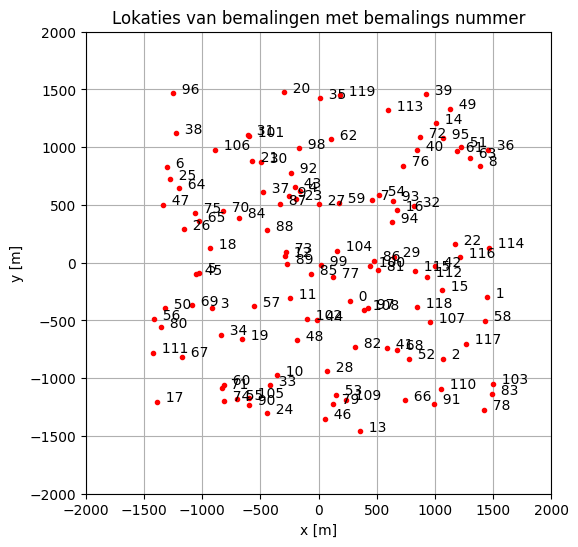

In [9]:
ax = newfig('Lokaties van bemalingen met bemalings nummer', 'x [m]', 'y [m]',
            xlim=(-2000, 2000), ylim=(-2000, 2000), figsize=(6, 6))
ax.plot(bemaling['x'], bemaling['y'], 'r.', label='locatie bemaling')
for nr in bemaling.index:
    x, y, tstart, Q, duur = bemaling.loc[nr] 
    ax.text(x, y, '  {}'.format(nr))


Het cumulatieve effect van de bemalingen

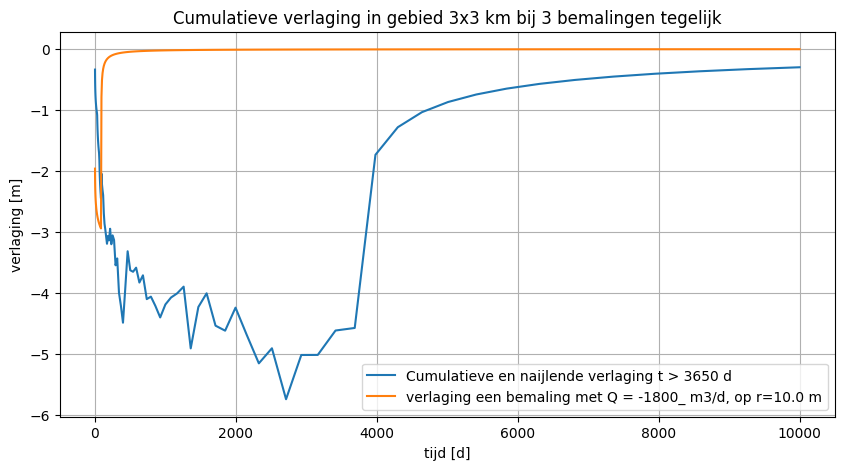

In [10]:
x0, y0 = 0., 0. # [m] locatie van de waarneming

ax = newfig('Cumulatieve verlaging in gebied 3x3 km bij 3 bemalingen tegelijk',
            'tijd [d]', 'verlaging [m]', figsize=(10, 5))

s = np.zeros_like(t)
for k in bemaling.index:
    xw, yw, tstart, Q, duur = bemaling.loc[k]
    r = np.sqrt((xw - x0) ** 2 + (yw - y0) ** 2)
    
    # Put aan
    u = r ** 2 * S  / (4 * kD * (t[t > tstart] - tstart))
    s[t > tstart] += Q / (4 * np.pi * kD) * Wt(u)
    
    # Put uit
    u = r ** 2 * S  / (4 * kD * (t[t > tstart + duur] - (tstart + duur)))
    s[t > tstart + duur] -= Q / (4 * np.pi * kD) * Wt(u)
    
ax.plot(t, s, label='Cumulatieve en naijlende verlaging t > 3650 d')

# Een enkele bemaling 1800 m3/d gedurende 120 d, observatie op r=10 m.
Q, r = -1800, 10

# Put aan op t=0
s = Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * t))

# Put uit op t=90 d
s[t > duur] += -Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * (t[t > duur] - duur)))

ax.plot(t, s, label='verlaging een bemaling met Q = {:.0f}_ m3/d, op r={:.01f} m'.format(Q, r))
    
ax.legend()
    

# Formule van Verruijt versus die van Dupuit en de formule van Blom

## Het idee achter deze formules

Het idee achter de formule van Verruijt is een onttrekking in het centrum van een circulair gebied dat gevoed wordt met een constant en uniform neerslagoverschot. Het stroombeeld is hiermee uniek bepaald. Het stijghoogtebeeld is echter alleen bepaald wanneer deze ergens, op een, op zichzelf willekeurige afstand van de put wordt gefixeeerd. De formule van Verruijt is stationair and kan direct worden afgeleid voor een watervoerend pakket met vrije watertafel, waarin de effectieve dikte van het watervoerend pakket varieert met de hoogte van de watertafel. Als het gebied groot genoeg is, is er altijd een afstand waarbinnen de voeding van de put geheel richting put stroomt, en waarbuiten dit van de put af stroomt. Deze afstand vormt de waterscheiding, waarop de watertafel horizontaal is. De afstand tot deze waterscheiding neemt toe met de grootte van de onttrekking.

De wiskundige oplossing voor de situatie die Verruijt voor ogen had, is direct  vergelijkbaar met die volgens Dupuit, die geen rekening hield met het neerslagoverschot. De verlaging volgens Verruijt en Dupuit, dat wil zeggen de oorspronkelijke stijghoogte minus de nieuwe, verlaagde stijghoogte, is voor beide situaties dezelfde.

De situatie die Blom voor ogen had, is een put in heen gebied met voldoende sloten, zodat de weerstand de sloten mag worden beschouwd als een vlakdekkende drainageweerstand. Voorafgaand aan de onttrekking draineren deze sloten de voeding van het gebied vanuit het neerslagoverschot. Binnen een nader te bepalen afstand rond de put vallen alle sloten droog; daarbuiten blijven zijn draineren. De drainage door de sloten die droogvallen komt volledig ten goede aan het door de put onttrokken water. Buiten het gebied met de nu droge sloten is de drainage afgenomen maar niet tot nul, en komt zodoende alleen de afgenomen drainage ten goede aan het onttrokken water. De drainage op de grens van het gebied met droge sloten is juist gelijk aan nul, daarbuiten neemt de deze asymptotisch toe tot het totale neerslagoverschot.

Bij een vlakdekkende drainageweerstand $c$, per definitie gelijk aan de gemiddelde grondwaterstand boven het slootpeil, $h$ gedeeld door het neerslagoverschot $N$, is de verlaging $s_R$ op de grens van het gebide met drooggevallen sloten en niet-drooggevallen sloten gelijk aan $s_R=Nc$.


## Verruijt voor 1D stroming alleen langs de x-as

We kunnen de Formule van Verruijt zowel afleiden voor radiale situatie als die met uitsluitend stroming in de $x$-richting. Beide formules kunnen in de praktijk van pas komen en onderlinge vergelijking geeft een beter inzicht in het gedrag dat ze beschrijven.

In de eendimensionale situatie is de onttrekking geen put maar ene lijnonttrekking en is de cirkelvormige rand een rechte rand met gegeven grondwaterstand op een gegeven afstand $L$. De lijnonttrekking $Q$ heeft dimensie [L2/T] in plaats van [L2/T] bij de axiaal symmetrische situatie.

De waterbalans op afstand $x$ van de onttrekking bij neerslagoverschot $N$ is dan

$$ Q(x) = Q(0) - N x = + kh \frac{dh}{dx}$$

waarbij de stroming naar de onttrekking toe (links) posiftief wordt genomen tegen de richting $x$ in, zodat een onttrekking postief is.

$$ Q_0 x - \frac 1 2 N x^2 = \frac 1 2 k h^2 + C$$

en met gegeven stijghoogte $H$ op $x=L$ volgt voor $C$

$$ Q_0 L - \frac 1 2 N L^2 = \frac 1 2 k H^2 + C$$

Deze twee vergelijkingen van ekaar aftrekken elimineert constante $C$, zodat

$$ Q_0 (x - L) - \frac 1 2 N (x^2 - L^2) = \frac 1 2 k (h^2 - H^2) $$

oftewel

$$ h^2 - H^2  = \frac N k (L^2 - x^2) - \frac {2 Q_0} k (L - x)$$

#### Waterscheiding

$$ 2 h \frac{dh}{dx} |_{x=x_D} = - 2 \frac N k x_D + 2 \frac{Q_0} k = 0. \,\,\,\,\,\,\rightarrow\,\,\,\,\,\, x_D =\frac {Q_0} N$$



Bij constant doorlaatvermogen kunnen we $h + H$ afsplitsen en schrijven als $2D$ met $D$ de pakketdikte

$$ h^2 - H^2 = (h - H)(h + H) = (h - H) 2D $$

Zodat in bij uniform doorlaatvermogen $kD$ geldt

$$ h - H  = \frac N {2kD} (L^2 - x^2) - \frac {Q_0} {kD} (L - x)$$

Met $h-H = -s$ de verlaging, volgt voor deze verlaging de volgende uitdrukking

$$ s  = \frac {Q_0} {kD} (L - x) -\frac N {2kD} (L^2 - x^2)$$

## Formule van Blom, ééndimensionaal

Bij blom is de stijghoogte op $x=L$ niet gefixeerd, maar is de drainage daar net nul. Er is daar dus nog een restverlaging die wordt veroorzaakt door de lek (afvoerreductie) die de onttrekking veroorzaakt in het gebied waar de sloten nog wel blijven drainenen, zij het niet het volledige neerslagoverschot. Schrijven we de grondwaterstand op $x=\infty$ gelijk aan $H_\infty$ en die op $x=L$ als $H_L$ dan volgt met $h^2 - H_L^2 = (h^2 - H_\infty^2) - (H_L^2 - H_\infty^2)$



### Bij variabele pakketdikte

$$ h^2 - H_\infty^2  = \frac N k (L^2 - x^2) - \frac {2 Q_0} k (L - x) + (H_R^2 - H_\infty^2)$$

De afgeleide naar $x$ is

$$ 2 h_L \frac{dh}{dx} = - 2 \frac {N L} k + \frac {2 Q_0} k$$

$$ \frac{dh}{dx} = - \frac {N x} {k h} + \frac {Q_0} {k h}$$

en op $x=L$ is dit

$$ \frac{dh}{dx}|_{x=L} = - \frac {N L} {k h_L} + \frac {Q_0} {k h_L}$$

### Bij vaste pakkedite $D$ 

Hier geldt $h^2 - H_\infty^2 = -s\,2D$ en $H_R^2 - H_\infty^2 = -s_L\,2D$

Zodat in dat geval

$$ h - H_\infty  = \frac N {2kD} (L^2 - x^2) - \frac {Q_0} {kD} (L - x) + (H_R - H_\infty)$$

$$ -s = \frac N {2kD} (L^2 - x^2) - \frac {Q_0} {kD} (L - x) - s_L$$

en tenslotte

$$ s = \frac {Q_0} {kD} (L - x) - \frac N {2kD} (L^2 - x^2) + s_L$$

Met als afgeleide

$$ \frac{ds}{dx} = -\frac {Q_0} {kD} + \frac {Nx} {kD}$$

en voor $x=L$

$$ \frac{ds}{dx}|_{x=L} = -\frac {Q_0} {kD} + \frac {NL} {kD}$$

Behalve het teken is de wiskundige vorm van de afgeleide hetzelfde voor de situatie met als voor die zonder vaste pakketdikte. Bij variabele pakketdikte moet in plaats van de gehele pakketdikte $D$ die ter plekke van $x=L$ moet worden gebruikt $h_L$ worden ingevuld. In veel situaties is het verschil klein. Wanneer dit verschil relevant is, moet het verhang in de situatie met variabele pakketdikte iteratief worden berekend.

### Voor $x > L$, waar voeding door lek (verminderde afvoer) vanuit de sloten optreedt.

Voor $x > L$  hebben we voeding door lek vanuit de sloten via de drainageweerstand, die wordt gekarakteriseerd door de spreidingslengte $\lambda=\sqrt{kD c}$ met $c$ de drainageweerstand. De drainageweerstand is per definitie gelijk aan de gemiddelde grondwaterstand in het gebied met de sloten gedeeld doo de voeding, dus $c = (h_{gemiddeld} - H_{sloot}) / N$, met dimensie [L].

De oplossing voor de eendimensionale stationaire stroming in het gebied met nog drainerende sloten is dan

$$ s_{x>L} = s_L \exp(-\frac {x - L} \lambda),\,\,\,\,\,\, \lambda = \sqrt{kD c} $$

en de stroming

$$Q_{x \ge L} = s_L \frac{kD}{\lambda} \exp \left(-\frac {x-L} \lambda \right) $$

Onttrekking Q_0 [m2/d] op $x=0$, met voeding uit neerslag gelijk aan N, waarbij de sloten tot $x=L$ droogvallen en daarbuiten bijven draineren. Waar voor de onttrekking alle sloten de voeding wegdraineerden, is dat voor $x < L$ niet meer het geval. Deze voeding komt nu ten goede aan de onttrekking. De situatie is dan hetzelfde als in het eendimensionale geval van Verruijt.

 Bij constante aangenomen doorlaatvermogen $kD$ geeft dit de volgende verlaging

$$ s = \frac{Q_0 (L - x)}{kD} - \frac{N \left(L^2 - x^2\right)}{2 kD} + s_L$$

met $s_L$ de verlaging op $x=L$

De afgeleide op $x=L$

$$ \frac{ds}{dx}|_{x=L} = -\frac{Q_0 L}{kD} + \frac{NL}{kD}$$


Voor $x > L$ wordt het pakket uitsluitend gevoed door lek, die wordt gekarakteriseerd door de spreidingslengte

$$\lambda = \sqrt{kD c}$$

waarin $c$ de zogenoemde drainageweerstand. Dit is de gemiddelde grondwaterstand tussen de sloten gedeeld door het het gedraigneeerde neerslagoverschot. De verlaging voor $x>L$ is dan

$$s_x = s_L \exp \left(- \frac {x-L} \lambda \right)$$ 

En het debiet $Q_{x \ge L} = -kD \frac{ds}{dx}$. Merk op dat $Q$ steeds positief is genomen in de negatieve $x$-richting, dus wanneer de stijghoogte met $x$ toeneemt en de verlaging met $x$ afneemt

$$ Q_{x \ge L} = -s_L \frac{kD} \lambda \exp \left(- \frac {x-L} \lambda \right)$$

end dus met voor $x=L$, waar $Q_L = Q_0 - L N$

$$ Q_0 - L N =  -s_L \frac{kD} \lambda$$

We kennen ook de verlaging $s_L$ voor $x=L$, want daar is de voeding gelijk aan de lek via de drainageweerstand

$$x=L \,\,\,\,\,\,\rightarrow\,\,\,\,\,\, N=\frac{H_\infty - H_L}{c} = \frac {s_L}{c}\,\,\,\,\,\,\rightarrow\,\,\,\,\,\, s_L = N c$$

met $ N c kD / \lambda = N c \lambda$ volgt

$$ Q_{x \ge L} = -N \lambda \exp \left(- \frac {x-L} \lambda \right)$$

en dus hebben wel voor $x=L$

$$Q_0 - L N = N c \frac{kD} \lambda$$

$$Q_0 - L N = N \lambda$$

en tenslotte

$$L = \frac{Q_0}{N} - \lambda$$

Voor de situatie met variabele dikte kan een correctie hierop worden uitgevoerd

$$L = \frac{Q_0}{N} - \frac {kh_Lc} \lambda =  \frac{Q_0}{N} - \frac{k h_L c}{\sqrt{kDc}} = \frac{Q_0}{N} - \lambda \sqrt{\frac {h_L} D} $$


#### Voor drainageweerstand c=0, gaat de formule van Blom over in die van Verruijt

Voor $c=0$ verloopt de voeding vanuit de sloten zonder enige weerstand. De plossing is dan dezelfde als met een vaste rand op $x=L$. Met toenemende weerstand en of doorlaatvermogen neemt $L$ af. $L=0$ wanneer $\frac{Q_0} N = \lambda$ dus wanneer

$$Q_L = Q_0 = N \lambda$$

Dit is de situatie wanneer de verlaging op $x=0$ exact gelijk is aan $N c$ en de sloot op $x=0$ dus net niet meer draineert.

En wanneer $L=0$ geldt in feite dat de verlaging op $x=0$ kleiner of gelijk is aan $N c$ en de sloot op $x=0$ nog wel (enigszins) draineert.

$$ s_{x>0} = s_0 \exp \left(-\frac x \lambda \right)\,\,\,\,\,\, met\,\,\,\,\,\, Q_0 = s_0 \frac {kD} \lambda
\le  N c \frac{kD} \lambda = N \frac {\lambda^2} \lambda = N \lambda$$

en daar hier $s_0 = N c$ volgt

$$ Q_0 = N c \frac {kD} \lambda  = N \lambda$$

Dus, $L=0$ wanneer de onttrekking zodanig is dat de verlaging op $x=0$ precies gelijk is aan de voeding.

Wellicht is interessant op te merken, dat de totale toestroming vanuit het gebied met nog wel drainerende sloten, $r \ge R$ gelijk is aan $N \lambda$ dus als het ware geschiedt vanuit een strook sloten ter breedte $\lambda$.

In de situatie met sloten die deels droogvallen kan de afstand $L$ tot waar dat het geval is direct worden berekend uit

$$L = \frac{Q_0}{N} - \lambda$$

Zoals we zullen zien is dit is bij axiaal symmetrische stroming niet het geval.

## Verruijt axiaal symmetrisch

### Variabele pakketdikte $h$

De formule van Verruijt voor axiale stroming naar een put gaat er ook van uit dat de onttrekking geheel wordt gevoed vanuit het neerslagoverschot. Ook hier is de stroming volledig bepaald door de onttrekking en het neerslagoverschot

$$ Q_r = Q_0 - \pi r^2 N = 2 \pi r k h \frac{dh}{dr} = \pi r k \frac {dh^2}{dr} $$

oftewel

$$ \frac{dh^2}{dr} = \frac {Q_0}{\pi k r} - \frac {r N }{k}$$

Integratie levert

$$ h^2 = \frac{Q_0}{\pi k} \ln r - \frac N {2 k} r^2 + C $$

De constante invullen geeft

$$ h_R^2 = \frac{Q_0}{\pi k} \ln R - \frac N {2 k} R^2 + C $$

Beide vergelijkingen van elkaar aftrekken elimineert deze integratieconstante

$$ h^2 - h_R^2 =  -\frac{Q_0}{\pi k} \ln \frac R r + \frac N {2 k} \left(R^2 - r^2\right) $$

de afgeleide van $dh/dr$ is

$$ \frac{dh}{dr}=\frac{Q_0}{2 \pi k h} \frac 1 r - \frac{N r}{ 2 k h} $$

In deze uitdrukking komt de nog onbekende pakketikte $h$ in het rechter lid voor, maar valt eruit op de waterscheiding, $r=R_S$, wanneer we de afgeleide gelijk aan nul stellen. dit levert

$$ \frac{Q_0}{2 \pi k h} \frac 1 R_S = \frac{N R_S}{k h} $$

Oftewel

$$ R_S = \sqrt{\frac{Q_0}{\pi N}} $$

### Constante pakkedikte $D$

En voor een constante pakketdikte $D$, met $h^2 - h_R^2 = (h - h_R) \, 2 D$ en $h-h_R = -s$, wordt de verlaging 

$$ h - h_R = -s =-\frac{Q_0}{2 \pi kD} \ln \frac R r + \frac N {4 kD} \left(R^2 - r^2\right) $$

En dus geldt

$$ s = \frac{Q_0}{2 \pi kD} \ln \frac R r - \frac N {4 kD} \left(R^2 - r^2\right) $$

De afgeleide $ds/dr$ is

$$ \frac {ds}{dr} = -\frac{Q_0}{2 \pi kD} \frac 1 r + \frac {N r}{2 kD} $$

Het teken van de twee termen in het rechter lid zijn dan precies omgekeerd. De afgeleide gelijk aan nul stellen, voor de waterbalans, voor $r=R_S$ levert nu

$$ Q_0 = \pi R_S^2 N $$

Of

$$ R_S = \sqrt{\frac{Q_0}{\pi N}}$$

Dit volgde natuurlijk al direct uit de waterbalans. Dit is ookk de reden dat de ligging van de waterscheiding voor variabele en constante pakketdikte dezelfde is.


## BLom axiaal-symmetrisch

De situatie die Verruijt voor ogen heeft is dezelfde als die van Blom met uitzondering van wat er gebeurt buiten radius $R$. Bij Verruijt is radius $R$ een vaste rand met verlaging nul en waarbinnen de situatie kan worden opgevat als het gebied met drooggevallen sloten waarbinnen het neerslagoverschot niet meer wordt gedraineerd, maar richting de put stroomt. Bij Blom markeert de radius $R$ ook het gebied zonder sloten, maar stroomt er ook buiten deze radius nog water in de richting van de put. De grondwaterstroom $Q_R$ is zowel bij Verruijt als bij Blom  gelijk aan $Q_0 - \pi R^2 N$. De grondwaterstroming over deze rand is bij Verruijt afkomstig van de vaste rand op $r=R$ en bij Blom komt die van grotere afstanden uit verminderde slootafvoer. Er is bij Blom op $r>R$ dus nog steeds verlaging in tegenstelling to bij Verruijt. Om dezelfde reden als hiervoor is de verlaging op $r=R$ gelijk aan $s_R = N c $.

### Verlaging voor $r \le R$

De verlaging voor $r \le R$ is dezelfde als die bij Verruijt met dien verstande dat de velaging op $r=R$ niet nul is maar $s_R = N c $



### Verlaging voor $r \ge R$ (De Glee (1930))

Bij Blom vallen de sloten droog binnen een straal gelijk aan $R$. De stroom $Q_R$ op $r=R$ volgt uit de waterbalans en is gelijk aan $Q_r = Q_0 - \pi R^2 N$. Het gebied voor $r>R$ fungeert als een semi-gespannen aquifer, die gevoed wordt uit verminderde drainage door de sloten, die gelijk is aan de verlaging ter plekke gedeeld door de drainageweerstand. De wiskundige oplossing voor de grondwaterstromign in deze situatie is volgens De Glee (1930); zij bestaat alleen voor constante pakketdikte:

$$ s_{r\ge R} = \frac{Q_R}{2 \pi kD}\cdot \frac{K_0 \left(\frac r \lambda\right)}{\frac R \lambda K_1\left(\frac R \lambda\right)} $$

$$ Q(r) = Q_R \cdot \frac r R \cdot \frac{K_1\left(\frac r \lambda\right)}{K_1\left(\frac R \lambda\right)}$$

$Q_R$ volgt direct uit de waterbalans over het gebied gegeven door $r\le R$

$$ Q_R = Q_0 - \pi R^2 N$$

De verlaging op $r=R$ is gelijk aan $s_R$

$$ s_R = \frac{Q_R}{2 \pi kD}\cdot \frac{K_0 \left(\frac R \lambda\right)}{\frac R \lambda K_1\left(\frac R \lambda\right)} $$

De verlaging op $r=R$ is ook gelijk aan $s_R = N c$ omdat daar de verminderde drainage juist de resterende drainage nul maakt. Hiermee hebben we een vergelijking waarmee de radius kan worden berekend waarbinnen de sloten droog vallen

$$ N c = \frac{Q_R}{2 \pi kD}\cdot \frac{K_0 \left(\frac R \lambda\right)}{\frac R \lambda K_1\left(\frac R \lambda\right)} $$

We kunnen $R$ alleen iteratief berekenen, bijvoobeeld met de Newton methode. Deze methode maakt van bovenstaande expressie een functie van $y(R)$ waarvan $R$ het nulpunt is dat moet worden gevonden.

$$ y(R) = - N c + \frac{Q_R}{2 \pi kD}\cdot \frac{K_0 \left(\frac R \lambda\right)}{\frac R \lambda K_1\left(\frac R \lambda\right)} $$

De Newton methode vindt het nulpunt iteratief als volgt

$$R_{n+1} = R_N - \frac{y(R)}{y \prime{R}}$$

waarin $y \prime(R)$ de afgeleide is van $y(R)$ naar $R$ en $n$ de betreffende iteratie.

Deze methode is eenvoudig, maar vergt wel de afgeleide van $y(R)$. Deze kan zowel numeriek met $y(R)$ worden berekend als anlytisch. Voor dit laatste moeten we $y(R)$ differentiëren naar $R$.

Voor de afgeleide van $y$ naar $R$ hebben we de afgeleide van de factor met de besselfuncties nodig

Gebruik makend van $\frac{d K_0 z}{dz} = -K_1 z$ en $\frac{d (z K_1 z)}{dz} = -z K_0 z$ volgt na enige uitwerking

$$\frac{d}{dr}\left(\frac{K_0\left(\frac R \lambda\right)}{\frac R \lambda K_1\left(\frac R \lambda\right)}\right) 
= \frac 1 R \left( \frac{K_0^2 \left(\frac R \lambda\right)}{K_1^2\left(\frac R \lambda\right)} - 1\right) 
$$



waarmee uiteindelijk na invoegen in de gehele uitdrukking voor $dy(R)/dr$

$$\frac{dy(R)}{dr} = -\frac{\lambda N}{kD} \cdot \frac{K_0\left(\frac R \lambda\right)}{K_1\left(\frac R \lambda\right)} -
\left(\frac{Q_0 / R}{2 \pi kD} - \frac{N R} {2 kD} \right)
\cdot\left(
    1 -\frac{K_0^2\left(\frac R \lambda\right)}{K_1^2\left(\frac R \lambda\right)}
\right)$$

Deze functie $y(R)$ en $dy(R)/dR=y'(R)$ worden hierna geïmplementeerd en meegenomen in de Newton methoden om $R$ iteratief te bepalen. We zullen daarbij de analytische bepaalde afgeleide controleren met de numeriek bepaalde afgeleide.

Wanneer we $R$ kennen, kunnen we zowel de verlaging voor $r\le R$ als die voor $r\ge R$ berekenen.

## Implementatie Verruijt en Blom eendimensionaal

Voor 1D berekening van de verlaging of de stijghoogte bij Verruijt moeten we afstand $L$ opgeven waar de verlaging nu is. Voor BLom is dit de afstand waarop de verlaging gelijk is aan $s_L = N c$. Bij Blom kunnen we die bij gegeven onttrekking en neerslagoverschot berekenen mits $kD$ en drainageweerstand $c$ bekend zijn.

In [11]:
class Verruijt1D():

    def __init__(self, k=None, D=None, L=None, **_):
        self.k = k
        self.D = D        
        self.L = L
        self.kD = self.k * self.D

    def ddn(self, Q0=None, N=None, x=None):
        s = Q0 / self.kD * (self.L - x) - N / (2 * self.kD) * (self.L **2 - x ** 2)
        if np.isscalar(x):
            if x > self.L:
                return 0.
            else:
                return s
        s[x >= self.L] = 0.
        return s
    
    def Q(self, Q0=None, N=None, x=None):
        Q = Q0 - N * x
        if np.isscalar(x):
            if x > self.L:
                return 0.
            else:
                return Q
        Q[x >= self.L] = 0.
        return Q
    
    def h(self, Q0=None, N=None, x=None):
        Hinf = self.D
        h2 = Hinf ** 2  +\
            N / self.k * (self.L ** 2 - x ** 2) -\
            2 * Q0 / self.k * (self.L - x)
        if np.isscalar(x):
            if x > self.L:
                return Hinf
            else:
                return np.sqrt(h2)
        
        h2[x > self.L] = Hinf ** 2
        return np.sqrt(h2)
    
    def xdev(self, Q0=None, N=None):
        """Return location of water divide."""
        x = Q0 / N
        if x > self.L:
            return np.nan
        else:
            return x
        
class Blom1D():

    def __init__(self, k=None, D=None, c=None, **_):
        self.k = k
        self.D = D
        self.c = c      
        self.kD = self.k * self.D
        self.lam = np.sqrt(self.kD * self.c)

    def getL(self, Q0=None, N=None):
        """Return L where drawdown is Nc."""
        L = Q0 / N - self.lam
        L = L if L > 0. else 0.
        return L
        
    def h(self, Q0=None, N=None, x=None):
        Hinf = self.D
        HL = self.D - N * self.c
        L = self.getL(Q0=Q0, N=N)
        h2 = HL ** 2 + N / self.k * (L ** 2 - x ** 2) - 2 * Q0 / (self.k) * (L - x)
        if np.isscalar(x):
            if x > L:
                return Hinf - N * self.c * np.exp(-(x - L) / self.lam)
            else:
                return np.sqrt(h2)
        h = np.zeros_like(x)
        h[x < L]  = np.sqrt(h2[x < L])
        h[x >= L] = Hinf - N * self.c * np.exp(-(x[x >= L] - L) / self.lam)
        return h

    def ddn(self, Q0=None, N=None, x=None):
        L = self.getL(Q0=Q0, N=N)
        s = Q0 / self.kD * (L - x) -\
            N / (2 * self.kD) * (L **2 - x ** 2) +\
                N * self.c
        if np.isscalar(x):
            if s >= L:
                return N * self.c * np.exp(-(x - L) / self.lam)
            else:
                return s
        s[x >= L] = N * self.c * np.exp(-(x[x >= L] - L) / self.lam)
        return s
        
    def Q(self, Q0=None, N=None, x=None):
        L = self.getL(Q0=Q0, N=N)
        Q = Q0 - N * x
        if np.isscalar(x):
            if x > L:
                return N * self.lam * np.exp(- (x - L) / self.lam)
            else:
                return Q
        else:
            Q[x >= L] = N * self.lam * np.exp(- (x[x >= L] - L) / self.lam)
        return Q
        
    def xdev(self, Q0=None, N=None):
        """Return location of water divide."""
        L = self.getL(Q0=Q0, N=N)
        if Q0 / N < L:
            return L
        else:
            return np.nan

## Voorbeeld Verruijt 1D, vaste Q0, variërende L

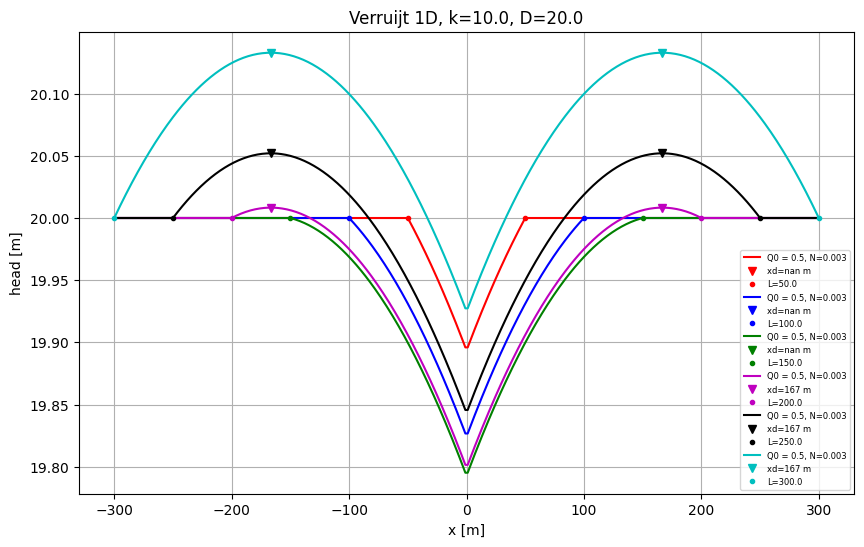

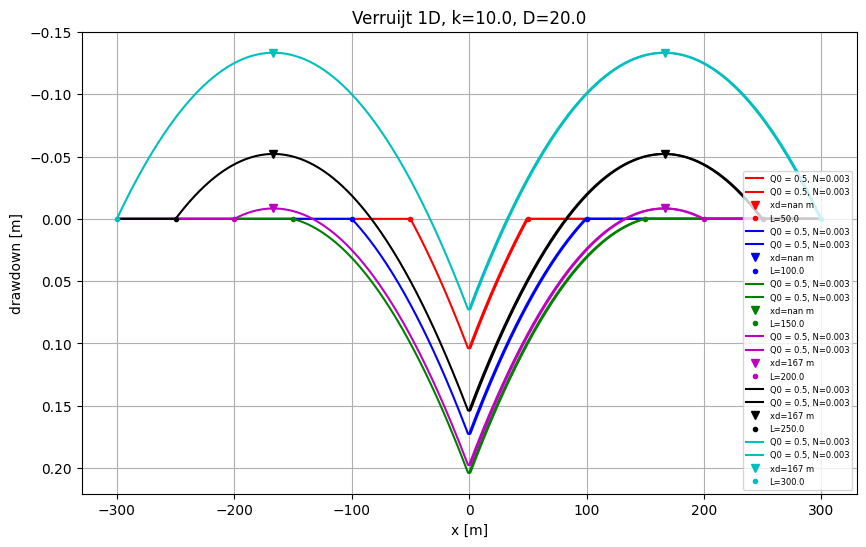

In [12]:
# Verruijt 1D fixed Q0 and varying L

pars = {'k': 10., 'D': 20., 'c': 200., 'L':250.}
pars2 = {'Q0': 0.5, 'N': 0.003}
x = np.linspace(0, 300, 301)[1:]

V1 = Verruijt1D(**pars)
h = V1.h(x=x, **pars2)
# print(h)

# Head
ax = newfig(f"Verruijt 1D, k={pars['k']:.1f}, D={pars['D']:.1f}", "x [m]", "head [m]",
            figsize=(10, 6))

clrs = cycle('rbgmkcy')
for L in [50., 100., 150., 200., 250., 300.]:
    clr = next(clrs)
    V1.L = L
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    h = V1.h(x=x, **pars2)
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((h[::-1], h)), color=clr, label=label)

    xd = V1.xdev(**pars2)
    hd = V1.h(x=xd, **pars2)
    ax.plot([-xd, xd], [hd, hd], 'v', color=clr, label=f"xd={xd:.3g} m")
    ax.plot([-V1.L, V1.L], [V1.D, V1.D], '.', color=clr, label=f'L={L}')

ax.legend(fontsize=6, loc='lower right')

plt.show()

# Drawdown
ax = newfig(f"Verruijt 1D, k={pars['k']:.1f}, D={pars['D']:.1f}", "x [m]", "drawdown [m]", figsize=(10, 6))
ax.invert_yaxis()

clrs = cycle('rbgmkcy')
for L in [50., 100., 150., 200., 250., 300.]:
    clr = next(clrs)
    V1.L = L
    ddn = V1.ddn(x=x, **pars2)
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((ddn[::-1], ddn)), V1.ddn(x=x, **pars2), color=clr, label=label)

    xd = V1.xdev(**pars2)
    ddnd = V1.ddn(x=xd, **pars2)
    ax.plot([-xd, xd], [ddnd, ddnd], 'v', color=clr, label=f"xd={xd:.3g} m")
    ax.plot([-V1.L, V1.L], [0., 0.], '.', color=clr, label=f'L={L}')

ax.legend(fontsize=6, loc='lower right')

plt.show()

## Voorbeeld Verruijt 1D; vaste L, variërende Q0

De onttrekking en, daarmee de verlaging is stapsgewijs vergroot. Hierdoor komt de waterscheiding steeds verder weg te liggen tot deze de vaste rand $L$ bereikt.

Bij verruijt is buiten de vaste rand geen stroming en dus ook geen verlaging.

Bij grote onttrekking is de daling van de grondwaterstand in het eeste plaatje is een stuk groter dan de verlaging in het tweede plaatje. Dit is het gevolg van de afname van de dikte van het watervoerende pakket waar in het eerste plaatje wel en in het tweede plaatje geen rekening mee is gehouden.

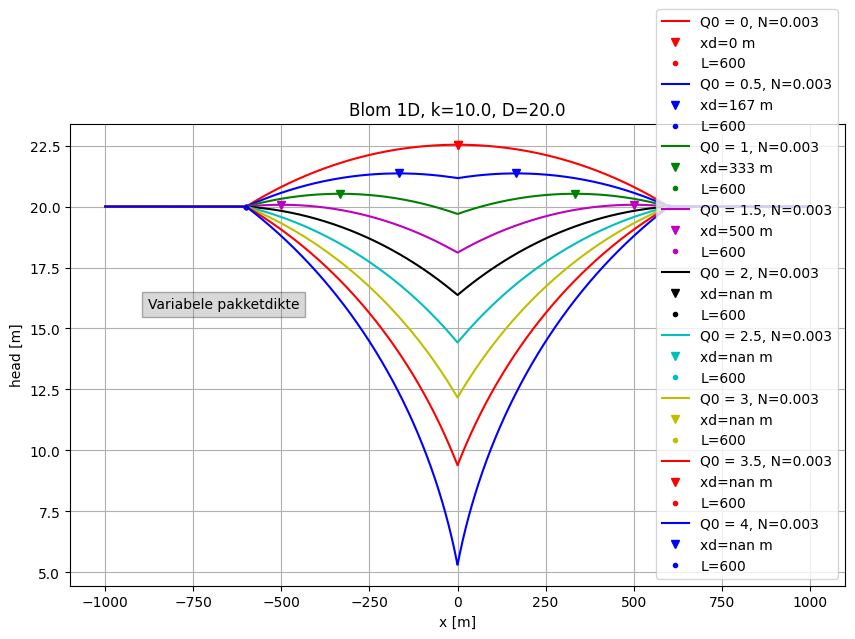

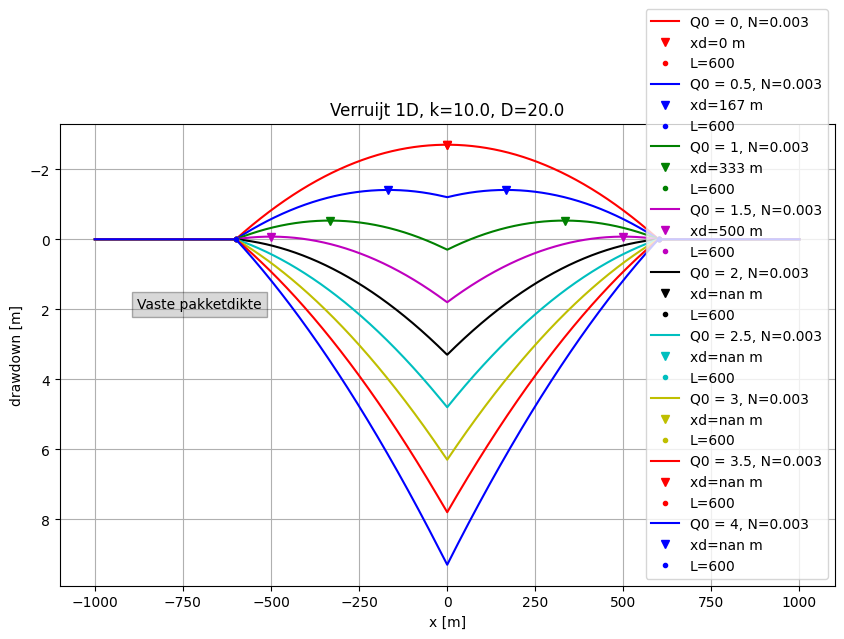

In [13]:
# Verruijt 1D, fixed L and varying Q0

V1.L = 600
x = np.linspace(0, 1000, 5001)[1:]

# head
ax = newfig(f"Blom 1D, k={pars['k']:.1f}, D={pars['D']:.1f}", "x [m]", "head [m]",
            figsize=(10, 6))

clrs = cycle('rbgmkcy')
for Q0 in [0., 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    clr = next(clrs)
    pars2['Q0'] = Q0
    label=f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    h = V1.h(x=x, **pars2)
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((h[::-1], h)), color=clr, label=label)

    xd = V1.xdev(**pars2)
    hd = V1.h(x=xd, **pars2)
    ax.plot([-xd, xd], [hd, hd], 'v', color=clr, label=f"xd={xd:.3g} m")
    ax.plot([-V1.L, V1.L], [V1.D, V1.D], '.', color=clr, label=f'L={V1.L}')

ax.text(0.1, 0.6, "Variabele pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=10, loc='lower right')

plt.show()

# Drawdown
ax = newfig(f"Verruijt 1D, k={pars['k']:.1f}, D={pars['D']:.1f}", "x [m]", "drawdown [m]",
            figsize=(10, 6))
ax.invert_yaxis()

clrs = cycle('rbgmkcy')
for Q0 in [0., 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    clr = next(clrs)
    pars2['Q0'] = Q0
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    ddn = V1.ddn(x=x, **pars2)
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((ddn[::-1], ddn)), color=clr, label=label)

    xd = V1.xdev(**pars2)
    ddnd = V1.ddn(x=xd, **pars2)
    ax.plot([-xd, xd], [ddnd, ddnd], 'v', color=clr, label=f"xd={xd:.3g} m")
    ax.plot([-V1.L, V1.L], [0., 0.], '.', color=clr, label=f'L={V1.L}')

ax.text(0.1, 0.6, "Vaste pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=10, loc='lower right')

plt.show()

## Voorbeeld Blom 1D, variërende Q0

Bij Blom wordt de $L$ berekend, zodanig dat de verlaging op $x=L$ gelijk is aan $N c$.

In dit voorbeeld worden de grondwatertstand en de verlaging berekend voor verschillende waarden van $Q0$. Voor elke Q0 wordt de afstand $L$ berekend waarbinnen de sloten droogvallen. Op deze afstand is de verlaging gelijk aan $N c$, waardoor op afstand $L$ de sloot juist droogvalt (of beter: de sloot daar net niet meer draineert).

We zien verder dat de verlaging in het eerste plaatje, met variabele pakketdikte voor gotere onttrekkingen groter is dan die in het tweede plaatje, voor de situatie met vaste pakketdikte.

Voor de situatie met variabele pakketdikte zou de stijghoogte op $x > L x$ nog iets gecorrigeerd kunnen worden voor de in werkelijkheid afnemende dikte. Dit effect is echter zo klein dat het verschil in de aansluiting op het aangegeven punt, dus $x=L$ in de grafiek niet is te zien. Deze correctie kan eenvoudig worden verwaarloosd in de praktijk.In het onderhavige geval is dit een correctie van de $\lambda van $h/H = (D - s_L) / D \approx 19.5 / 20 \approx 0.98$ op de gebruikte waarde van $\lambda$, dus verwaarloosbaar.

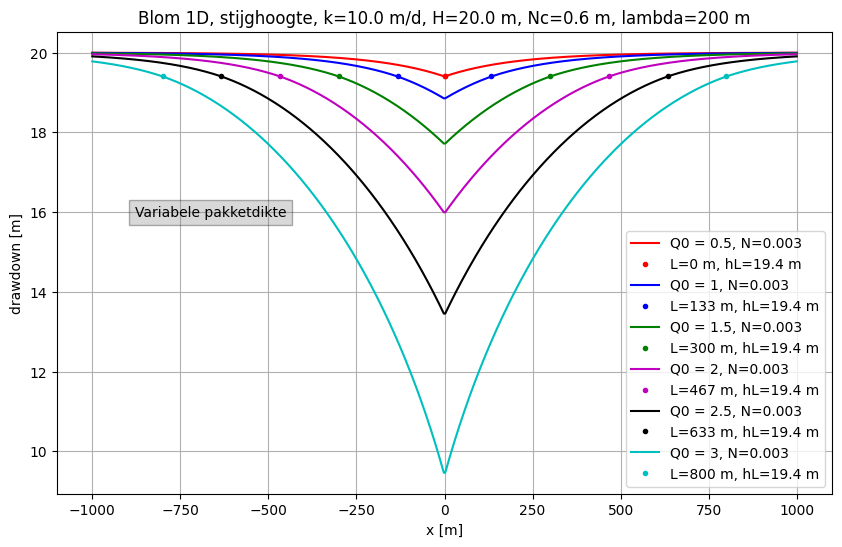

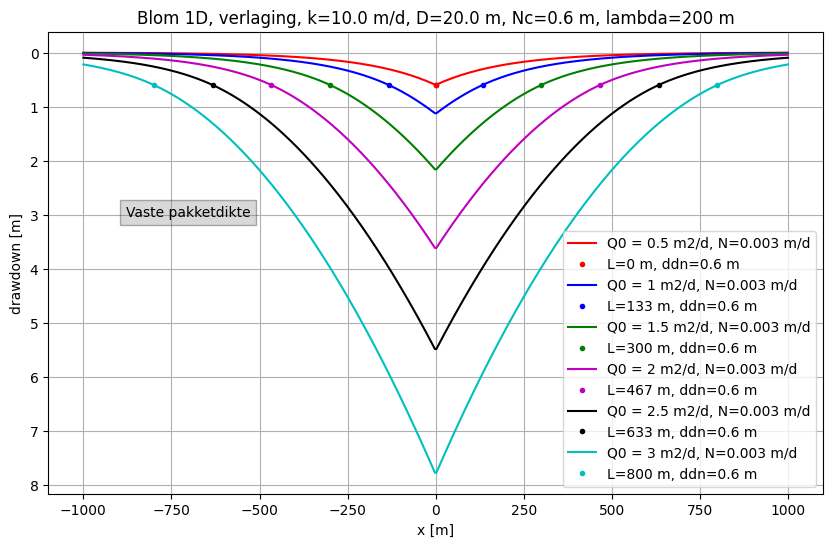

In [14]:
# Blom 1D, fixed L and varying Q0

pars = {'k': 10., 'D': 20., 'c': 200., 'L':250.}
pars2 = {'Q0': 0.5, 'N': 0.003}
x = np.linspace(0, 300, 301)[1:]

B1 = Blom1D(**pars)
h = B1.h(x=x, **pars2)


B1.ddn(x=xd, **pars2)
x = np.linspace(0, 1000, 501)[1:]

# head
ax = newfig(f"Blom 1D, stijghoogte, k={pars['k']:.1f} m/d, H={pars['D']:.1f} m, Nc={pars2['N'] * B1.c:.3g} m, lambda={B1.lam:.3g} m",
            "x [m]", "drawdown [m]",
            figsize=(10, 6))

clrs = cycle('rbgmkcy')
for Q0 in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    clr = next(clrs)
    pars2['Q0'] = Q0
    h = B1.h
    L = B1.getL(**pars2)
    label=f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    h = B1.h(x=x, **pars2)
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((h[::-1], h)), color=clr, label=label)

    xd = B1.xdev(**pars2)
    hd = B1.h(x=xd, **pars2)
    hL = B1.h(x=L, **pars2)    
    if not np.isnan(xd):
        ax.plot([-xd, xd], [hd, hd], 'o', color=clr, label=f"xd={xd:.3g} m, hd={hd:.3g} m")
    
    ax.plot([-L, L], [hL, hL], '.', color=clr, label=f'L={L:.3g} m, hL={hL:.3g} m')

ax.text(0.1, 0.6, "Variabele pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=10, loc='lower right')

plt.show()

# Drawdown
ax = newfig(f"Blom 1D, verlaging, k={pars['k']:.1f} m/d, D={pars['D']:.1f} m, Nc={pars2['N'] * B1.c:.3g} m, lambda={B1.lam:.3g} m",
            "x [m]", "drawdown [m]",
            figsize=(10, 6))
ax.invert_yaxis()

clrs = cycle('rbgmkcy')
for Q0 in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    clr = next(clrs)
    pars2['Q0'] = Q0
    L = B1.getL(**pars2)
    label = label=f"Q0 = {pars2['Q0']:.3g} m2/d, N={pars2['N']:.3g} m/d"
    ddn = B1.ddn(x=x, **pars2)
    ax.plot(np.hstack((-x[::-1], x)), np.hstack((ddn[::-1], ddn)), color=clr, label=label)

    xd = B1.xdev(**pars2)
    ddnd = B1.ddn(x=xd, **pars2)    
    ddnL = B1.ddn(x=L, **pars2)
    if not np.isnan(xd):
        ax.plot([-xd, xd], [ddnd, ddnd], 'o', color=clr, label=f"xd={xd:.3g} m")
    ax.plot([-L, L], [ddnL, ddnL], '.', color=clr, label=f'L={L:.3g} m, ddn={ddnL:.3g} m')

ax.text(0.1, 0.6, "Vaste pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=10, loc='lower right')

plt.show()

## Verruijt en BLom, Axiaal symmetrisch

### Implementatie

In [15]:
class Verruijt():
    """Axial symmetric flow according to Verruijt and Blom."""

    def __init__(self, k=None, D=None, R=None, **_):
        self.k = k
        self.D = D
        self.R = R
        self.kD = self.k * self.D

    def h(self, Q0=None, N=None, r=None):
        H = self.D
        h2 = H ** 2  - Q0 / (np.pi * self.k) * np.log(self.R / r) +\
            N / (2 * self.k) * (self.R ** 2 - r ** 2)
        if np.isscalar(r):
            return np.sqrt(h2) if r < self.R else self.D
        
        h2[r > self.R] = self.D ** 2
        return np.sqrt(h2)

    def ddn(self, Q0=None, N=None, r=None):
        s = Q0 / (2 * np.pi * self.kD) * np.log(self.R / r) -\
            N / (4 * self.kD) * (self.R **2 - r ** 2)
        if np.isscalar(r):
            return s if r < self.R else 0.
        s[r >= self.R] = 0.
        return s
    
    def Q(self, Q0=None, N=None, x=None):
        Q = Q0 - np.pi * N * r ** 2
        if np.isscalar(r):
            return Q if r < self.R else 0.
        else:
            Q[r >= self.R] = 0.
        return Q
        
    def rdivh(self, Q0=None, N=None):
        """Return location of water divide (freatic)."""
        r = np.sqrt(Q0 / (np.pi * N))
        return r if r < self.R else np.nan
    
    def rdivD(self, Q0=None, N=None):
        """Return location of water divide (fixed D)."""
        r = np.sqrt(Q0 / (np.pi * N))
        return r if r < self.R else np.nan 
        
class Blom():

    def __init__(self, k=None, D=None, c=None, R=1.0):
        self.k = k
        self.D = D
        self.c = c
        self.R = R
        self.kD = self.k * self.D
        self.lam = np.sqrt(self.kD * self.c)
     
    def h(self, Q0=None, N=None, r=None):
        R = self.getR(Q0=Q0, N=N, R=self.R)
        RL = R  / self.lam
        QR = Q0 - np.pi * R **2 * N     
        Hinf = self.D
        HR = Hinf - N * self.c
        
        h = np.sqrt(HR ** 2 + N / (2 * self.k) * (R ** 2 - r ** 2) - Q0 / (np.pi * self.k) * np.log(R / r))
        if np.isscalar(r):
            if r > R:
                h = Hinf - QR / (2 * np.pi * self.kD) *\
                    K0(r / self.lam) / (RL * K1(RL))
            return h

        h[r >= R] = Hinf - QR / (2 * np.pi * self.kD) *\
            K0(r[r >= R] / self.lam) / (RL * K1(RL))
        return h


    def ddn(self, Q0=None, N=None, r=None):
        R = self.getR(Q0=Q0, N=N, R=self.R)
        RL = R / self.lam
        QR = Q0 - np.pi * R ** 2 * N
        s = Q0 / (2 * np.pi * self.kD) * np.log(R / r) - N / (4 * self.kD) * (R ** 2 - r ** 2) + N * self.c
        if np.isscalar(r):
            if r > R:
                s = QR / (2 * np.pi * self.kD) * K0(r / self.lam) / (RL * K1(RL))
            return s
        s[r >= R] = QR / (2 * np.pi * self.kD) * K0(r[r >= R] / self.lam) / (RL * K1(RL))
        return s
        
    def Q(self, Q0=None, N=None, r=None):
        R = self.getR(Q0=Q0, N=N, R=self.R)
        Rl = R / self.lam
        rl = R / self.lam
        Q  = Q0 - np.pi * r ** 2 * N
        QR = Q0 - np.pi * R ** 2 * N        
        if np.isscalar(r):
            if r > R:
                Q = QR * rl * K1(rl) / K1(Rl)
            return Q
        else:
            Q[r >= R] = QR * rl[r >= R] * K1(rl[r >= R]) / K1(Rl)
        return Q
        
    def rdivh(self, Q0=None, N=None):
        """Return location of water divide (freatic)."""
        rD = np.sqrt(Q0 / (2 * np.pi * N))
        return rD if rD <= self.R else np.nan
    
    def rdivD(self, Q0=None, N=None):
        """Return location of water divide (fixed D)."""
        rD = np.sqrt(Q0 / (np.pi * N))
        return rD if rD <= self.R else np.nan
    
    def y(self, R=1.0, Q0=None, N=None):
        QR = Q0 - np.pi * R ** 2 * N
        Rl = R  / self.lam
        return -N * self.c + QR / (2 * np.pi * self.kD) * K0(Rl) / (Rl * K1(Rl))
    
    def y1(self, R=None, Q0=None, N=None):
        """Return dy(R)/dR computed analytically."""        
        RL = R / self.lam
        k0k1 = K0(RL) / K1(RL)        
        return -N * self.lam / self.kD * k0k1 -\
            (Q0 / R / (2 * np.pi * self.kD)  - N * R / (2 * self.kD)) *\
                (1 - k0k1  ** 2)

                
    def dydR(self, R=None, Q0=None, N=None, dr=0.1):
        return (self.y(R=R + 0.5 * dr, Q0=Q0, N=N) -
                self.y(R=R - 0.5 * dr, Q0=Q0, N=N)) / dr
                
    def getR(self, Q0=None, N=None, R=1.0, tolR=0.1, n=50,  verbose=False):
        """Return R by Newton's method."""
        if verbose:
            print(f"R initial={R:.3g} m")
        for i in range(n):
            dR = -self.y(R=R, Q0=Q0, N=N) / self.y1(R=R, Q0=Q0, N=N)
            R += dR
            if verbose:
                print(f"iteration {i}, R={R:.3g} m, dR = {dR:.3g} m")
            if abs(dR) < tolR:
                if verbose:
                    print(f"R final ={R:.3g} m")
                self.R = R
                return R
        R = np.nan
        self.R = R        
        print(f"R final ={R:.3g} m")
        return R
    
    def plot_newton_progress(self, R=None, Q0=None, N=None, figsize=(10, 6)):
        """Plot the progress of the Newton method while determining the R wat which the drawdown is Nc."""
        r = np.linspace(0, 300, 101)[1:]
        title = f"y(R) and progress of Newton iterations for Q0={Q0:.4g} , N={N:.4g}, c={self.c:.4g}"
        ax = newfig(title, "r [m]", "y(r) [m]", figsize=figsize)
        
        ax.plot(r, self.y(R=r, Q0=Q0, N=N), label='y(r)')
        
        for _ in range(20):
            #y, y1 = self.y(R=R, Q0=Q0, N=N), self.dydR(R=R, Q0=Q0, N=N)     
            y, y1 = self.y(R=R, Q0=Q0, N=N), self.y1(R=R, Q0=Q0, N=N)
            ax.plot([R, R], [0, y], 'k')     
            ax.plot(R, y, 'bo', mfc='none')
            dR = - y / y1
            ax.plot([R, R + dR], [y, 0], 'k')            
            R += dR
            if abs(dR) < 0.1:
                break            
        ax.legend()
        return ax
        
    def plot_derivative_of_y(self, R=None, Q0=None, N=None, figsize=(10, 6)):
        """Plot the derivative of y, analytical and numerically calculated."""
        r = np.linspace(0, 300, 301)[1:]        
        title = f"Derivatives of y for Q0={Q0:.4g} , N={N:.4g}, c={self.c:.4g}"
        ax = newfig(title, "R [m]", "y(r) [m]", figsize=figsize)
        ax.plot(r, self.y1(  R=r, Q0=Q0, N=N), '-', label='y1 (analytic)')        
        ax.plot(r, self.dydR(R=r, Q0=Q0, N=N), '.', label='dydR (numerical)')
        ax.legend()
        return ax


## Voorbeelden Verruijt, axiaal symmetrisch

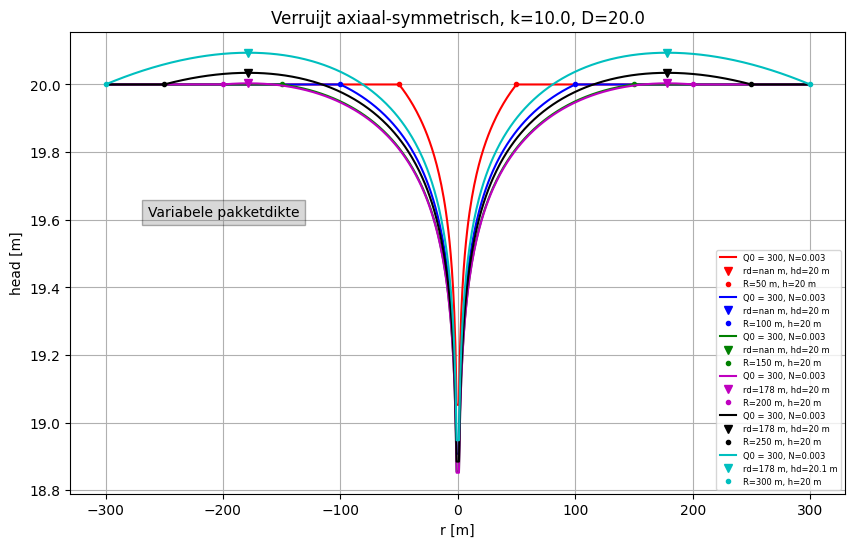

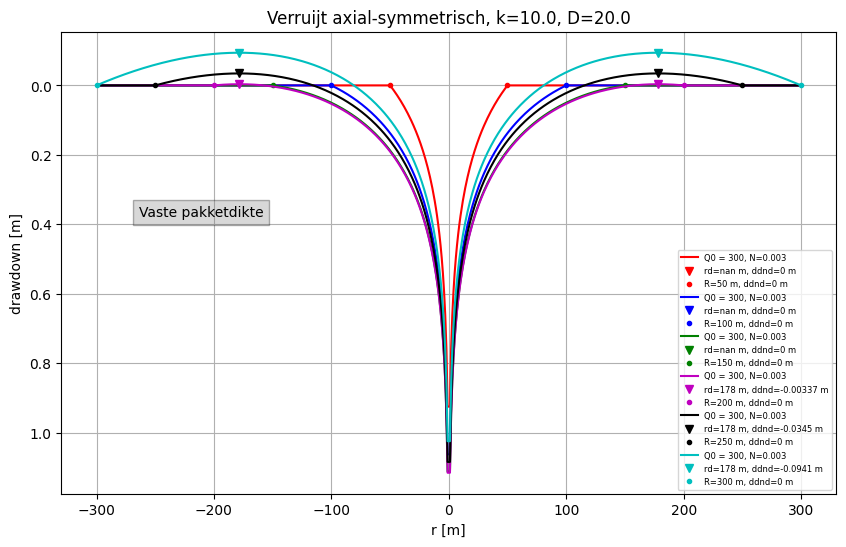

In [16]:
# Verruijt 1D fixed Q0 and varying R

pars = {'k': 10., 'D': 20., 'c': 200., 'R':250.}
pars2 = {'Q0': 300, 'N': 0.003}
r = np.linspace(0, 300, 301)[1:]

V2 = Verruijt(**pars)
h = V2.h(r=r, **pars2)
# print(h)

# Head
ax = newfig(f"Verruijt axiaal-symmetrisch, k={pars['k']:.1f}, D={pars['D']:.1f}",
            "r [m]", "head [m]",
            figsize=(10, 6))

clrs = cycle('rbgmkcy')
for R in [50., 100., 150., 200., 250., 300.]:
    clr = next(clrs)
    V2.R = R
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    h = V2.h(r=r, **pars2)
    ax.plot(np.hstack((-r[::-1], r)), np.hstack((h[::-1], h)), color=clr, label=label)

    rd = V2.rdivh(**pars2)
    hd = V2.h(r=rd, **pars2)
    ax.plot([-rd, rd], [hd, hd], 'v', color=clr, label=f"rd={rd:.3g} m, hd={hd:.3g} m")
    ax.plot([-V2.R, V2.R], [V2.D, V2.D], '.', color=clr, label=f'R={R:.3g} m, h={V2.D:.3g} m')

ax.text(0.1, 0.6, "Variabele pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=6, loc='lower right')

plt.show()

# Drawdown
ax = newfig(f"Verruijt axial-symmetrisch, k={pars['k']:.1f}, D={pars['D']:.1f}",
            "r [m]", "drawdown [m]",
            figsize=(10, 6))
ax.invert_yaxis()

clrs = cycle('rbgmkcy')
for R in [50., 100., 150., 200., 250., 300.]:
    clr = next(clrs)
    V2.R = R
    ddn = V2.ddn(r=r, **pars2)
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    ax.plot(np.hstack((-r[::-1], r)), np.hstack((ddn[::-1], ddn)), color=clr, label=label)

    rd = V2.rdivD(**pars2)
    ddnd = V2.ddn(r=rd, **pars2)
    ax.plot([-rd, rd], [ddnd, ddnd], 'v', color=clr, label=f"rd={rd:.3g} m, ddnd={ddnd:.3g} m")
    ax.plot([-V2.R, V2.R], [0., 0.], '.', color=clr, label=f'R={R:.3g} m, ddnd={0.:.3g} m')

ax.text(0.1, 0.6, "Vaste pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=6, loc='lower right')

plt.show()


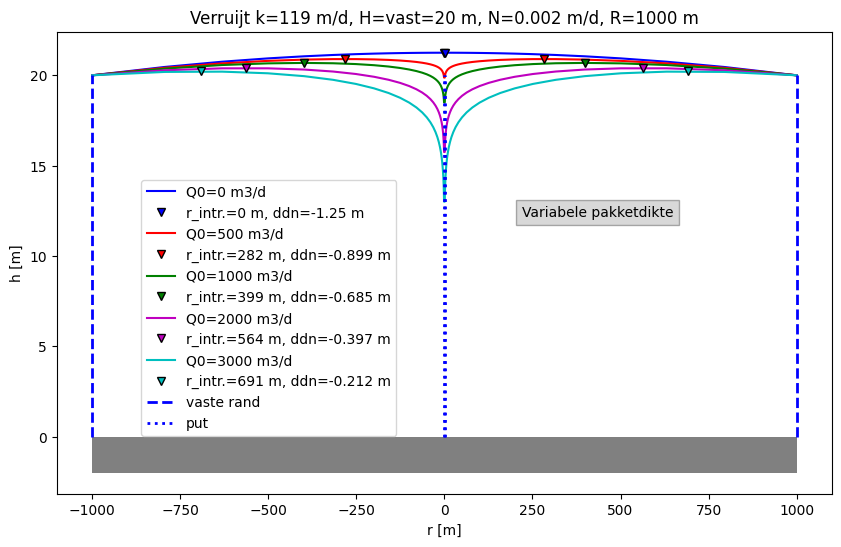

In [17]:
# Bodemconstanten, gebiedsradius, voeding, onttrekking en putstraal
pars = {'k': 20, 'D': 20, 'R':1000.}
pars2 = {'Q0': 1200., 'N': 0.002}

V2 = Verruijt(**pars)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Verruijt k={k:.0f} m/d, H=vast={pars['D']:.0f} m, N={pars2['N']:.3g} m/d, R={pars['R']:.0f} m")
ax.set_xlabel("r [m]")
ax.set_ylabel("h [m]"),
            
# Kleuren en debieten
clrs = cycle('brgmck')
Qs =[0.001, 500, 1000, 2000, 3000]

r = np.logspace(0, 3, 31)
R = pars['R']
H = pars['D']

for Q0 in Qs:
    pars2['Q0'] = Q0
    clr = next(clrs)    
    # Stijghoogte (links en rechts)
    ddn = V2.ddn(r=r, **pars2)
    ax.plot(np.hstack((-r[::-1], r)), H - np.hstack((ddn[::-1], ddn)), color=clr,
            label=f'Q0={Q0:.0f} m3/d')

    # Intrekgebied, radius = rI, links en rechts    
    rI = V2.rdivD(**pars2)
    ddnI = V2.ddn(r=rI, **pars2)
    ax.plot([-rI, rI], [H - ddnI, H - ddnI], ls='none', marker='v', mfc=clr,
            mec='k', ms=6, label=f'r_intr.={rI:.0f} m, ddn={ddnI:.3g} m', zorder=5)    

# Vaste randen
H = pars['D']
ax.plot([+R, +R], [0, H], '--', color='blue', lw=2, label='vaste rand')
ax.plot([-R, -R], [0, H], '--', color='blue', lw=2, label='')

# Put
rw = 0.5
ax.plot([+rw, +rw], [0, H], ':', color='blue', lw=2, label='put')
ax.plot([-rw, -rw], [0, H], ':', color='blue', lw=2, label='')

# Pakket bodem
ax.add_patch(patches.Rectangle((-R, -2), 2 * R, 2, fc='gray'))

ax.text(0.6, 0.6, "Variabele pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
leg = ax.legend(loc='lower left', fontsize=10)
leg.set_bbox_to_anchor((0.10, 0.11, 0.3, 0.5), transform=ax.transAxes)

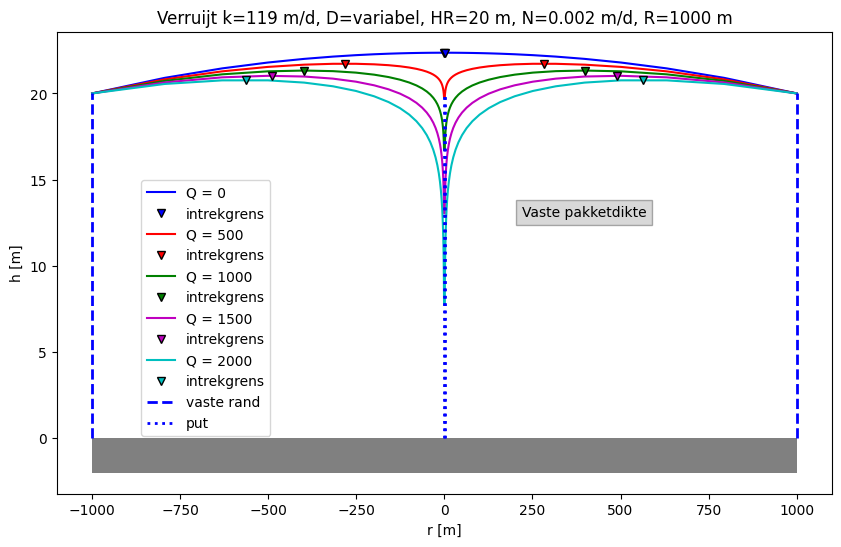

In [18]:
# Bodemconstanten, gebiedsradius, voeding, onttrekking en putstraal
pars = {'k': 10, 'D': 20, 'R':1000.}
pars2 = {'Q0': 1200., 'N': 0.002}

V2 = Verruijt(**pars)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Verruijt k={k:.0f} m/d, D=variabel, HR={pars['D']:.0f} m, N={pars2['N']:.3g} m/d, R={pars['R']:.0f} m")
ax.set_xlabel("r [m]")
ax.set_ylabel("h [m]"),
            
# Kleuren en debieten
clrs = cycle('brgmck')
Qs =[0.001, 500, 1000, 1500, 2000] #  2500]

r = np.logspace(0, 3, 31)
R = pars['R']

for Q0 in Qs:
    pars2['Q0'] = Q0
    clr = next(clrs)    
    # Stijghoogte (links en rechts)
    h = V2.h(r=r, **pars2)
    ax.plot(np.hstack((-r[::-1], r)), np.hstack((h[::-1], h)), color=clr,
            label=f'Q = {Q0:.0f}')

    # Intrekgebied, radius = rI, links en rechts
    rI = np.sqrt(Q0 / (np.pi * pars2['N']))
    rI = V2.rdivh(**pars2)
    hI = V2.h(r=rI, **pars2)
    ax.plot([-rI, rI], [hI, hI], ls='none', marker='v', mfc=clr,
            mec='k', ms=6, label='intrekgrens', zorder=5)    

# Vaste randen
H = pars['D']
ax.plot([+R, +R], [0, H], '--', color='blue', lw=2, label='vaste rand')
ax.plot([-R, -R], [0, H], '--', color='blue', lw=2, label='')

# Put
rw = 0.5
ax.plot([+rw, +rw], [0, H], ':', color='blue', lw=2, label='put')
ax.plot([-rw, -rw], [0, H], ':', color='blue', lw=2, label='')

# Pakket bodem
ax.add_patch(patches.Rectangle((-R, -2), 2 * R, 2, fc='gray'))

ax.text(0.6, 0.6, "Vaste pakketdikte", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
leg = ax.legend(loc='lower left', fontsize=10)
leg.set_bbox_to_anchor((0.10, 0.11, 0.3, 0.5), transform=ax.transAxes)

## Voorbeeld Blom, axiaal symmetrisch

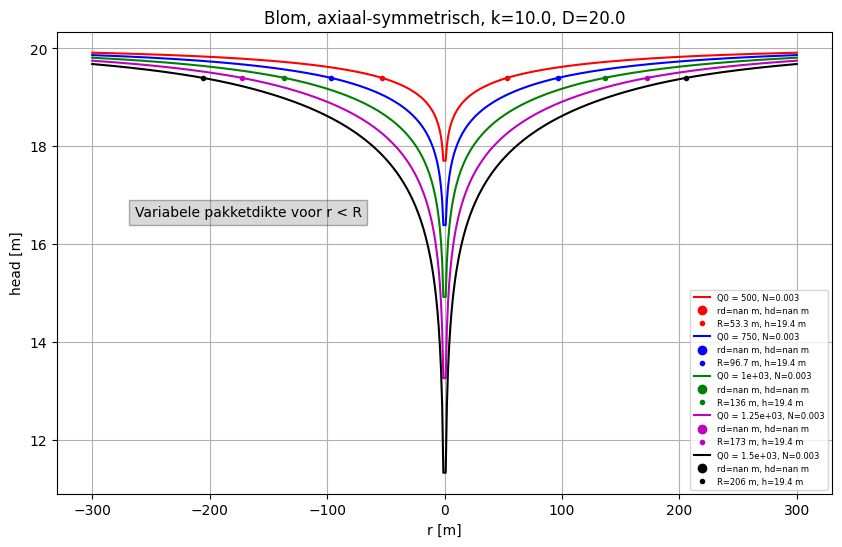

In [19]:
# Blom axiaal symmetrisch, fixed Q0 and varying R

pars = {'k': 10., 'D': 20., 'c': 200.}
pars2 = {'Q0': 300, 'N': 0.003}
r = np.linspace(0, 300, 301)[1:]

B2 = Blom(**pars)

# Head
ax = newfig(f"Blom, axiaal-symmetrisch, k={pars['k']:.1f}, D={pars['D']:.1f}",
            "r [m]", "head [m]",
            figsize=(10, 6))

clrs = cycle('rbgmkcy')
for Q0 in np.array([1., 1.5, 2., 2.5, 3.0]) * 500.:
    clr = next(clrs)
    pars2['Q0'] = Q0
    R = B2.getR(R=B2.R, **pars2)
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    h = B2.h(r=r, **pars2)
    ax.plot(np.hstack((-r[::-1], r)), np.hstack((h[::-1], h)), color=clr, label=label)

    rd = B2.rdivh(**pars2)
    hd = B2.h(r=rd, **pars2)
    ax.plot([-rd, rd], [hd, hd], 'o', color=clr, label=f"rd={rd:.3g} m, hd={hd:.3g} m")
    HR = B2.D - pars2['N'] * B2.c
    ax.plot([-R, R], [HR, HR], '.', color=clr, label=f'R={R:.3g} m, h={HR:.3g} m')

ax.text(0.1, 0.6, "Variabele pakketdikte voor r < R", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=6, loc='lower right')

plt.show()

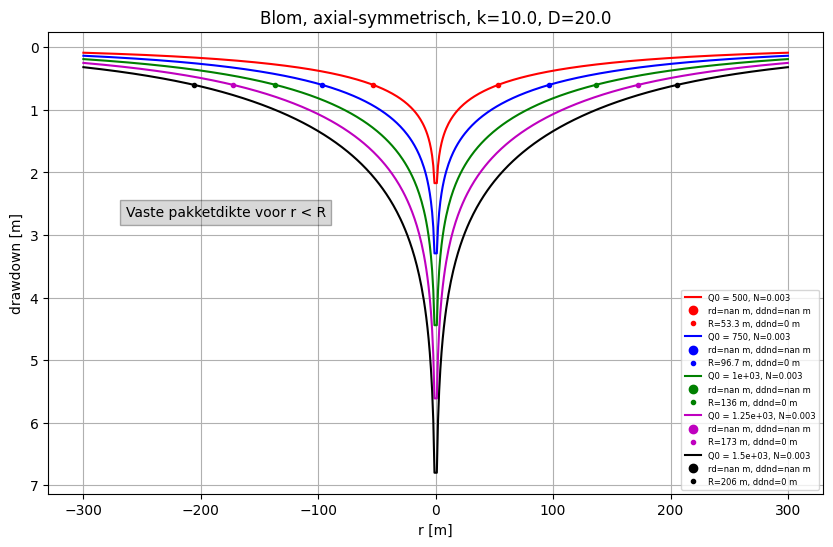

In [20]:
# Drawdown
B2 = Blom(**pars)

ax = newfig(f"Blom, axial-symmetrisch, k={pars['k']:.1f}, D={pars['D']:.1f}",
            "r [m]", "drawdown [m]",
            figsize=(10, 6))
ax.invert_yaxis()

clrs = cycle('rbgmkcy')
for Q0 in np.array([1., 1.5, 2., 2.5, 3.0]) * 500.:
    clr = next(clrs)
    pars2['Q0'] = Q0
    R = B2.getR(R=B2.R, **pars2)    
    ddn = B2.ddn(r=r, **pars2)
    label = f"Q0 = {pars2['Q0']:.3g}, N={pars2['N']:.3g}"
    ax.plot(np.hstack((-r[::-1], r)), np.hstack((ddn[::-1], ddn)), color=clr, label=label)

    rd = B2.rdivD(**pars2)
    ddnd = B2.ddn(r=rd, **pars2)
    ax.plot([-rd, rd], [ddnd, ddnd], 'o', color=clr, label=f"rd={rd:.3g} m, ddnd={ddnd:.3g} m")
    ddnR = pars2['N'] * B2.c
    ax.plot([-R, R], [ddnR, ddnR], '.', color=clr, label=f'R={R:.3g} m, ddnd={0.:.3g} m')

ax.text(0.1, 0.6, "Vaste pakketdikte voor r < R", transform=ax.transAxes, bbox=dict(facecolor='gray', alpha=0.3))
ax.legend(fontsize=6, loc='lower right')

plt.show()

### Demonstratie van de voortgang van het iteratieproces volgens Newton om R te vinden waar de verlaging gelijk is aan Nc

De afstand van de put waarop de verlaging precies gelijk is aan Nc, het critierium voor juist droogvallen van de sloten wordt iteratief berekend met de methode van Newton. Het voorschrijden van dit iteatieproces wordt hieronder grafisch weergegeven.

Voor de iteraties is de afgeleide nodig van de fuctie $y(R)$ zie boven. De tweede grafiek toont de afgeleide, zowel analytisch als numeriek berekent ter controle.

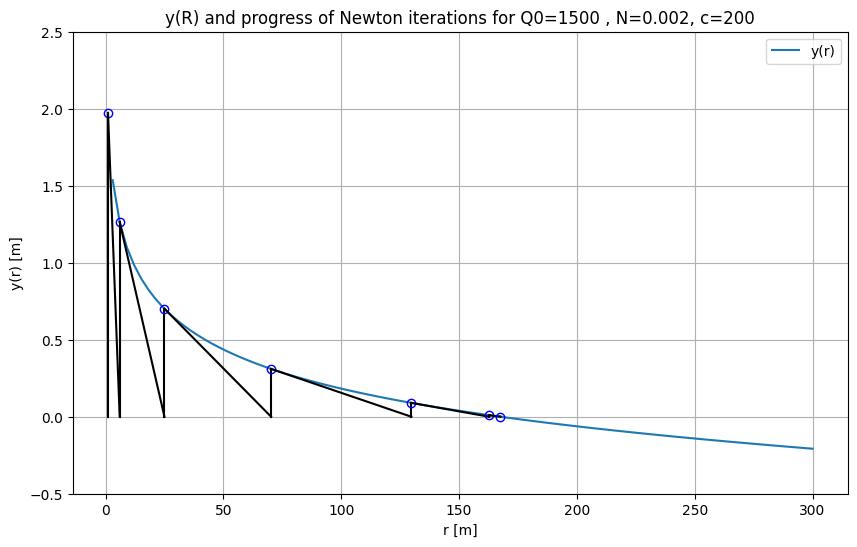

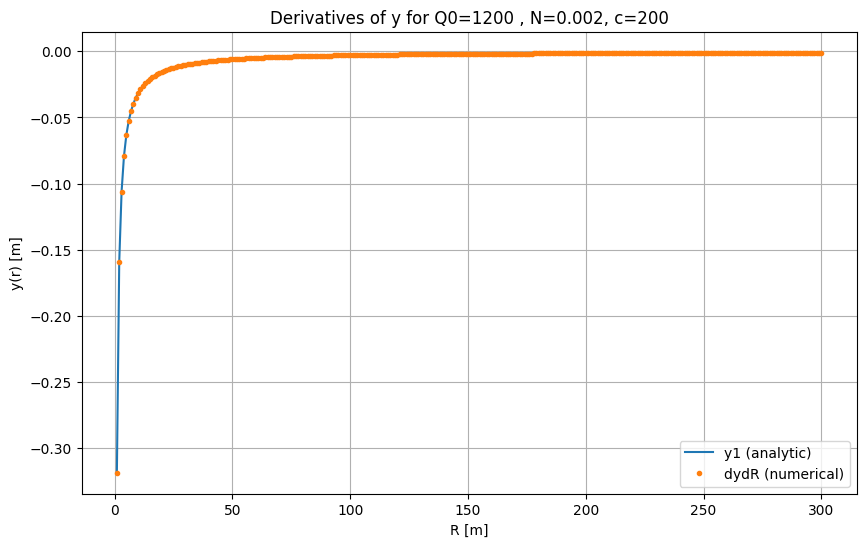

In [21]:
pars = {'k': 30.0, 'D': 20.0, 'c': 200.0, 'R': 1.0}
pars2 = {'Q0': 1200., 'N':0.02}

B2 = Blom(**pars)
ax = B2.plot_newton_progress(R=1., Q0=1500.0, N=0.002)
ax.set_ylim(-0.5, 2.5)

ax = B2.plot_derivative_of_y(R=1, Q0=1200.0, N=0.002)

# Hoe lang duurt het voordat de verlagingen als stationair kan worden beschouwd?

Bij onttrekking met een put in een oneindig uitgestrekt watervoerend paket ontstaat nooit een stationaire eindsituatie omdat er geen terugkoppeling is tussen verlagen en infiltratie.

Verlagingen kunnen alleen stationair worden wanneer ergens in het watervoernde pakket randen zijn met vaste stijghoogte, danwel er een vaste stijghoogte is in een bovenliggend pakket waarmee hydraulische verbinding bestaat via lek door een semi-doorlatende laag. De essentie is dat door de verlaging een stroming wordt opgewekt die op termijn de onttrekking volledig kan compenseren.

De belangrijkste situatie waarbij stationaire stoming optreedt is meestal die met oppervlaktewater verderop in het gebied of een semi-permanente toplaag waarboven het oppervlaktewaterpeil ruimtelijk wordt beheerd.

Voor een put die onttrekt uit een pakket met semi-gespannen water geldt de formule van Hantush (1955)

$$ s(r, t) = \frac{Q}{4 \pi kD} W_h \left(u, \rho\right), \,\,\,\,with\,\,\,\, u = \frac{r^2 S}{4 kD t},\,\,\,\,and\,\,\,\,\rho=\frac{r}{\lambda}$$

Wanneer deze verlaging wordt uitgezet op logartmische tijdschaal blijkt er een buigpunt te zijn halverwege de eindverlaging, waar de verlaging steeds trager naar toe loopt. Het tijdstip van dit buigpunt is een geschikt moment om op praktische wijze de tijd te bepalen waarna de verlaging als stationair mag worden beschouwd.

Het buigpunt ligt op

$$ u = \frac \rho 2 = \frac{r}{2 \lambda}$$

Om het snijpunt van de raaklijn door het buigpunt en de horizontale lijn van de eindverlaging te bepalen, is het mathematisch handiger om direct met de de parameter op de horizontale as te werken

$$ \eta = \ln \left(\frac 1 u \right) = -\ln u $$

De tangent of the raaklijn door de het buigpunt op de as $1/u$ is

$$ \left(\frac{\partial W_h}{\partial \eta} \right) = e^{-\rho}$$

De stationaire eindwaarde is

$$W_h(0, \rho) = 2 K_0(\rho)$$

Waar de raaklijn door het buigpunt de lijn met de eindverlaging snijdt is de verlaging halverwege de eindverlaging behorend bij de stationaire situatie. Het punt waarop de verlaging stationair is geworden kan praktisch worden gedefinieerd als het punt waarop de raaklijn door het buigpunt de horizontale lijn met de eindverlaging snijdt.

$$ \eta = e^{\rho} K_0(\rho) + \eta_{Bp},\,\,\,\,with\,\,\,\,\eta = -\ln(u)$$

$$ \eta_{Bp} = -\ln \left(u_{Bp} \right),\,\,\,\, with\,\,\,\,u_Bp = \frac{\rho}{2}$$

$$\eta - \eta_Bp = e^{\rho} K_0(\rho)$$

$$\frac{e^\eta}{e^{\eta_{Bp}}} = e^{e^{\rho} K_0(\rho)}$$

$$\frac{u_{Bp}}{u} = e^{e^{\rho} K_0(\rho)}$$

Het stijdtip (de $u$-waarde) waarop de verlaging als stationair mag worden beschouwd volgt dus direct uit de $u$-waarde van het buigpunt $u_{Bp}$ en $\rho=r/(2 \lambda)$:

$$ u = u_{Bp}  e^{-e^{\rho} K_0(\rho)}$$

In het voorbeeld hieronder wordt de Hantush functie getoond versus $1/u$ op logaritmische schaal. Het eerste deel van de dubbele buiging start wanneer de invloedsgrens van de onttrekking het waarnemingsput bereikt en het tweede deel wanneer de verlaging wordt afgeremd door de opgewekte lek. De eindverlaging is gelijk aan de stationaire verlaging, zodat, met $t\rightarrow\infty,\,\,u\rightarrow0$:

$$ W_h(0, \rho) = 2 K_0(\rho)$$

Het buigpunt light op halve hoogte, dus bij $W_h(u_{bp}) = K_0(\rho)$. Voor het buigpunt geldt bovendien

$$u_{bp} = \frac{\rho}{2} = \frac{r}{2 \lambda} $$

De berekende buigpunten worden met een dikke stip in de grafiek aangegeven.

Voorts is in de grafieken aangegeven waar de raaklijn door het buigpunt en waar de eindverlaging snijdt (stippelijn met snijpunt).

Het snijpunt van deze raaklijn met de eindverlaging ligt op

$$ u = u_{Bp}  e^{-e^{\rho} K_0(\rho)}$$

Deze gemakkelijk te berekenen waarde van $u$ is een praktische waarde voor het definieren van het moment waarop de eindverlaging is bereikt kan worden beschouwd.

$$ u = \frac{\rho}{2} e^{-{e^\rho} K_0(\rho)}$$

Voor een reële situatie (met het argument in de Theis-formule (geen lek) links staat en de invloed van de lek rechts):

$$u = \frac{r^2 S}{4 kD t}=\frac{r}{2 \lambda} e^{-{e^{\frac{r}{\lambda}} K_0\left(\frac{r}{\lambda}\right)}}$$

of

$$ u = \frac{r^2 S}{4 kD t}=\frac 1 2 \rho e^{-{e^{\rho} K_0(\rho)}}$$

Het voorbeeld toont het verloop van de verlaging in de tijd, met de tijd op logarithmische schaal voor verschillende waarden voor $\lambda$. Op het buigpunt is de verlaging steeds halverwege de stationaire eindwaarde. Een redelijk critirum voor het bereiken van de stationaire eindwaarde lijkt het snijpunt van de raaklijn door het buigpunt met de horizontale lijn die de eindverlaging weergeeft. Dit punt is steeds met een grafische punt weergegeven in de grafiek.

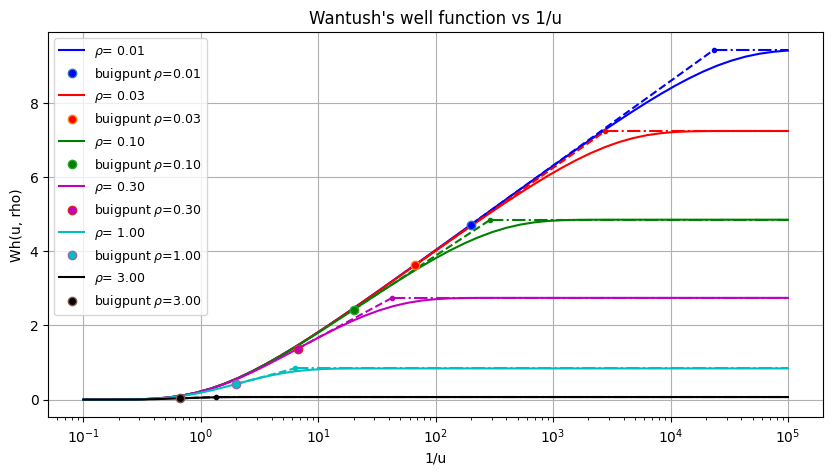

In [22]:
u = np.logspace(-5, 1, 51)
ax = newfig("Wantush's well function vs 1/u", "1/u", "Wh(u, rho)", xscale='log', figsize=(10, 5))

clrs = cycle('brgmck')

rhos = [0.01, 0.03, 0.1, 0.3, 1, 3]

for rho in rhos:
    clr = next(clrs)
    
    # Hantush
    ax.plot(1/u, Wh(u, rho), color=clr, label=r'$\rho$= {:.2f}'.format(rho))
    
    # u-waarde van buigpunt
    uBp = rho  / 2    
    eta2 = np.exp(rho) * K0(rho) - np.log(uBp)
    u2 = np.exp(-eta2)
    
    # Buigpunt
    ax.plot(1 / uBp, Wh(rho / 2, rho), 'o', mfc=clr,  label=r'buigpunt $\rho$={:.2f}'.format(rho), zorder=5.1)    
    
    # Het raaklijn door buigpunt --- lijn
    ax.plot([1 / uBp, 1 / u2], [K0(rho), 2 * K0(rho)], '.--', color=clr, label='', zorder=4.9)
    
    # Eindverlaging -.-.- lijng
    ax.plot([1 / u2, 1 / u[0]], [2 * K0(rho), 2 * K0(rho)], '-.', color=clr, label='', zorder=5)

ax.legend(loc='upper left', fontsize=9)


# Vertraagde nalevering (Delayed yield)

Pompproeven die als basis voor aanvragen van vergunningen worden uitgevoerd, zijn vaak zo kort dat alleen de verlaging in het bepompte pakket kan worden bepaald, en geen informatie wordt verkregen overhet na langere tijd nazakken van het freatisch vlak boven de scheidende laag. Dit freatische vlak zakt later na omdat het pompen lek opwekt door de scheidende laag op het watervoerende pakket. Dit nazakken is vertraagd ten opzichte van de verlaging die in het watervoerend pakket optreedt, wat het gevolg is van de bergingscoëfficiënt die voor het freatisch pakket veel hoger is dan die van het semi-gespannen watervoerende pakket. De voortoets zou altijd moeten eisen dat dit effect van nazakken wordt meegenomen in de analyse omdat de eindwaarde die ogenschijnlijk na enkele dagen al is bereikt in het watervoerende pakket niet de eindwaarde van de verlaging in het freatisch pakket is en derhalve misleidend en vaak ten onrechte wordt gebruikt als eindverlaging.

$$ s = \frac Q {4 \pi kD} W(u) = \frac Q {2 \pi kD} K_0 \left(\frac r \lambda \right) $$

$$ W(u) = 2 K_0 \left(\frac r \lambda \right) $$

$$ \ln \left( \frac {2.25 kD t}{r^2 S_y} \right) = 2 K_0 \left(\frac r \lambda \right) $$

$$t = \frac{r^s S_y} {2.25 kD} e^{2 K_0 \left( \frac r \lambda \right)}$$

De algemene situatie met vertraagde navlevering kan voor het semi-gespannen pakket worden benaderd door de aanvankeijke verlaging volgens Hantush met de elastische bergingscoëfficiënt S te laten vervolgen met de verlaging volgens Theis met de freatische bergingscoëfficiënt. Het aansluitpunt van de twee curves is het punt waarop de freatische verlaging voglens Theis die van Hantush inhaalt.Vanaf dat moment zijn de verlaging in het ondiepe en diepe pakket geijk, en lopen samen verder op. In de werkelijkheid ontstaat een vloeiende overgang van de Hantush verlaging naar die volgens Theis, die met een tweelagen model kan worden berekend. Dat is wat ingewikkelder en niet noodzakelijk voor een adequaat beeld van wat er in de werkelijkheid gebeurt. Voor de praktijk kan de hier gevolgde methode als benadering worden gebruikt. Hij laat in elk geval zien hoe lang men een pompproef doen om zeker te weten dat er in later stadium geen substantiële daling van het freatisch vlak optreedt.

In het voorbeeld hieronder met de verlaging op drie afstanden in het watervoerend pakket zijn de getrokken lijnen berekend met de formule van Hantush (elastische bergingscoëfficiënt) voor semi-gespannen water. De stippellijnen zijn berekend met de formule van Theis (freatische bergingscoëfficiënt). Na verloop van tijd halen de lijnen volgen Theis die volgens Hantush in. Vanaf dat moment gaan de verlaging van het freatische water en die van het semi-gespannen water gelijk op. De oplopende lijnen vanaf het intersectiepunt is de nazakking, die zowel in het freatische als in het sem-gespannen pakket plaats vindt.

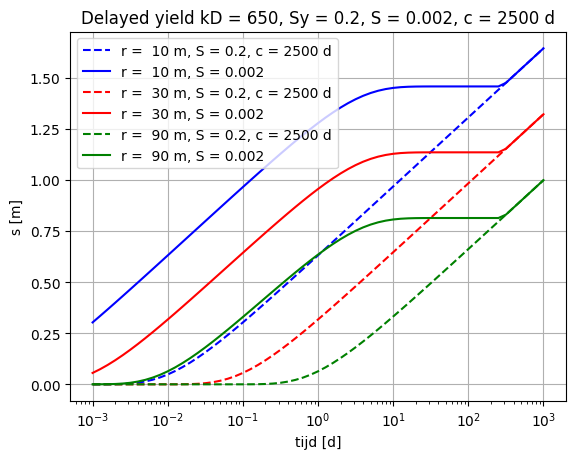

In [23]:
kD, Sy,S, c, Q0 = 650, 0.2, 0.002, 2500., 1200
L = np.sqrt(kD * c)

t = np.logspace(-3, 3, 61)
rs = [10, 30, 90]

ax = newfig("Delayed yield kD = {:.0f}, Sy = {:.3g}, S = {:.3g}, c = {:.0f} d".format(kD, Sy, S, c),
            "tijd [d]", "s [m]",xscale='log')
clrs = cycle('brgmck')
for r in rs:
    clr = next(clrs)
    rho = r  / L
    tx = r ** 2 * Sy / (2.25 * kD) * np.exp(2 * K0(rho))
    u1 = r ** 2 * Sy / (4 * kD * t)
    u2 = r ** 2 * S  / (4 * kD * t)    
    s1 = Q0 / (4 * np.pi * kD) * Wt(u1)
    s2 = Q0 / (4 * np.pi * kD) * Wh(u2, rho)    
    s2[t > tx] = s1[t > tx]
    ax.plot(t, s1, ls='--', color=clr, label='r = {:3.0f} m, S = {}, c = {:.0f} d'.format(r, Sy, c))
    ax.plot(t, s2, ls= '-', color=clr, label='r = {:3.0f} m, S = {}'.format(r, S))
ax.legend()
plt.show()



## Invloedstraal (radius of influence)

### Benaderend
Om de in de tijd toenemende reikwijdte van een onttrekking aan te geven wordt wel gesproken van invloedsgrens of "radius of influence". Deze "radius of influence" bij een continue onttrekking in een zich oneindig uitstrekkend watervoerend pakket zonder lek kan direct worden afgeleid uit de verlaging volgens Theis, die in dit geval van toepassing is. De verlaging volgens Theis kan voor voldoende grote tijd worden benaderd met de vereenvoudigde formule met daarin de logarithme in plaats van de well function:

$$ s = \frac Q {4 \pi kD} \ln\left(\frac{2.25 kD t}{r^2 S}\right) $$

Voor het nog niet beïnvloede gebied geldt dat de verlaging nog nul is. Dit is hier (bij benadering) het geval wanneer het argument onder de logaritme gelijk is aan 1:

$$ \frac{2.25 kD t}{r^2 S} = 1 $$

zodat daar een "radius of influence" uit volgt, die gelijk is aan

$$ r = \sqrt{\frac {2.25 kD t}{S}} $$ 

Deze formule is een eenvoudige doch uitermate praktisch uitdrukking om de radius te bepalen waarbuiten de invloed van de onttrekking nog niet bemerkbaar is. Het is een benadering, omdat de gebruikte formule van de verlaging een benadering is, maar het is een praktische benadering die op de aangegeven wijze objectief is afgeleid. Hieronder volgt een voorbeeld waarin de werking van deze radius inzichtelijk wordt gemaakt. 

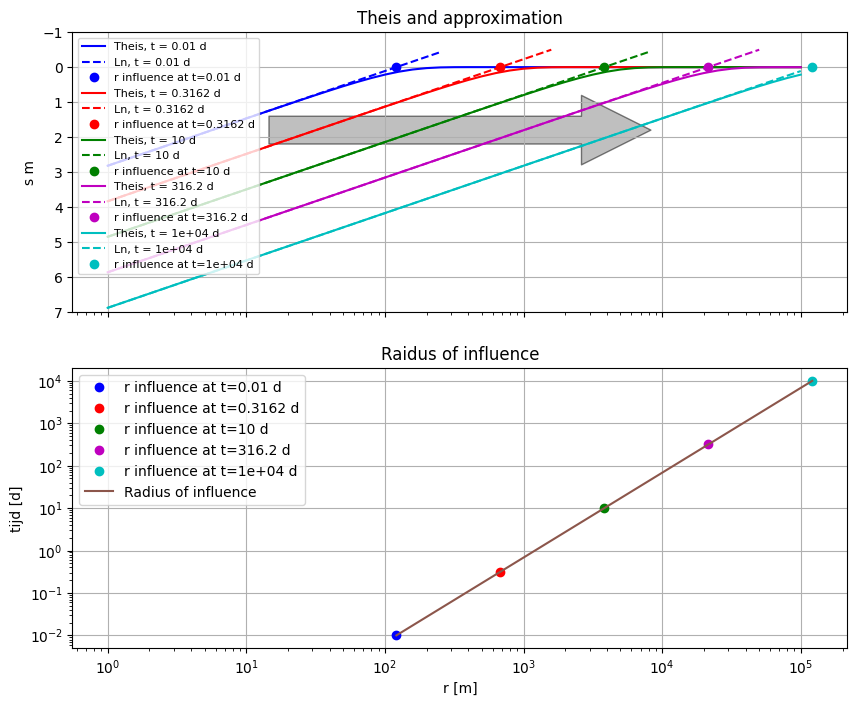

In [24]:
kD, S, Q0 = 650, 0.001, 2400

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True )
axs[0].set_title('Theis and approximation')
axs[0].set_ylabel('s m')
axs[0].grid()
axs[0].set_xscale('log')
axs[0].set_ylim(7, -1)
axs[1].set_title('Raidus of influence')
axs[1].set_ylabel('tijd [d]')
axs[1].set_xlabel('r [m]')
axs[1].set_yscale('log')
axs[1].grid()

r = np.logspace(0, 5, 51)
ts = np.logspace(-2, 4, 5)

clrs = cycle('brgmck')
for t in ts:
    clr = next(clrs)
    u = r ** 2 * S  /( 4 * kD * t)
    sTheis = Q0 / (4 * np.pi * kD)* Wt(u)
    sLn    = Q0 / (4 * np.pi * kD) * np.log(2.25 * kD * t / (r ** 2 * S))
    axs[0].plot(r, sTheis, ls='-',  color=clr, label='Theis, t = {:.4g} d'.format(t))
    axs[0].plot(r[sLn > -0.5], sLn[sLn > -0.5],    ls='--', color=clr, label='Ln, t = {:.4g} d'.format(t))
    rinf = np.sqrt(2.25 * kD * t / S)
    axs[0].plot(rinf, 0, 'o', mfc=clr, mec=clr, label='r influence at t={:.4g} d'.format(t))
    axs[1].plot(rinf, t, 'o', mfc=clr, mec=clr, label='r influence at t={:.4g} d'.format(t))
    
arrow = patches.FancyArrowPatch((0.25, 0.65), (0.75,0.65), transform=axs[0].transAxes,
                                mutation_scale=100, fc='gray', ec='black', alpha=0.5)
#arrow = patches.FancyArrowPatch((0.25, 0.75), (0.75,0.75), transform=fig.transFigure, fc='gray', ec='black', alpha=0.5)
axs[0].add_patch(arrow)
axs[0].legend(loc='upper left', fontsize=8)

tt = np.logspace(-2, 4, 61)
rinf = np.sqrt(2.25 * kD * tt / S)
axs[1].plot(rinf, tt, label='Radius of influence')
axs[1].legend()
plt.show()

### Exacte reikwijdte voor de Theis situatie

De exacte tijdsafhankelijke reikwijdte (voor zover die in de praktijk bepaalbaar is) bij een freatische verlaging van bijv. 5 cm, vergt een wat nauwkeuriger berekening dan de hiervoor afgeleide eenvoudige formule. Daarvoor hebben we wel de inverse nodig van $W(u)$, dus de $u$ die hoort bij bekende $W(u)$.

$$ s = \frac Q {4 \pi kD} W(u) $$

en dus
 $$ W(u) = 4 \pi kD \frac s Q $$

 waarbij $s$ gegeven is net als $Q$. Om de reikwijdte te berekenen hebben we $u$ nodig

 $$ u = W^{-1}(u) $$ 

 Voor de inverse van W(..) (de exponential integral) bestaat geen kant en klare analytische uitdrukking. Ergo de inverse moet numeriek worden uitgerekend. Dit kan snel met Newton's methode of nog sneller met Halley's method (zie wikipedia). Echter het is aan te bevelen om in plaats van W(u) ln(W(u) als functie te nemen en ln(u) als argument. We beperken ons vanwege de afleiding dan wel tot Newton's method.
 
Oplosseen voor

 $$ F(z, A) = ln(W(u)) - ln(A) = 0$$

 met $z = ln(u)$, zodat, met $u = e^z$ volgt dat $\frac{d e^z}{dz} = e^z=u$

$$ F1(z) = \frac{dF(z, A)}{dz} $$

 $$ \frac{dF(z, A)}{dz} = \frac{d(\ln(W(u)) - \ln(A))}{dz}) = \frac{1}{W(u)}\frac{dW(u)}{du}\frac{du}{dz}=
 \frac{1}{W(u)}\frac{-e^{-u}}{u}\frac{de^{z}}{dz}=
 \frac{1}{W(u)}\frac{-e^{-u}}{u} u=\frac{-e^{-u}}{W(u)}$$ 

 $$ F2(z) = -\frac d {dz} \left(\frac{e^{-u}}{W(u)}\right) 
 = W^{-2}(u)\frac{e^{-u}}{u}\frac{du}{dz} e^{-u} - W^{-1}(u)e^{-u}\frac{du}{dz}
 =\frac{u e^{-u}}{W(u)}-\frac{e^{-2u}}{W^2(u)}$$ 


Newtons's methode om het nuplpunt te vinden
$$ z_{n+1} = z_n - \frac{F(z_n, A)}{F1(z_n)} $$

en, uiteindelijk de terugvertaling naar $u$
$$ u = \ln(z) $$


Halley's method convergeert nog sneller dan die van Newton en is gedefineerd als (Wikipedia)

$$ z_{n+1} = z_n - \frac{F(z_n, A)}{F1(z_n)} \left[1 - \frac{F(z_n, A)}{F1(z_n)} \times \frac{F2(z_n)}{2 F1(z_n)}\right]^{-1} $$

Halley's methode is als optie ingebakken in de implementatie van de funktie beneden. Voor Halley's methode moet $A = W(u)$ < 20, wat in de praktijk altijd zo is.

# Omkering van Theis, wat is de u bij gegeven W(u)?

Omkering van Theis, is nodig ter beantwoording van de vraag wat de onttrekking is die een gewenste verlaging oplevert. Deze vraag stelt zich bij het ontwerp van een bouwput, waarbij het er niet alleen om gaat om binnen een bepaald tijdsbestek de gewense verlaging binnen de bouwput te breiken, maar ook hoe de verlaging vervolgens geleidelijk moet worden verminderd om deze verlaging vervolgens te handhaven voor de duur van de bemaling. Immers wanneer met het iniële debiet handhaaft blijft de verlaing volgens Theis alsmaar verder oplopen.

### Verificatie van F(z, wu) en de afgeleiden F1(z) en F2(z)

Gezocht de waarde van $u$ bij gegeven waarde van $W(u)$. Het antwoord kan iteratief worden gevonden met de Newton methode of de nog iets sneller methode van Halley. Dit vergt de voor Newton de eerte afgeleide en voor Halley tevens de tweeede afgeleided van de functie W(u) naar u.

De verificatie laat het volgende grafisch zien. De blauwe streepjeslijn is de well-function van Theis versus $u$ (in plaats van de gebruikerlijke $1/u$) op logschaal. De rode punt is het punt waarvan $W(u)$ is gegeven en waarvan $u$ wordt gezocht. De getrokken oranje lijn is dezefde grafiek verminderd met de waarde W(u), het is de functie $y(u)$. De rode punt wordt nu de blauwe punt waarvoor $y(u)=0$. De Newton methode zoekt nu iteratief waar de functie $y(u)$ door nul gaat. Tevens zijn de eerste en de tweede afgeleide van de functie getekend, zowel analytische als numeriek berekend, ter controle.

De curves laten zien dat de afleidingen juist zijn en kunnen worden toegepast in de Newton methode en voor nog wat snellere convergentie in de methode van Halley.

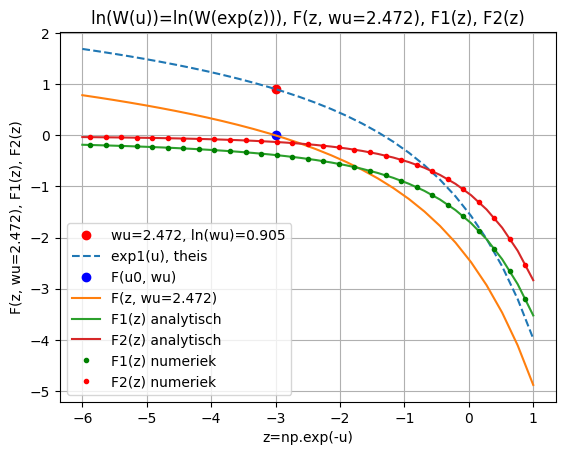

In [25]:
def F(z, wu):
    u = np.exp(z)
    return np.log(exp1(u)) - np.log(wu)

def F1(z):
    u = np.exp(z)
    return -np.exp(-u) / exp1(u)

def F2(z):
    u = np.exp(z)
    return u * np.exp(-u) / exp1(u) - np.exp(-2 * u) / exp1(u) ** 2

# The point u0, W(u0)
u0 = np.exp(-3)

z = np.linspace(-6, 1, 30)

fig, ax = plt.subplots()
ax.grid()
ax.set_title(f'ln(W(u))=ln(W(exp(z))), F(z, wu={exp1(u0):.4g}), F1(z), F2(z)')
ax.set_xlabel('z=np.exp(-u)')
ax.set_ylabel(f'F(z, wu={exp1(u0):.4g}), F1(z), F2(z)')

# The point
ax.plot(np.log(u0), np.log(exp1(u0)), 'ro', label=f"wu={exp1(u0):.4g}, ln(wu)={np.log(exp1(u0)):.4g}")
# exp1(u)
ax.plot(z, np.log(exp1(np.exp(z))), '--', label="exp1(u), theis")
# F(z, wu)
ax.plot(np.log(u0), F(np.log(u0), exp1(u0)), 'bo', label="F(u0, wu)")
# The point now zero
ax.plot(z, F(z, exp1(u0)), label=f"F(z, wu={exp1(u0):.4g})")
# F1(z)
ax.plot(z, F1(z), label="F1(z) analytisch")
# F2(z)
ax.plot(z, F2(z), label="F2(z) analytisch")
# F1 numerically computed from F
FF1 = (F(z[ 1:], exp1(u0)) - F( z[:-1], exp1(u0))) / np.diff(z)
# F2 numerically computed from F1
FF2 = (F1(z[1:])           - F1(z[:-1]))           / np.diff(z)

zm = 0.5 * (z[:-1] + z[1:])
# F1 numerically
ax.plot(zm, FF1, 'g.', label="F1(z) numeriek")
#F2 numerically
ax.plot(zm, FF2, 'r.', label="F2(z) numeriek")

ax.legend()   

## Implentatie van de inverse van de well-function van Theis (exp1(u) <-> exp1_inv(W))

Met het voorgaande kan een functie worden gedefinieerd die de inverse is van de well function van Theis, die we hier exp_inv(..) noemen met als argument de waarde van W($u$) en als uitkomst die van $u$.

Tegelijk wordt de uitkomst gecontroleerd door $u$ weer in de functie exp1(..) in te vullen.

In [26]:
def exp1_inv(W, Halley=False, verbose=False):
    """Return inverse of function scipy.special.exp1 (Theis well function) computed using Newton's method.
    
    Parameters
    ----------
    A: float
        The W(u) or exp1(u) value for  which u values is desired.        
    """
    
    def F(z, W):
        """Return funcion value to be zeroed.
        
        Parameters
        ----------
        z: float
            z = ln(u)
        W: float
            W = W(u), given, u is to be determined
        """
        u = np.exp(z)
        return np.log(exp1(u)) - np.log(W)
    
    def F1(z):
        """Return derivative of F(z, A).
        
        Parameters
        ----------
        z: float
            z = ln(u)
        """
        u = np.exp(z)
        return -1 / exp1(u) * np.exp(-u)
    
    def F2(z):
        """Return second derivative of F(z, W)"""
        u = np.exp(z)
        return u * np.exp(-u) / exp1(u) - np.exp(-2 * u) / exp1(u) ** 2
    
    assert isinstance(W, float) and W > 1e-5, "A must be positive float larger than 1e-6"
    if Halley:
        assert W <=20., "If Halley, A must be < 20."
        if verbose:
            print("Halley point seeking applied.")
    elif verbose:
        print("Newton's point seekind applied")
    
    u = 1.0 # Initial value
    z = np.log(u)
    while True:
        dz = F(z, W) / F1(z)
        if Halley:
            dz = dz / (1 - dz * F2(z) / (2 * F1(z)))        
        if verbose:
            print(z, dz)
        z -= dz
        if abs(dz) < 1e-12 or np.isnan(z):
            break
    return np.exp(z)

# Controleren van het resultaat, krijgen we de A terug als we de met A gevonden u invullen?
Ws = np.logspace(-5, 2, 8) * 2.
for W in Ws:
    #u = exp1_inv(W, Halley=True, verbose=True)
    #u = exp1_inv(W, Halley=False, verbose=True)
    u = exp1_inv(W, Halley=False, verbose=False)
    #u = exp1_inv(W, Halley=True, verbose=False)
    print(f"W was {W:8.4g} --> W = {exp1(u):8.4g} --> u={u:8.4g}")


W was    2e-05 --> W =    2e-05 --> u=    8.57
W was   0.0002 --> W =   0.0002 --> u=   6.515
W was    0.002 --> W =    0.002 --> u=    4.53
W was     0.02 --> W =     0.02 --> u=   2.668
W was      0.2 --> W =      0.2 --> u=   1.056
W was        2 --> W =        2 --> u= 0.08237
W was       20 --> W =       20 --> u=1.157e-09
W was      200 --> W =      200 --> u=7.77e-88


### Toepassing vergelijking van de eenvoudige en de meer complexe berekening van de invloedsstraal

Hieronder wordt de invloedsstraal berekend met de eenvoudige methode $r=\sqrt{\frac{2.25 kD t}{S}}$ an met de exacte verlaging $s=0.05$ m, waarvoor de boven geïmplementeerde funtie exp1_inf(s=0.005) wordt gebruikt. Het verschil blijkt voor de praktijk verwaarloosbaar te zijn.

In [27]:
# Parameters
kD, S, Q = 600., 0.2, 788.
s = 0.05 # m
t = 10.

# De waarde van W(u) voor de opgegeven kleine verlaging s=0.05 m
wu = 4 * np.pi * kD * s / Q

# De waarde van u voor deze W(u)u
u = exp1_inv(wu)

# Radius of influence
r05 = np.sqrt(4 * u * kD * t / S) # exact 5 cm verlaging
r =   np.sqrt(2.25  * kD * t / S) # Benadering

# Resultaat
print(f"r is de invloedsstraal volgens de afgeleide eenvoudige formule, r05 is de invloedsstraal voor s={s:.3g} m:")
print(f"kD={kD}, S={S}, Q={Q}, s={s}, t={t}, wu={wu:.4g}, u={u:.4g}")
print("\nUitkomsten:")
print(f"Eenvoudige methode r  ={r:.4g} m")
print(f"Exacte methode     r05={r05:.4g} m\n")

r is de invloedsstraal volgens de afgeleide eenvoudige formule, r05 is de invloedsstraal voor s=0.05 m:
kD=600.0, S=0.2, Q=788.0, s=0.05, t=10.0, wu=0.4784, u=0.5746

Uitkomsten:
Eenvoudige methode r  =259.8 m
Exacte methode     r05=262.6 m



# Berekening van de verlaging, ten gevolge van een willekeurig in de tijd verlopende onttrekking, met convolutie

Convolutie is een algemene method waarmee het dynamische verloop van dde grondwaterstand of verlaging kan worden berekend die volgt uit een in de tijd variërende onttrekking of andere stress zoals neerslagoverschot. Convolutie is in feite een slimme manier van superpositie, waarmee in eenslag een hele tijdreeks kan worden berekend.

De stanaard oplossingen voor het niet-stationaire verloop van de verlaging door een stationaire onttrekking zijn op te vatten als stapresponses wanneer de onttrekking gelijk aan 1 wordt genomen. Bijvoorbeeld de verlaging volgens Theis. De staprespons volgens theis is dan

$$SR = \frac{1}{4 \pi kD} W_t(u) = \frac 1 {4 \pi kD}\intop_u^\infty \frac{e^{-y}}{y} dy,\,\,\,u=\frac{r^2 S}{4 kD t}$$

Hieruit volgt de zogenoemde impulsrespons door differentiatie

$$ IR = \frac{\partial}{\partial t} SR = \frac Q {4 \pi kD} \frac{e^{-u}}{t}$$

De impulsrespons heeft een groot theoretisch belang, maar is voor ons niet nodig. Belangrijker in de praktijk is de staprespons die het gevolg is van een continue onttrekking van 1 m3/d vanaf t=0 en de daaruit afgeleide blokrespons die de reactie is van de grondwaterstand op een plotseling onttrekking van 1 m3/d gedurende exact 1 tijdstap (meestal een dag)

$$ BR = \frac Q {4 \pi kD} \left[ W_t\left({u_t}\right) - W_t\left({u_{t-dt}}\right)\right] $$

De berekening van de verlaging door een willekeurig verlopend debiet geschiedt het gemakkelijkst met de functie `lfilter(...)` uit de module`scipy.signal`.

$$s(r,t) =  \frac{1}{4 \pi kD} \sum_{i=0}^\infty Q(t - \tau_i) BR(\tau_i)
=lfilter \left(BR(\tau, 1, Q(t-\tau)) \right)$$

Het werken met de blokrespons is doorgaans het meest effectief. Het is hetzelfde als convolutie.

In het voorbeeld hieronder wordt de verlaging volgens Theis gegeven als formule (lijn) en zoals berekend met convolutie met de blokrespons (puntjes) Het blijkt dat de berekening met convolutie, gebruik makend van de blokrespons hetlzelfde resultaat geeft als de analytische oplossing van Theis. Dit moet natuurlijk ook zo zijn. We kunnen hiermee dus ook de verlaging volgens Theis berekenen bij een willekeurig in de tijd verlopende onttrekking.

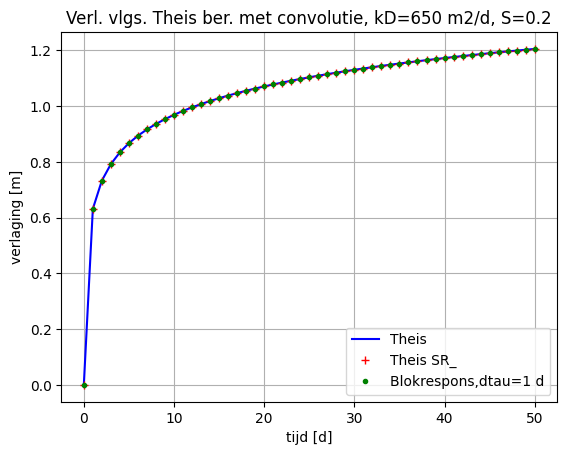

In [28]:
kD, S, Q0 = 650, 0.2, 1200

# Piezometer
r = 10

# Tijd
tauEnd, dtau = 50., 1
tau = np.arange(0, tauEnd + dtau, dtau)

# Berekening verlaging Theis met convolutie
SR = SRtheis(kD, S, r, tau)
BR = BRtheis(kD, S, r, tau)

Q = Q0 * np.ones_like(tau)

sBR = lfilter(BR, 1, Q)  # Convolutie

# Theis jgebruik makend van de formule (= SR, staprespons)
sTh = Q  * SR

title = f"Verl. vlgs. Theis ber. met convolutie, kD={kD:.0f} m2/d, S={S:.3g}"
ax = newfig(title, "tijd [d]", "verlaging [m]")

clrs = cycle('brgmck')
ax.plot(tau, sTh, color=next(clrs), label='Theis')
ax.plot(tau, sTh, '+', color=next(clrs), label='Theis SR_')
ax.plot(tau, sBR, '.', color=next(clrs), label=f'Blokrespons,dtau={dtau:.3g} d')
ax.legend()

## Convolutie met de impulsrespons in plaats van de blokrespons

We kunnen de convolutie ook uitvoeren met de impulsrespons. Dit is de afgeleide van de staprespons en is de reactie van het grondwatersysteem op een pulsvorminge onttrekking. Dat wil zeggen een onttrekking der lengte $dt\rightarrow0$ ter grootte van een eenheid, dus een onttrekking van 1 m3 gedurende een tijdstap $dt$ die infinitesimaal klein is.

$$ s(t) = \intop_{\tau=0}^\infty Q(t - \tau)\frac{\partial SR}{\partial \tau} d\tau
\approx\sum_{i=0}^\infty Q(t-i \Delta \tau)\frac{\partial SR}{\partial \tau}\Delta \tau$$

Waarbij de rechter uittdrukking de numerieke convolutie voorstelt met discrete tijdstappen van $\Delta \tau$, veelal van 1 dag.

Het probleem hiermee is dat de impuls respons zo snel verandert binnen het tijdsbestek van 1 dag, dat de berekening onnauwkeurig wordt en de uitkomst ver kan afwijken van wat hij moet zijn. We kunnen de uitkomst wel goed krijgen, maar dan moeten we de tijdstap veel korter kiezen dan 1 dag. Dit effect wordt hieronder gedemonsteerd, waar we de verlaging volgens Theis opnieuw berekekene, maar nu met zowel de blokrespons als de impulsrepons. Voor grote tijdstappen blijkt de impulsrespons veel te kleine waarden op te leveren; pas bij tijdstappen kleinder dan 0.03d komen beide berekeningen goed met elkaar overeen.

In de praktijk gebruiken we altijd de blokrespons, want die is exact en niet afhankelijk van de grootte van de tijdstap.

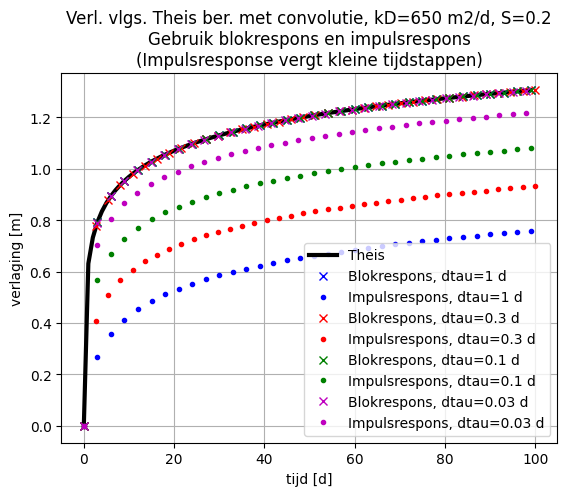

In [29]:
title = f"Verl. vlgs. Theis ber. met convolutie, kD={kD:.0f} m2/d, S={S:.3g}\nGebruik blokrespons en impulsrespons\n(Impulsresponse vergt kleine tijdstappen)"
ax = newfig(title, "tijd [d]", "verlaging [m]")
dtaus = np.array([1, 0.3, 0.1, 0.03])
tmin, tmax = 0, 100

t= np.arange(tmin, tmax, 1.0)
sTheis = np.hstack((0, Q0 /(4 * np.pi * kD) * exp1( r ** 2 * S  / (4 * kD * t[1:]))))
ax.plot(t, sTheis, lw=3, color='black', label='Theis')

clrs = cycle('brgmck')
for dtau in dtaus:
    clr = next(clrs)
    tau = np.arange(tmin, tmax, dtau)    
    Q = Q0 * np.ones_like(tau)
    
    n = 3 * int(1 / dtau)
    
    SR = SRtheis(kD, S, r, tau)
    ax.plot(tau[::n], Q0 * SR[::n], 'x', color=clr, lw=0.25, label=f'Blokrespons, dtau={dtau:.3g} d')
    
    # Gebruik de impulsrespons: Werkt alleen voor voldoend kleine stapgrootte.
    IR = IRtheis(kD, S, r, tau)    
    sIR = lfilter(IR, 1, Q)

    ax.plot(tau[::n], sIR[::n], '.', color=clr, label=f'Impulsrespons, dtau={dtau:.3g} d')

ax.legend()
plt.show()

We kunnen nu, door convolutie met de blokrespons, nauwkeurig de verlaging bij elk willekeurig verloop van de onttrekking uittrekenen.

### Enkele voorbeelden van convolutie met niet constante onttrekking

1. Willekeurig verloop van de onttrekking
2. Onttrekking neemt lineair af in de tijd, waarbij de onttrekking gehalveerd wordt over een tijdvak T
3. Onttrekking neemt exponentiaal af in de tijd, waarbij de onttrekking halveeft over een tijdvak T

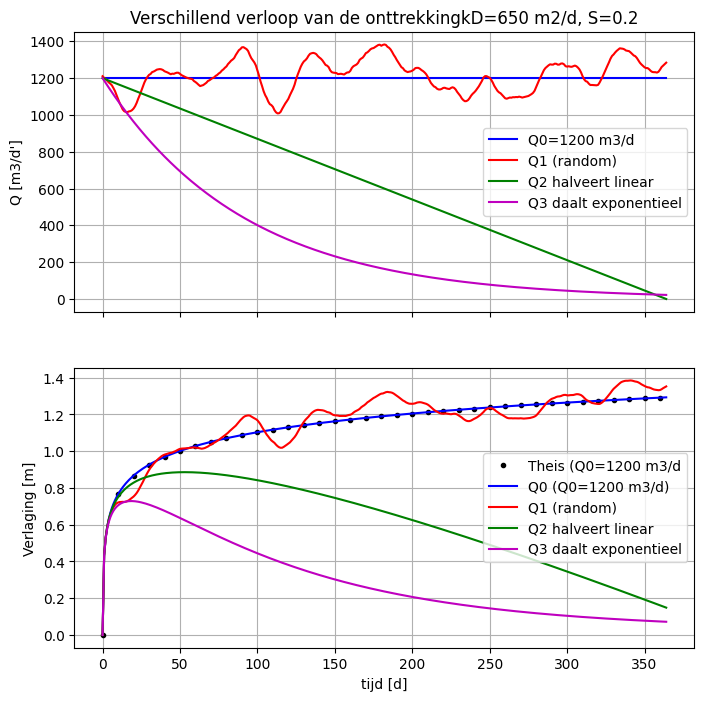

In [30]:
kD, S, Q0 = 650, 0.2, 1200

r = 20 # Piezometer

dtau = 1.0
tauEnd = 365
tau = np.arange(0, tauEnd, dtau)
T = tauEnd / 4
Q  = np.ones_like(tau) * Q0

# Random Q
Q1= Q0 * (np.random.rand(len(tau)) + 0.5)

# Voortschrijdend gemiddelde over 4% van de tijdstappen om een meer vloeiende curve te krijgen
B = np.ones(int(tauEnd / 25))

# Normaliseer, zodat de gemiddelde Q0 behouden blijft
B /= len(B)

# Vlak het random verloop van de onttrekking uit door
# voortschrijdend gemiddelde naar links en naar rechts te nemen
Q1 = filtfilt(B, 1, Q1, method='gust', irlen=len(B))

# Lineair in de tijd afnemend debiet
Q2 = np.interp(tau, np.array([0., tau[-1]]), np.array([Q0, 0]))

# In de tijd exponentieel afnemend debiet
Q3 = Q0 * np.exp(- tau / T)

u = r ** 2 * S  / (4 * kD * tau[1:])
SR = SRtheis(kD, S, r, tau)
BR = BRtheis(kD, S, r, tau)

sT = Q0 * SR
s0 = lfilter(BR, 1.0, Q)  # Constante onttrekking
s1 = lfilter(BR, 1.0, Q1) # Uitgevlakt willekeurig verlopende onttrekking
s2 = lfilter(BR, 1.0, Q2) # Lineair in de tijd afnemende onttrekking
s3 = lfilter(BR, 1.0, Q3) # Exponentieel in de tijd afnemende onttrekking

# Plots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].set_title(f"Verschillend verloop van de onttrekkingkD={kD:.0f} m2/d, S={S:.3g}")
axs[0].set_ylabel("Q [m3/d']")
axs[1].set_ylabel("Verlaging [m]")
axs[1].set_xlabel("tijd [d]")
axs[0].grid()
axs[1].grid()

clrs = cycle('brgmck')

axs[0].plot(tau,  Q, color=next(clrs), label='Q0={:.0f} m3/d'.format(Q0))
axs[0].plot(tau, Q1, color=next(clrs), label='Q1 (random)')
axs[0].plot(tau, Q2, color=next(clrs), label='Q2 halveert linear')
axs[0].plot(tau, Q3, color=next(clrs), label='Q3 daalt exponentieel')

clrs = cycle('brgmck')

axs[1].plot(tau[::10], sT[::10], 'k.', label='Theis (Q0={} m3/d'.format(Q0))
axs[1].plot(tau, s0, color=next(clrs), label='Q0 (Q0={:.0f} m3/d)'.format(Q0))
axs[1].plot(tau, s1, color=next(clrs), label='Q1 (random)')
axs[1].plot(tau, s2, color=next(clrs), label='Q2 halveert linear')
axs[1].plot(tau, s3, color=next(clrs), label='Q3 daalt exponentieel')

axs[0].legend()
axs[1].legend()

# Onvolkomen putten

Een onvolkomen put veroorzaakt op kortere afstanden van de put een afwijking van de verlaging ten opzichte van de situatie met een put met zijn filter over de gehele dikte van de watervoerende laag. Onvolkomen filters zijn echter de gangbare situatie, met name in dikkere pakketten.

We kunnen de invloed van de onvokomenheid van het putfilter verwerken met een correctie van Hantush. Deze correctie kan gewoon worden meegenomen in de analytische oplossing.

Overigens is het effect van de onvolkomenheid van het filter uitgewerkt op afstanden groter dan circa anderhalve pakketdikte en daarmee in de regel niet van belang voor de vergunningverlening.

### Nog uitwerken (kan eenvoudig met formule hiervoor van Hantush (1956?) of eventueel van Huisman (1970)).

# Bouwputten (schematisch cirkelvormig)

## Homogene verlaging binnen bij uniforme onttrekking langs de omtrek (Dupuit)

We gaan uit van de meest eenvoudige formule voor de verlaging, namelijk Dupuit. De onttrekking langs het scherm met radius $\rho$ is gelijk aan $dq = \frac{Q_0}{2 \pi \rho} \rho d\theta = \frac{Q_0}{2 \pi}d\theta$. De verlaging hierdoor in een willekeurig punt in de bouwput, gegeven door coordinaten $x_p=a\rho$, $y_p=0$, met $0 \le a \le 1$, waarbij het centrum van de bouwput coordinaten $0, 0$ heeft. De radius waarvoor de verlaging gelijk is aan nul is veel groter dan die van de boutput en is gelijk aan $R$.

De afstand $r$ tussen het punt op de omtrek van de bouwput en het beschouwde punt is gelijk aan

$$r = \rho\sqrt{\sin^2\theta + (\cos\theta)^2 - a}=\rho\sqrt{1+a^2-2a\cos\theta}$$

De verlaging $ds$ door onttrekking van het stukje scherm gegeven door $d\theta$ is gelijk aan

$$s = \frac {1}{2 \pi}\frac{Q_0}{2 \pi kD}\intop_0^{2 \pi}\ln[\frac \rho R \sqrt{1 + a^2 - 2 a \cos\theta}] d \theta$$

$$s = \frac{Q_0}{2 \pi kD}\ln \frac r R + \frac {1}{2 \pi}\frac{Q_0}{2 \pi kD}\intop_0^{2 \pi}\ln[\sqrt{1 + a^2 - 2 a \cos\theta}] d \theta$$

De tweede term is lastig analytisch te integreren, maar bij numerieke integratie blijkt deze altijd gelijk aan nul te zijn. Met andere woorden, de verlaging binnen een cirkelvormige bouwput die unirfoem vanaf de rand wordt bemalen is altijd uniform en gelijk aan de verlagin op de rand van de bouwput veroorzaakt door een onttrekking in het centrum ervan.

Hieronder laten we zien dat de integraal nul is en daarmee ook de tweede term.

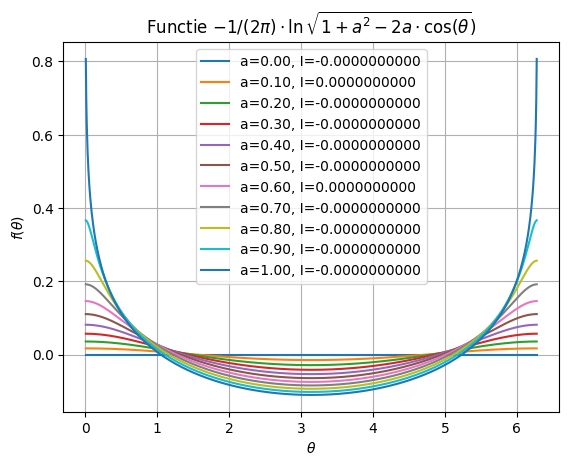

In [31]:
kD, rho, R, a, Q0 = 600., 50., 500., 0.5, 1200.

def F(theta , a):
    """Return the function to be integrated"""
    return - 1 / (2 * np.pi) * np.log( np.sqrt(1 + a ** 2 - 2 * a * np.cos(theta)))

# Show the graph for different 0 <= a <= 1 and the value of the numerical integration
ax = newfig(r"Functie $-1 / (2 \pi) \cdot \ln \sqrt{1 + a^2 - 2 a \cdot \cos ( \theta })$", r"$\theta$", r"$f(\theta)$")

theta = np.linspace(0, 2 * np.pi, 1000)[1:-1]

for a in np.linspace(0, 1, 11):
    integral = quad(F, 0, 2 *  np.pi, (a))[0]
    ax.plot(theta, F(theta, a), label=f'a={a:.2f}, I={integral:12.10f}')
ax.legend()
plt.show()

## Ook homogene verlaging bij lek (De Glee), indien $\lambda >> R$
Dus ook in de situatie met lek, De Glee, is dit het geval zolang de radius van de bouwput $\rho << \lambda=\sqrt{kD c}$, de spreidingslengte van de semi-gespannen aquifer. Immers dan geldt

$$s \approx \frac{Q}{2 \pi kD} \ln \frac{1.123 \lambda}{\rho} = \frac{Q}{2 \pi kD}\ln \frac{R}{\rho},\,\,\,\,\,met\,\,\,\,R=1.123 \lambda$$

In de niet-stationaire situatie volgens Theis, voldoen de stijghoogteverschillen als functie van de afstand aan die van de formule van Dupuit. Dit impliceert dat, na voldoende tijd, dat wil zeggen wanner de invloedsstraal ruim groter is dan de straal van de bouwput, ook dan geldt dat de verlaging binnen de cirkelvormige bouwput exact vlak. Deze verlaging is dan bovendien gelijk aan de verlaging op de rand  van een bouwput door een even grote ontrekking in het centrum van de bouwput. Kort na de start van de bemaling is nog niet het geval.

Het voorbeeld hieronder demonstreert dit.

De conclusie is tweeledig.

1. De verlaging binnen en cirkelvormige bouwput is overal gelijk bij een schermonttrekking langs de omtrek. En dus bijna overal gelijk bij onttrekking middels een aantal putten verdeeld langs de omtrek.
2. De verlaging binnen de bouwput bij onttrekking langs de omtrek is gelijk aan de verlaging op de omtrek bij onttrekking met een put met hetzelfde totale debiet in het centrum van de bouwput.
3. Dit laatste is exact het geval in de stationaire situatie, doch de fount in de niet stationaire situatie is al snel gering, in feite te verwaarlozen wanneer de tijd voortschrijdt. 

## Idem na enige tijd bij niet-stationarie verlaging (Theis en Hantush)
Hierna wordt aangetoond dat de verlaging binnen de bouwput (na enige tijd) vlak is en gelijk aan de verlaging op de rand van de bouwput door een put in het centrum van de bouwput met hetzelfde totale debiet.

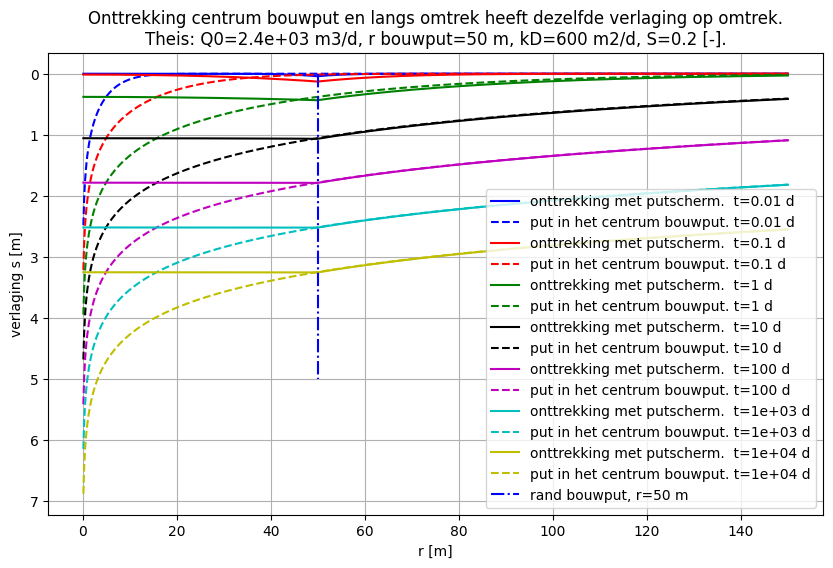

In [32]:
kD, S, rho, Q0 = 600., 0.2, 50., 2400.

N = 1000 # number of wells along the screen
dtheta = 2 * np.pi / N
theta = np.linspace(0, 2 * np.pi, N + 1) + dtheta / 2
Xw, Yw = rho * np.cos(theta), rho * np.sin(theta)
x0, y0 = 0., 0.
X = np.hstack((np.linspace(x0, x0 + rho, 300)[1:-1], np.linspace(x0 + rho, 3 * rho, 300)[1:]))
Y = np.ones_like(X) * y0

clrs = cycle('brgkmcy')

ax = newfig(("Onttrekking centrum bouwput en langs omtrek heeft dezelfde verlaging op omtrek.\n" +
             f"Theis: Q0={Q0:.3g} m3/d, r bouwput={rho:.3g} m, kD={kD:.3g} m2/d, S={S:.3g} [-]."),
            "r [m]", "verlaging s [m]", figsize=(10,6 ))
ax.invert_yaxis()

ts = [0.01, 0.1, 1., 10., 100., 1000., 10000.]
for t in ts:
    clr = next(clrs)
    
    # Verlaging door het onttrekkingsscherm
    s = np.zeros_like(X)
    for xw, yw in zip(Xw, Yw):
        r = np.sqrt((xw - X) ** 2 + (yw - Y) ** 2)
        u = r ** 2 * S  /(4 * kD * t)
        s += (Q0/ N) / (4 * np.pi * kD) * exp1(u)

    ax.plot(X, s, color=clr, label=f"onttrekking met putscherm.  t={t:.3g} d")
    
    # Verlaging onttrekking in centrum bouwput
    r = np.sqrt((x0 - X) ** 2 + (y0 - Y) ** 2)
    u =  r ** 2 * S  / (4 * kD * t)
    s2 = Q0 / (4 * np.pi * kD) * exp1(u)
    ax.plot(X, s2, color=clr, ls='dashed', label=f"put in het centrum bouwput. t={t:.3g} d")
ax.vlines(x0 + rho, 0, 5, colors='b', linestyles=['-.'], label=f'rand bouwput, r={rho:.3g} m')
ax.legend()


## Put in het centrum van de bouwput vs schermonttrekking langs de omtrek

Hiervoor is aangetoond dat het voor de uiteindelijke de verlaging op de rand van de bouwput niet uitmaakt of de onttrekking nu plaats vindt met een enkele put in het centrum van de bouwput of met uniform langs de omtrek. Binnen de bouwput is dat anders, maar voor de situatie erbuiten maakt het niet uit. Bij tijdsafhankelijke verlaging is er aanvankelijk wel enig verschil omdat, zoals blijkt uit de veel grotere verlaging binnen de bouwput, dat bij onttrekking met een enkele put meer water moet worden verwijderd dan bj het scherm om op de rand dezelfde verlaging te krijgen, maar na verloop van tijd verdwijnt het verschil.

## Individuele putten op de rand van de bouwput in plaats van een onttrekkingsscherm

Wanneer het scherm geen onttrekkingsscherm is, maar de bemaling wordt gedaan met een aantal putten op een circle rond het hard van de bouwput dan geldt

$$s = \frac{Q_0}{ 2\pi kD} \ln \frac R r$$

N bij N putten alle op de cirkel met straal $R$ geldt voor het punt in het midden van de cikel

$$s(r=0) = \frac{Q_0}{ 2\pi kD} \ln \frac R r = \frac{\sum_{i=1}^NQ_i}{2 \pi kD} \ln \frac R r$$

Dus bij bemaling met N putten langs de omtrek van een cikelvormige bouput is de verlaging in het centrum van deze cirkel gelijk aan die op afstand $R$ veroorzaakt door het pompen in het centrum van de cirkel met een debiet gelijk aan de som van de debieten van de bronnen op de cirkel. Het maak niet uit waar de putten op de cirkel staan en hoe groot hun onderlinge debieten zijn.

Het voorbeeld hierna geeft de verlaging op langs rand van de cirkelvorminge bouwput bij onttrekking met een (willekeurig) aantal putten, dti voor verschillende momenten in de tijd. Alleen wanneer de onttrekking uniform wordt verdeeld over de gehele cirkel valt de verlaging door de scheronttrekking op de cirkel samen met die door een enkele put in het centrum van de bouwput. In het voorbeeld kan het aantal putten worden gekozen waarover de totale ontterkking wordt verdeeld over de rand van de boutput.

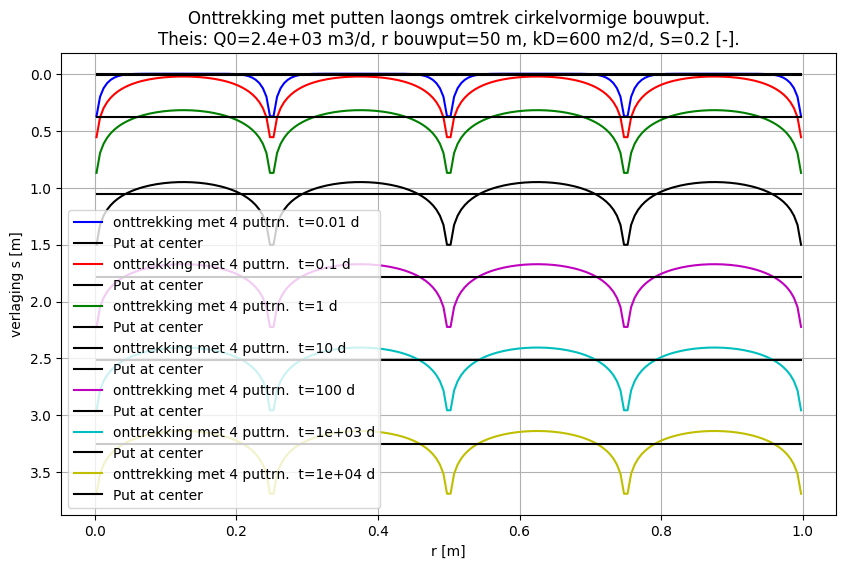

In [33]:
kD, S, rho, Q0 = 600., 0.2, 50., 2400.

Nw = 4 # number of wells along the screen
Np = Nw * 200 / Nw
thetaW = np.arange(0, 2 * np.pi, 2 * np.pi / Nw)
thetaP = np.arange(0, 2 * np.pi, 2 * np.pi / Np) + np.pi / Np

x0, y0 = 0., 0.
Xw = x0 + rho * np.cos(thetaW)
Yw = y0 + rho * np.sin(thetaW)
Xp = x0 + rho * np.cos(thetaP)
Yp = y0 + rho * np.sin(thetaP)

clrs = cycle('brgkmcy')

ax = newfig(("Onttrekking met putten laongs omtrek cirkelvormige bouwput.\n" +
             f"Theis: Q0={Q0:.3g} m3/d, r bouwput={rho:.3g} m, kD={kD:.3g} m2/d, S={S:.3g} [-]."),
            "r [m]", "verlaging s [m]", figsize=(10,6 ))
ax.invert_yaxis()

ts = [0.01, 0.1, 1., 10., 100., 1000., 10000.]
for t in ts:
    clr = next(clrs)
    
    # Verlaging door het onttrekkingsscherm
    s = np.zeros_like(thetaP)
    for xw, yw in zip(Xw, Yw):
        r = np.sqrt((xw - Xp) ** 2 + (yw - Yp) ** 2)
        u = r ** 2 * S  /(4 * kD * t)
        s += (Q0/ Nw) / (4 * np.pi * kD) * exp1(u)
        
    ax.plot(thetaP / (2 * np.pi), s, color=clr, label=f"onttrekking met {Nw} puttrn.  t={t:.3g} d")
    

    s2 = Q0 / (4 * np.pi * kD) * exp1(rho ** 2 * S / (4 * kD * t) * np.ones_like(thetaP))
    ax.plot(thetaP / (2 * np.pi), s2, 'k', label="Put at center")
ax.legend()

## Handhaven van de verlaging aan de rand van de bouwput (of verderop)

Bemalingen hebben als doel een verlaging overal binnen de bouwput te bereiken om zo droog te kunnen werken en bouwen. Er zal normaliter een voldoend hoog debiet worden ingezet om binnen een redelijke tijd de vereiste verlaging te behalen. Daarna zal het debiet geleidelijk worden verminderd omdat de verlaging bj gelijk debiet anders steeds verder zou oplopen. Deze geleidelijke vermindering van het debiet is dus noodzakelijk om niet nodeloos veel te pompen of teveel te verlagen.Kunnen we het verloop van het debiet gedurende de gehele duur van de bemaling berekenen?

Een bouwput bemaling kan schematisch worden opgevat als een uniforme peilverlaging die wordt verkregen door pompen binnen een een cirkel met straal $\rho$, de geschematiseerde rand van de bouwput. We kunnen ons het bemalen voorstellen als een schermvormige onttrekking met een totale omvang $Q_0$ m3/d, die gelijkmatig is verdeeld langs de cirkelvormige rand van de bouwput. Zoals eerder in dit document is aagetoond, is de verlaging binnen de bouwput dan vlak en bovendien gelijk aan de verlaging ter plaatse van de rand die zou worden veroorzaakt door bemaling met een enkele punt met hetzelfde totale debiet in het centrum van de bouwput. Voor de verdere analyse kunnen we dit als uitgangspunt nemen.

De analytische onttrekkingsformules die ons ter beschikking staan vergen alle een gegeven vast onttrekkingsdebiet, waarvan de verlaging dan het gevolg is. Uit de literatuur zijn wel analytische formules bekend die de verlaging opleggen en daarbij het in de tijd verlopende bemalingsdebiet uitrekenen, maar die zijn veel complexer dan die met opgelegd debiet. De betreffende formules zijn gegeven in de vorm van een integraal met daarin verschillende oscillerende Besselfuncties die moeilijk goed numeriek zijn te integreren.

Hieronder wordt een zeer eenvoudige procedure voorgesteld en uitgwerkt om de gewenste verlaging op geggeven afstand, de rand van de bouwput met radius $\rho$, in de tijd te handhaven. De methode is niet exact, maar wel een goede en praktische benadering.

De verlaging in de tijd in de situatie van Theis is

$$ s(r,t) = \frac{Q_0}{4 \pi kD} W(u), \,\,\,\,\, u = \frac{r^2 S}{4 kD t} $$

We kunnen dus de $Q(t)$ berekenen die de verlaging $s(\rho,t)$ de gewenste waarde geeft. Om de verlaging op de gewenste waarde te houden moet $Q$ op een bepaalde wijze in de tijd variëren. Hoe we deze Q(r,t) precies kunnen berekenen weten we niet, maar we kunnen de constante $Q$ die nodig is om de verlaging $s(\rho,t)$ te bereiken wel berekenenen voor elk tijdstip $t$. Deze in de tijd variërende $Q_0$ kunnen we als de gezochte benadering beschouwen.

Dit wordt hieronder uitgewerkt en grafisch geverifieerd. Het is de bedoeling om de verlaging op de rand van de bouwput, $r=\rho$ vast te houden na een zekere aanlooptijd $t_1$, die nodig wordt geacht om de gewenste verlaging dan voor het eerst te behalen.

Zoals hieronder blijkt, is de benaderende berekening van het bouwputdebiet (getrokken lijnen) zijn steeds iets hoger dan het benodigde debiet en meer naarmate de radius van de bouwput groter is. De Numerieke oplossing heeft over de eerste period hetzelfde debiet als de benadering, zodat de gewenste verlaging op de rand van de bouwput op hetzelfde moment wordt bereikt. Daarna schakelt de numeriek oplossing over op het vasthouden van de stijghoogte op de rand van de bouwput. De stijghoogte op de rand van de bouwput is dan verder constant, terwijl de bovenste gfafiek het daarbij verlopende debiet weergeeft. Tenslotte wordt in de benaderende methode de onttrekking uitgeschakeld en wordt in het numerieke model de stijghoogte op de bouwputrand weer losgelaten, zodat de verlaging vervolgens weer terugloopt naar nul, zonder onttrekking. De benadering voldoet voor praktische toepassingen uitstekend.

Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.


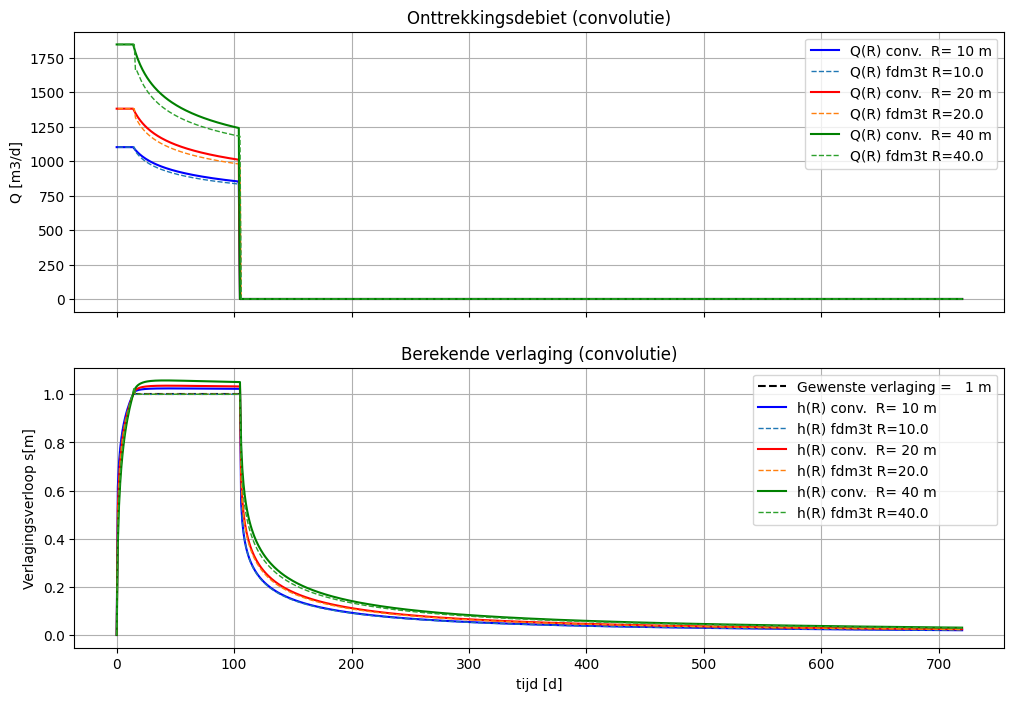

In [34]:
# Parameters aquifer
kD, S, D, hb = 600, 0.2, 20, 1.
Rs = [10, 20, 0.]

# Dag waarop de verlaging moet zijn bereikt
t1 = 14.

# Dag waarop de bemaling wordt gestaakt
t2 = t1 + 90 

times = np.linspace(0, 720., 721)
it0, it1, it2 = 0, np.sum(times <= t1), np.sum(times <= t2)

# Gewenste verlaging en afstand waarop deze moet gelden

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12, 8))
ax1.set_title("Onttrekkingsdebiet (convolutie)")
ax2.set_title("Berekende verlaging (convolutie)")
ax1.set_ylabel("Q [m3/d]")
ax2.set_ylabel("Verlagingsverloop s[m]")
ax2.set_xlabel("tijd [d]")
ax1.grid(True)
ax2.grid(True)

ax2.plot([t1, t2], [hb, hb], '--', color='black', label=f'Gewenste verlaging = {hb:3g} m')

clrs = cycle('brgmck')
for R in [10, 20, 40]:
    # Berekening van Q(r,t)
    clr = next(clrs)
    
    # Debiet om op elk moment de gewenste verlaging te bereiken met constante onttrekking vanaf t=0.
    u = R ** 2 * S / (4 * kD * times[1:]) # Skip t=0
    Q = np.zeros_like(times)
    Q[1:] = hb * (4 * np.pi * kD) / exp1(u)

    # Initiële periode, constant debiet zodat op t1 de gewenste verlaging is bereikt.
    Q[times <= t1] = Q[times <= t1][-1]

    # Periode nadat bemaling beëndigd is
    Q[times > t2] = 0.
    
    ax1.plot(times, Q, color=clr, label=f"Q(R) conv.  R={R:3g} m")

    # Convolutie: Blokrespons    
    BR = BRtheis(kD, S, R, times)

    # Exacte berekening van de verlaging bij het hierboven berekende verloop van de onttrekking.
    st = lfilter(BR, 1, Q)

    ax2.plot(times, st, color=clr, label=f"h(R) conv.  R={R:3g} m")
    
    # Numeriek
    r = np.hstack((R - 0.01, np.logspace(np.log10(R), 6, 120)))
    
    gr = Grid(r, None, (0, -D), axial=True)

    k  = gr.const(kD / D)
    ss = gr.const(S / D)
    idomain = gr.const(1, dtype=int)
    hi = gr.const(0.)

    Ifx = gr.NOD[-1:, -1:, 0:1].ravel()

    FQ = dict()
    FQ[it0] = np.zeros(len(Ifx), dtype=dtypeQ)
    FQ[it0]['I'], FQ[it0]['q'] = Ifx, Q[1]

    FQ[it1] = np.zeros(len(Ifx), dtype=dtypeQ)
    FQ[it1]['I'], FQ[it1]['q'] = Ifx, 0.

    FH = dict()
    FH[it1] = np.zeros(len(Ifx), dtype=dtypeH)
    FH[it1]['I'], FH[it1]['h'] = Ifx, hb

    FH[it2] = np.zeros(0, dtype=dtypeH)
    
    out = fdm3t(gr=gr, t=times, k=(k, k, k), ss=ss, fh=FH, fq=FQ, hi=hi, idomain=idomain,  epsilon=1.0)
    
    ax1.plot(times[1:], out['Qx'][:, -1, -1, 0], '--', lw=1,  label=f'Q(R) fdm3t R={gr.x[1]}')
    ax2.plot(times, out['Phi'][:, -1, -1, 0], '--', lw=1, label=f'h(R) fdm3t R={gr.x[1]}')
    
ax1.legend()
ax2.legend()

## Analytische oplossing voor het verloop van het debiet van een bouwput

### Directe integratie, oplossing 223.02 in Bruggeman(1999)

Bruggeman (1999) geeft een analytische oplossing (nr. 223.02) voor de stroming buiten een cylinder met straal $R$ waar het peil op $t=0$ plotseling met een constante waarde verandert.

$$ \phi(r,t)=h\left\{1 - \frac 2 \pi \int_0^\infty \frac 1 u h(u, r) \exp\left(-\frac{u^2 t}{\beta^2 R^2}\right) du \right\} $$

terwijl

$$ h(u,r) = \frac{J_0(u)Y_0(\frac r R u) - Y_0(u)J_0(\frac r R u)}{J_0^2(u) + Y_0^2(u)} $$

Voor het debiet $Q(t,t)$ geldt

$$ Q(r,t) = -2 \pi r T \frac{\partial \phi(r, t)}{\partial r}$$

r komt alleen voor in $h(u, r/R)$. Partial differentiëren van $h(u, r/R)$ naar $r$ levert:

$$\frac{\partial h(u,r)}{\partial r} = \frac u R \frac{Y_0(u)J_1(\frac{r}{R} u) - J_0(u)Y_1(\frac{r}{R}u) }{J_0^2(u) + Y_0^2(u)}=\frac u R g(u, r/R)$$

zodat

$$Q_{r=R}(t) =  -2 \pi r T \frac{\partial \phi(r, t)}{\partial t} =-2 \pi r T \,\, \left\{- \frac {2 h} {\pi R} \int_0^\infty  g(u) \exp\left(-\frac{u^2 t}{\beta^2 R^2}\right) du\right\}$$

zodat tenslotte

$$Q_{r=R}(t) = 4 T \,\, h \frac r R  \int_{u=0}^\infty g(u) \exp\left(-\frac{u^2 t}{\beta^2 R^2}\right) du$$

$$Q_{r=R}(t) = 4 T \,\, h  \frac r R \int_{u=0}^\infty u \, g(u) \, \exp\left(-\frac{u^2 t}{\beta^2 R^2}\right) dln(u)$$

een bij overstappen van integratievariable $u$ naar $z$, zodat $z = d (\ln u) = du/u$:

$$Q_{r=R}(t) = 4 T \,\, h  \int_{z=-\infty}^\infty u \, g(u) \, \exp\left(-\frac{u^2 t}{\beta^2 R^2}\right) dz, \,\,\,\,\, u = e^z$$

Deze oplossing blijkt integreerbaar. Het blijkt alleen dat de integratie over een hele breed traject moet gebeuren om een nauwkeurig resultaat te krijgen. In dit geval levert integratie over $-1-- \le z \le 4$ of in termen van u over $e^{-100} \le u \le e^{4}$ nodig te zijn om een voldoend nauwkeurig antwoord te krijgen, waarbij ook nog het integratietraject moet worden opgebroken in een uiterst traag naar nul dalend linker deel tussen $-100 \le z \le -8$  en en traject met oscillaties $-8 \le z \le 4$.


### Via Laplace domain en numerieke terugtransfomatie

De oplossing in het Laplace domain is gemakkelijk af te leiden en bovendien eenvoudig.
De Laplace transform van een expressie $f(t)$ is
$$L{f(t)} = \overline f(s) = \intop_0^\infty e^{-st} f(t) dt$$
 De partiële differentiaalverlijking is
$$ \frac{\partial^2 \phi}{\partial r^2} + \frac 1 r \frac{\partial \phi}{\partial r} = \beta^2 \frac{\partial \phi}{\partial t},\,\,\,\,\phi(0, r>R)=0, \,\,\,\,\phi(t, R)=h$$
De Laplace transform van deze differentiaalverglijking is
$$L\left\{ \frac{\partial^{2}\phi}{\partial r^{2}}\right\} +L\left\{ \frac{1}{r}\frac{\partial\phi}{\partial r}\right\} =L\left\{ \beta^{2}\frac{\partial\phi}{\partial t}\right\} ,\,\,\,\beta^{2}=\frac{S}{kD},\,\,L\left\{ \phi\left(0,r\ge R\right)\right\} =0,\,\,L\left\{ \phi\left(t,R\right)\right\} =L\left\{ h\right\} $$
of, met $\overline \phi de Laplace getransformeerde stijghoogte, gaat de partiële differentiaalvergelijking het tijd domein over in een gewone differentiaalvergelijking in het Laplace domain
$$ \frac{d^{2}\overline{\phi}}{dr^{2}}+\frac{1}{r}\frac{d\overline{\phi}}{dr}=\beta^{2}s\overline{\phi} $$
De gewone dv heeft als algemen oplossing $\overline{\phi}=AK_{0}\left(r\beta\sqrt{s}\right)+BI_{0}\left(r\beta\sqrt{s}\right)$. $B=0$, omdat de besselfunctie $I_0(r,..)$ nooit nul kan worden voor $r > \infty$. Zodat de oplossing in het Laplace domein als volgt is:
$$\overline{\phi}=AK_{0}\left(r\beta\sqrt{s}\right)$$
$A$ volgt uit de randvoorwaarde dat $\phi=h$ voor $r=R$ dus $L{\phi}=L{h}$ voor $r=R$, zodat $L{\phi}=\overline \phi = \frac h s$ voor $r=R$. Dit levert:
$$ \frac{h}{s}=AK_{0}\left(R\beta\sqrt{s}\right)\,\,\rightarrow A=\frac{h}{s}\frac{1}{K_{0}\left(R\beta\sqrt{s}\right)} $$
en, tenslotte, de gezochte Laplace getranformeerde stijghoogte $\overline \phi$:
$$ \overline{\phi}=\frac{h}{s}\frac{K_{0}\left(r\beta\sqrt{s}\right)}{K_{0}\left(R\beta\sqrt{s}\right)}$$

Het debiet over een ring met straal r is gelijk aan
$$Q\left(r,t\right)=-2\pi rkD\frac{\partial\phi}{\partial r}$$
De Laplace transform hiervan is
$$L\left\{ Q\left(r,t\right)\right\} =L\left\{ -2\pi rkD\frac{\partial\phi}{\partial r}\right\} $$
zodat
$$\overline{Q}\left(r,s\right)=2\pi rkD\beta\sqrt{s}\frac{h}{s}\frac{K_{1}\left(r\beta\sqrt{s}\right)}{K_{0}\left(R\beta\sqrt{s}\right)},\,\,\beta=\sqrt{\frac{S}{kD}}$$
en, tenslotte
$$\overline{Q}\left(r,s\right)=2\pi r\sqrt{kDS}\frac{h}{\sqrt{s}}\frac{K_{1}\left(r\beta\sqrt{s}\right)}{K_{0}\left(R\beta\sqrt{s}\right)}$$

Deze $\overline Q$ kan numeriek terug worden getransformeerd naar het tijdsdomein.

Dit kan bijvoorbeeld met de methode DeHoog, Knight en Stokes.




De onderstaande grafiek laat de resultaten zien van een onderzoek naar de oplossing. Hierbij zijn de stijghoogte en het debiet berekend met een aantal verschillende methoden: Modflow6, eigen eindig differentie model fdm3t, Mark Bakker's ttim, numerieke terugtransformatie van de Laplace transform van de stijghoogte en het debiet, met directe integratie zoals hiervoor beschreven en met de hiervoor uitgelegde benaderende methode die gebruikt maakt van convolutie.

Ht blijkt dat de uitkomsten goed met elkaar overeenkomen, vooral voor wat grotere tijden, maar dat de gebruikt numerieke terugtransformatie van de Laplace getransformeerde niet werkt voor de stijghoogte; voor het debiet werkt de de voor de terugtransformatie gebruikte Graver-Stehfast methode wel, behoudens een "hik" voor kleine tijden. De benaderende methode voor het debiet blijkt prima te werken en is robuust, evenals uiteraard de 2 numerieke methoden en ttim.

De afstanden die in de legenda worden genoemd zijn geen ronde getallen, want het zijn keuzen uit afstanden in het numerieke netwerk, waarin deze exponentieel toenemen to 100 km.

![Brug223_02_nt140_gr1-1-160_eps60perc.png](Brug223_02_nt140_gr1-1-160_eps60perc.png)


# Ruimtelijke verlaging bij ruimtelijk variabele drainageweerstand of afwateringspatroonm

De analytische methoden die hiervoor zijn behandeld, zijn niet geschikt in situaties die niet ofwel ééndimensionaal zijn ofwel axiaal symmetrisch. Dit beperkt de toepassing in de praktijk, waardoor we in bepaalde situaties of wellicht veelvuldig op andere rekenmethoden aangewezen zijn, zoals eindige elementemethode, eindige differentiemethode of analytische elementenmethode. De analytische elementenmethode knipt de randvoorwaarden op in elementen zoals putten, lijnbronnen, lijnweerstanden en ruimtelijke elementen waarvan individuele analytische oplossingen bestaan, die in het analytische elementenprogramma worden gesuperponeerd. Het voorbereiden van de invoer voor een analytische elementenprogramma is in de regel beduidend minder omslachtig dan die van een numeriek model. En er zijn nog enkele verschillen en beperkingen. Een nadeel kan zijn dat een analytisch elementemodel al snel heel traag kan worden naarmate het aantal elementen toeneemt. Deze traagheid zit hem niet in het vinden van de oplossing, maar in het berekenen van de punten die nodig zijn om grafieken of contourkaarten te maken.

De software waarmee een eindige elementemodel kan worden opgezet, doorgerekend en gepresenteerd, is dun gezaaid. Echter het programma TTIM (auteur Prof. Dr.Ir. M Bakker TuDelft) is gfatis beschikbaar en het kan niet stationaire situaties doorrekenen voor grondwatersystemen die uit meerdere lagen bestaan. Het bevat echter geen elementen waarmee in delen van het gebied een afwijkende weerstand kan worden aangebracht tegen verticale stroming. Om toch gebieden met een ruimtellijk variërende topweerstand te analyseren, moet in TTIM als surrogaat gebruik worden gemaakt van lijnelementen, sloten of kanalen als het ware met een bodemweerstand en een op te geven breedte. Deze techniek wordt hieronder toegepast.

## TTIM, meerlagen, niet-staionair analytisch elementenmodel

TTIM is een open source API voor het analytische modelleren van grondwaterstroming in meerdere lagen. Uitgangspunt is een initiële situaite met de stijghoogten overal gelijk aan nul, die zich aanpast onder invloed van stresses die met analytische elementen worden opgelegd. Zulke analytische elementen zijn putten, "line sinks", "line doublets" en een "circular area sink", een cirkelvorming element met opgelegd neerslagoverschot (voeding). De line sinks kunnen aan elkaar worden geregen tot complexe sloot- beek en rivierconfiguraties of lijnonttrekkingen, met gegeven onttrekking per lengteeenheid of met geegven stijghoogte die al dan niet via een weerstand het grondwater in de aquifers beïnvloedt. De line doublets  kunnen worden gebruikt om weerstand tegen horizontale stroming aan te brengen, zoals damwanden en gesloten randen, waarbij het grondwater aan een zijde van de dipool al dan niet via een weerstand communiceert met die aan de andere zijde. Lek tussen aquifers is automatisch besloten in de oplossing omdat het meerlagensysteem tussen elk van de lagen een weerstand krijgt opgelegd.

Voor de specifieke onttreking $\sigma_i$ [L^3/T/L] = [L^2/T] uit ene line-sink in laag $i$ geldt

$$ \sigma_i = w(h_i - h_{ls}) / c$$

met $w$ [L] de breedte van de line-sink, en $c$ [T] de weerstand ervan.

De stroming door (loodrecht op) een doublet is
$$ q_n = (h^- - h^+) / c $$

Voor putten geldt dat de onttrekking uit laag $i$, $Q_i$ gelijk is aan

$$ Q_i = 2 \pi r_w H_i(h_i - h_w) / c $$

met $r_w$ de radius van de put, $c$ de intredeweerstand van de put, $h_w$ de stijghoogte in de put en $h_i$ die in laag $i$ aan de buitenzijde van de put.

Het element van type `Well` heeft een opgelegd debiet die van type `HeadWell` een opgelegde stijghoogt in de put. De onttrekking per laag wordt berekend op basis van het doorlaatvermogen van de lagen en de stijghoogte ter hoogte van elke laag.

Wat moeilijker verloopt is het ruimtelijk aanpassen van het doorlaatvermogen of de berginngscoëfficiënten van de watervoerende lagen of van de weerstand tussen de lagen. Theoretisch is dit wel mogelijk, het programma MLAEM had deze mogelijkheid bijvoorbeeld 20 jaar geleden al, maar TTIM heeft dat nog niet. TTIM is mathematisch wellicht complexer dan het oudere MLAEM omdat TTIM direct analytische meerlagensystemen implementeert, terwijl MLAEM deze systemen element per element opbouwt, en daarmee veel complexer is wat betreft de invoer.

De mogelijkheden van ttim zijn dus enigszins beperkt. Tegelijkertijd is het een zeer krachtig greedschap voor veel situaties.

### TTIM omgaan met gebiedsweerstand of slotenpatroon

Het beken- en slotenpatroon in een gebied is een uiting van het grondwatersysteem. Een hooggelegen gebied is normaliter een infiltratiegebied met weinig open waterlopen. Het omgekeerde geldt voor en relatie laag gelegen gebied, dat normaliter wordt gekenmerkt door kwel met veel drainagemiddelen. En dan zijn er overgangsgebieden die tussen beide in liggen. Een hoog gelegen gebied heeft hierdoor een hoge drainageweerstand en een laag gelegen gebied een kleine, terwijl die in een overgangsgebied ruimtelijk verloopt. De drainageweerstand is de gemiddlde grondwaterstand $h$ [L] ten opzichte van het peil in het oppervlaktwater $h_{ow}$ gedeeld door de gemiddelde grondwateraanvulling $N$ [L/T]

$$ c_{dr} = \frac {\overline h - h_{ow}} N $$

of

$$ N = \frac{ \overline h - h_{ow}} {c_{dr}} $$

De drainageweerstand kan uitgedrukt worden in slootbreedte $w$, de slootafstand $L$ en slootbodemweerstand $c_{sl}$ [L/T] 

$$ c_{sl} = \frac w  L c_{dr} $$

of 

$$ c_{dr} = \frac L w c_{sl} $$

In ttim kunnen we de gewenste gebieds of drainageweerstand krijgen door de slootafstand te kiezen. Nemen we de slootbodemweerstand gelijk aan $c_{sl} = 1$ d en de slootbreedte $w = 1$ m, dan volgt $c_{dr} = L$. Let op dat de dimensie van $L$ nu dagen is geworden, wat verwarrend kan zijn. Beter is het om $w$ en $c_{sl}$ eenvoudig in de formules te laten staan, dan is verwarring onmogelijk:

$$ c_{dr} = L \frac {c_{sl}} w $$

Door parallelle sloten in het model op te nemen met een gegeven breedte en weerstand is het mogelijk om een gebiedsweerstand te simuleren. Men kan eenvoudig de slootbreedte $w$ gelijk aan 1 m nemen en de sloot weerstand gelijk aan $L \gamma$ om de gewenste gebiedsweerstand in het model te creëren en deze indien gewenst ruimtelijke te variëren.

Uiteraard kunnen waterlopen ook worden ingelezen uit een geografisch informatie systeem of een andere database en worden omgezet in de analytische elementen waar ttim mee werkt. De drainageweerstand is daar dan de resultante van. Bij een grotere dichtheid aan open waterlopen is het veelal gemakkelijker om met de wat abstracte drainageweerstand te werken. Het slotenpatroon kan dan in een model worden vervangen door een verticale gebiedsweerstand. Omgekeerd kan een verticale gebiedsweerstand wroden gesimuleerd in ttim door het plaatsen van een aantal lijnelementen op beperkte onderlinge afstand, zoals hiervoor is uitgelegd. Hiermee kunnen situaties worden geschematiseerd in ttim waarin het ene gebiedstype geleidelijk of abrupt overgaat in het andere, iets dat veelvuldig voorkomt in de praktijk.

In het voorbeeld hierna wordt een dergelijke, ruitmelijk variërende drainageweerstand gesimuleerd door middel van een aantal parallelle sloten. We gebruiken hiervoor het analytische element `HeadLineSinkString`, dat bestaat uit een aantal aan elkaar geregen `HeadLineSink`s, LineSinks dus met opgelegde stijghoogte die een bodemweerstand en een breedte hebben.



### Voorbeeld toepassing TTIM voor situaties met ruimtelijk variënde topweerstand

Stel de drainageweerstand ten oosten van de put,  in een hydrologisch overgangsgebied verloopt van 1000 d af naar 100 d. We kunnen dit modelleren met een aantal evenwijdige `HeadLineSinkStrings` (sloten) in N-Z richting ten oosten van de put, met een weerstand die van sloot tot sloot verschilt. We leggen in dit voorbeeld de sloten op 200 m uit elkaar, dus $L=200$ m en passen de slootweerstand $c_{sl} = L / w$ aan zodat de gewenste in de ruimte verlopende drainageweerstand wordt gesimuleerd. We kiezen gemakshalve $w=1$ m.

In [35]:
# Drainageweerstand ter plaatse van de 5 sloten
cdr = np.logspace(3, 1, 5) # drainageweerstand verloopt hoge naar lage waarde in 5 stappen
cdr = 1000. * np.ones_like(cdr) # drainageweerstand gebied met weinig sloten
cdr = 100. * np.ones_like(cdr) # drainageweerstand gebied met veel sloten (polder)
cdr = 10. * np.ones_like(cdr)  # uiterst kleine drainageweerstand

# Ligging van de put
xw, yw = 0., 0.

# Slootafstand
L = 200

# Ligging van de 5 sloten
xsl = np.arange(200., 1000. + 1, 200.)

# Slootbreedte
w = 1.0

# Slootbodem weerstand
csl = w / L * cdr

# y-coordinaten van de 20 slootstukken die samen een sloot vormen
# De lijnstukken mogen niet te lang zijn, willen we een vlak verloop langs de sloot krijgen dat klopt met de weerstand.
y = np.linspace(-1000, 1000, 21)

# Definieer de sloten
sloten = {}
for i, (x, c) in enumerate(zip(xsl, csl)):
    name = f'sloot{i}'
    xy = np.vstack((x * np.ones_like(y), y)).T
    sloten[name] = {'xy': xy, 'res': c, 'wh': w}

#### Opzet ttim model

In [36]:
# Aquifer parameters
T, S, t, Q = 500., 0.2, np.logspace(-5., 0., 100), 788.
rw = 0.2

# Instantiatie van het ttim model
ml = ttim.ModelMaq(kaq=T / 20., z=[0, -20], Saq= S / 20., tmin=0.001, tmax=1000)

# Voeg well element toe
#well = ttim.Well(ml, xw=0., yw=0., tsandQ=[(0, Q)], rw=rw, layers=0, label='well')

# Voog LineSink toe
XL = np.linspace(-200, 200, 9)
YL = np.linspace(-200, 200, 9)
xy = np.vstack((XL, YL)).T
    
lsink = ttim.LineSinkDitchString(ml, xy=xy, tsandQ=[(0, Q)], res=0., wh=1.0, layers=0, label='lsinkditch')

# Voeg de "sloten" toe
for name, sl in sloten.items():
    # Alle in laag 0, met gegeven stijghoogte 0 vanaf t=0
    sl['sloot'] = ttim.HeadLineSinkString(ml, xy=sl['xy'], tsandh=(0, 0), res=sl['res'], wh=sl['wh'], layers=0, label=name)

# Bepaal de oplossing van het internse stelsel vergelijkingen
ml.solve()

self.neq  108
solution complete


#### Stijghoogte langs een doorsnede, in dit geval van west naar oost door de put.

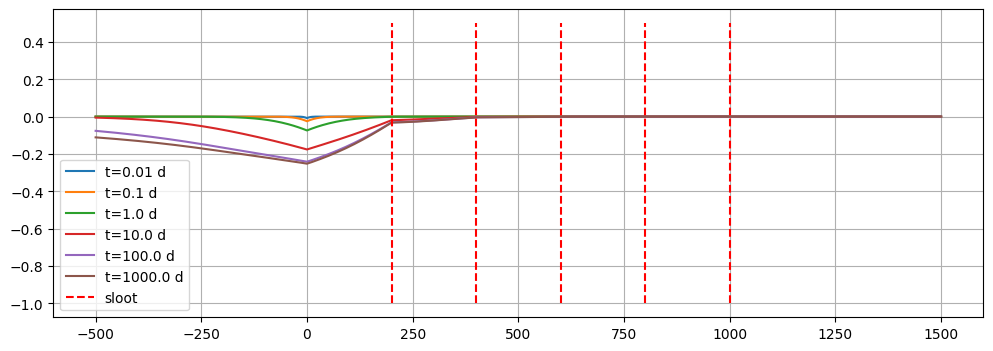

In [37]:
times = np.array([0.01, 0.1, 1., 10., 100., 1000.])

fig, ax = plt.subplots(figsize=(12, 4))
ax.grid()

# Kies punten langs de hoirzontale lijn
xL = np.linspace(-500, 1500, 501)

# Bijbehorende y-coordinaten
yL = np.zeros_like(x)

# Bereken de stijghoogte langs de lijn voor alle punten en tijden
h = ml.headalongline(xL, yL, times, layers=0)

labels = [f't={t} d' for t in times]
ax.plot(xL, h[0].T, label=labels)

ax.vlines(xsl, -1., 0.5, colors='r', linestyles='--', label='sloot')

ax.legend()

plt.show()

#### De resultaten in contourplot

Het berekenen van de punten voor de contourplot kost veel tijd. In dit geval ca. 1m13.5 s. Dus vergt wat geduld.

De weerstand van de sloten neemt van west naar oost af om het overgangsgebied tussen het hoge gebied links en het lage gebied rechts te modelleren.

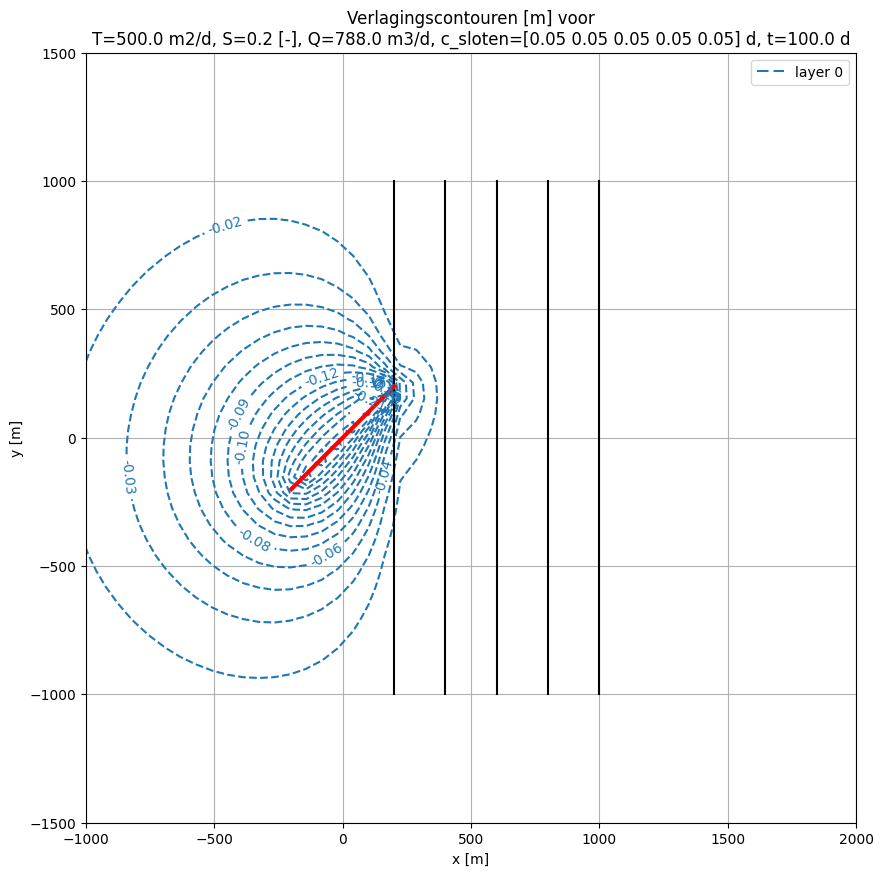

In [38]:
# Window voor contour plot
win = (-1000, 2000, -1500, 1500)


# Contouring, layout=True impliceert dat de elementen ook worden getekend.
t = 100.
ml.contour(win=win, ngr=50, t=100, layers=0, levels=20, layout=True, decimals=2, color=None, newfig=True, legend=True, figsize=(10, 10))

ax = plt.gca()
ax.set_title(f"Verlagingscontouren [m] voor\nT={T} m2/d, S={S} [-], Q={Q} m3/d, c_sloten={csl} d, t={t} d")
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid()
ax.plot(XL, YL, 'r', lw=3, label='lsink')


#### Idem maar nu verpakt in een aantal functies, waarmee gemakkelijker scenarios zijn door te rekenen

In [39]:
def add_dtiches(ml, x1=200., L=200., n=5., csl=None, w=1):
    """Return ditches as a dict.
    
    The diches are transformed into `ttim.HeadLineSinkString` and added tot the model
    
    Parameters
    ----------
    ml:
        ttim model
    x1: float
        x of left most ditch
    L: floatP
        distance between ditches
    n: int
        number of ditches
    csl: float or list
        drainage resistance at each of the ditches
    w: float
        ditch width
        
    """
    xsl = np.arange(x1, x1 + n * L, L)
    
    if np.isscalar(csl):
        csl = csl * np.ones_like(xsl)
    
    assert csl is not None, f"cdr must be list of drainage resistances of len(xsl) = {len(xsl)}"
    assert len(csl) == len(xsl), f"cdr must be a list of len(xsl) = {len(xsl)}"
    
    y = np.linspace(-1000, 1000, 21) # ycoordinaten van de slootstukken die samen een waterloop vormen

    # Define the ditches / canals
    ditches = {}
    for i, (x, c) in enumerate(zip(xsl, csl)):
        name = f'ditch{i}'
        xy = np.vstack((x * np.ones_like(y), y)).T
        ditches[name] = {
            'name': name,
            'xy': xy,
            'res': csl,
            'wh': w,
            # Define ttim.HeadLineSinkString and add to model
            'dtich': ttim.HeadLineSinkString(ml,
                xy=xy,
                tsandh=(0, 0),
                res=c,
                wh=w,
                layers=0,
                label=name)
        }
    return ditches


def add_lsinkditch(ml, XL=[-100., 100.], YL=[-100., 100.], Q=788, csl=0, w=1):
    """Return linesink as dict.
    
    Parameters
    ----------
    XL: list or np.array
        x-coordinafes of exracting canal (LineSinkDitchString element)
    YL: list of floats or np.array
        y-coordinates of the same
    Q: float
        total extraction from t=0
    c: float
        bottom resistance of ditches
    w: float
        bottom width
    """
    name = 'lsink'
    xy = np.vstack((XL, YL)).T
    lsink = {'name': name,
             'XL': XL,
             'YL': YL,
             'Q': Q,
             'res': csl,
             'wh': w,
             'lsink': ttim.LineSinkDitchString(ml,
                    xy=xy, tsandQ=[(0, Q)], res=c, wh=w, layers=0, label=name)
    }
    return lsink

 
def plot_contours(ml, win=(-1000, 2000, -1500, 1500), t=100, lsink=None):
    """Return contour plot with default number of levels of layer 0, with layout.
    
    Parameters
    ----------
    ml: ttim model object
        the model
    win: tuple of 4 floats
        x1, x2, y1, y2 of computation window
    t: float
        time of the contours plotted
    lsink: dict
        dictionary with the ditch properties for plotting in different color and linewidth    
    """ 

    ml.contour(win=win, ngr=50, t=t, layers=0, levels=20,
               layout=True, decimals=2, color=None, newfig=True,
               legend=True, figsize=(10, 10))
    return plt.gca()


### Het actuele drainage-scenario en de verlagingscontouren

In [1]:
# Aquifer parameters
T, S, t, Q = 500., 0.2, np.logspace(-5., 0., 100), 788.
rw = 0.2
L, w = 200., 1.0

# Drainageweerstand ter plaatse van de 5 sloten
cdr_area = np.logspace(3, 1, 5) # drainageweerstand verloopt hoge naar lage waarde in 5 stappen

cdrs = {'overgangsgebied': {'cdr': cdr_area, 'area_type': 'overgangsgebied drainageweerstand verloopt WO van 1000 naar 10 d'},
        'hoog':      {'cdr': 1000. * np.ones_like(cdr_area), 'area_type': 'gebied met hoge drainageweerstand (1000 d)'},
        'laag':      {'cdr':  100. * np.ones_like(cdr_area), 'area_type': 'gebied met lage drainageweerstand (100 d)'},
        'zeer laag': {'cdr':   10. * np.ones_like(cdr_area), 'area_type': 'gebied met extreem lage drainageweersand (10 d)'},
}

for k, cdr in cdrs.items():
    # Instantiatie van het ttim model
    print(f"Gebieds type: {cdr['area_type']}.")
    ml = ttim.ModelMaq(kaq=T / 20., z=[0, -20], Saq= S / 20., tmin=0.001, tmax=1000)

    csl = np.round(cdr['cdr'] * w / L, 2)

    # Ditches simulating areal drainage resistance
    ditches = add_dtiches(ml, x1=200., L=L, n=5., csl=csl, w=w)

    # Extracting canal coordinates
    XL = np.linspace(-200, 200, 9)
    YL = np.linspace(-200, 200, 9)
    lsink = add_lsinkditch(ml, XL=XL, YL=YL, Q=Q)

    # Contour time
    t = 100.

    ml.solve()

    print("Computing the points for contouring takes a lot of time (order 1m30s), so please be patient!")
    computation_window = (-1000, 1000, -1000, 1000)
    ax = plot_contours(ml, win=computation_window, t=t, lsink=lsink)

    # Extras for the plot
    ax.set_title(f"Verlagingscontouren [m] voor {cdr['area_type']}\n" +
                 f"T={T:.0f} m2/d, S={S} [-], Q={Q:.0f} m3/d" +
                f" c_sloten=[{', '.join([f'{c:.3g}' for c in csl])}] d, t={t:.0f} d")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid()
    ax.plot(lsink['XL'], lsink['YL'], 'r', lw=3, label=lsink['name'])
    ax.set_xlim(-1000., 1500.)
    ax.set_ylim(-1500., 1500.)
    ax.set_aspect(1.0)
    ax.legend()
    plt.show()


NameError: name 'np' is not defined

# Verdere punten / aspecten

## Worst case = "Je mag het niet missen, wanneer de voorgenomen ingreep serieuze gevolgen heeft"

### Hoe vullen we dat in? Nog uit te werken. Mogelijk niet eenduidig.

1. Rekenen tot wanneer de verlaging statoinair is geworden.
2. De nazakking niet vergeten.
3. Het "intrekgebied" volgens de formule van Verruijt is niet het gebied waarin het grondwater wordt verlaagd. Die wordt bepaald tot de afstand waarop de verlaging nul is, een vaste rand. De verlaging wordt gegeven door Dupuit en niet door Verruijt, tenzij de voeding bij Verruijt het gevolg is van afgenomen drainage door droogvallende sloten.
4. De juiste aanpak in een gebied met gebiedswijze drainage door sloten is die volgens Blom. Hierbij worden de sloten in een gebied rond de put geheel droog getrokken en komt de drainage door die sloten te vervallen en ten goede aan de onttrekking. De rand van dit gebied is die waarbij de verlaging gelijk is aan de drainageweerstand maal het gedraineerde neerslagoverschot. Daarbuiten fungeren de nog niet geheel drooggevallen sloten als voeding die zich gedraagt als voeding vanuit een bovengelegen laag met vast peil en een drainageweerstand.
5. De formules van Verruijt en Blom zijn zowel ééndimensionaal als axiaal-symmetrisch toe te passen.

## Grondwaterbalans. Hoe hiermee omgaan in de passende beoordeling?

Dit gaat onder andere om indirect, via het grondwater, onttrekken aan beken met beperkte afvoer, die in de zomer kwetsbaar zijn. Dit speelt in het algemeen op hogere gronden waar geen externe aanvoer naar het oppervlaktewater kan plaats vinden, dus waarin al het oppervlaktewater afkomstig is van toestromend grondwater.

De onttrekking eigent zich water toe dat anders een andere bestemming zou vinden, zoals voeding van beken en of van de vegetatie. Er zijn derhavle atijd gevolgen van een onttrekking voor de waterbalans van het gebied waarop de ontrekking invloed uitoefent. Men kan berekenen hoeveel indirect via het grondwater aan een naburige beek wordt onttrokken, repectievelijk aan voeding wordt ontnomen. Met name kleinere beken zijn gevoelig voor aanpalende grondwateronttrekkingen. Regionaal kan het cumlatieve effect grote negatieve gevolgen hebben voor de beekafvoer en daarmee voor de ecologie en andere gebruiksdoelen. In de literatuur zijn vele voorbeelden te vinden waarin beken en hele rivieren droog zijn gevallen door onttrekking van grondwater.

## GxG kaart. Welke rol kan die spelen bij de passende beoordeling?

Kan hiermee Vlaanderen worden verdeeld in grondwatergebiedstypen: Infiltratiegebied, intermediar en kwelgebied? Zulke kaareten geven aan wat er als natuurlijke variatie in de grondwaterstand beschouwd kan worden.

Er kan voor de beoordeling van vergunningaanvragen rekening worden gehouden met het type grondwatersysteem: infiltratiegebied (hoog gelegen met diepe grondwaterstand, weinig of geen drainagemiddelen of natuurlijke afvoer) en een kwelgebied (relatief laag gelegen ten opzichte van de omgeving, met hoge grondwaterstanden en veel drainagemiddelen), danwel een overgangsgebied tussen deze twee uitersten in. Naar verwachting zullen toekomstige GxG kaarten deze gebiedsindeling weerspiegelen. De gevolgen van een onttrekking in de verschillende zones zullen ook verschillen. Zo zal een onttrekking in een infiltratiegebied ogenschijnlijk nabij nauwelijks invloed hebben maar zal de invloed verderop manifesteren in het droogvallen van koppen van beken, en van sloten in het overgangsgebied. Deze kunnen daar heel gevoelig voor zijn, terwijl het een op een aantonen van deze effecten aan de hand van metingen wordt bemoeilijkt door de grote natuurlije variatie van de afvoer van de beekkoppen en de van nature variënde slootpeilen in de overganszone. De reikwijdte van de invloed van de onttrekking in een infiltratiegebied is in het algemeen groot doordat de randen die de invloed dempen ver weg liggen.

De situatie bij een onttrekking in een kwelgebied met veel oppervlaktewater, dat stevig gevoed wordt door kwel uit de verre omgeving en (dus uit een groot gebied) is omgekeerd. De reikwijdte is door het vele dempende oppervlaktewater in de naaste omgeving beperkt, zowel wat de verlaging betreft als wat betreft de invloed op het oppervlaktewater.

De situatie in de overgangszone ligt hier tussenin. Beken en sloten tegen het hogere gebied aan zijn zeer gevoelig voor de onttrekking, voor die in de richting het kwelgebied is dit juist minder het geval. De invloed van de onttrekking en zijn reikwijdte is daarom asymmetrisch, hij is groter richting het infiltratiegebied en kleiner richting het kwelgebied.

Deze nuances zijn analytisch moeilijk te benaderen. Een model heeft hier echter geen moeite mee.
Analytisch zou men de invloedsradius kunnen kiezen afhankelijk van het gebiedstype, af te leide uit de GxG kaarten. Een methode hiervoor zou moeten worden uitgewerkt en getoetst aan een aantal representatieve situaties.

## Ruimtelijk modelleren van verlagingen met de drainageweerstand (experimenteel, het is de vraag of dit werkt)

Een oppervlaktewatrstelsel in een gebied kan op regionale schaal mathematisch of modeltechnisch in de berekeningen of in de modellering worden verdiscondeerd door deze ruimtelijk om te zetten in een drainageweerstand. De drainageweerstand is, per definitie, de gemiddelde grondwaterstand minus het oppervlaktewaterpeil, gedeeld door het gemiddelde neerslagoverschot. Immers $\frac{h_{gw}-h_{ow}}{c}=N$, dus [m/d]=[m/d]. In feite is deze defitie van de drainageweerstand een regionale meting ervan, en hij kan dus worden opgevat als een eigenschap van het concrete, zelfs fysische systeem van grond- en oppervlaktewater op sub-regionale schaal, waarin het oppervlaktewater met zijn individuele sloten tot de regionale drainageweerstand zijn opgeschaald en dus uit de vergelijking zijn geëlimineerd.

De drainageweerstand kan ruimtelijk worden vastgesteld, bijvoorbeeld door een grondwatermodel door te rekenen zonder neerslagoverschot en daarna nog een keer, maar dan met het gemiddelde neerslagoverschot, en dit verschil te delen door het neerslagoverschot. Dit is dus een exercitie die direct met elk grondwatermodel kan worden uitgevoerd.

De volgende stap is dan om in hetzelfde of in een ander model al het oppervlaktewater te vervangen door deze drainageweerstand. Met dit model kan dan heel eenvoudig het effect worden berekend van ingrepen zoals onttrekkingen, bemalingen en aanpassingen van oppervlaktwaterpeilen. Het effect van zulke aanpassingen van het oppervlaktewaterpeil kan worden berekend door uitsluitend de in peil te vanderen oppervlaktewateren in te voeren, samen met hun peilverandering.

Voor deze wijze van modellering zijn de absolute peilen niet van belang. Zelfs voor de berekening van de drainageweerstand is het niet nodig om de absolute hoogte van het oppervlaktewater te kennen. Immers het effect van het veranderen van de grootte van het neerslagoverschot op de grondwatersanden is een zuivere superpositie, waarvan het resultaat geheel onafhankelijk is van de (stationaire) beginsituatie. Het enige gege ens die we voor een dergelijke analyse nodig hebben zijn de lagen van het model met zijn bodemconstanten en, aan de top, de ruimtelijk variërende drainageweeerstand.

Om de drainageweerstand te kunnen bepalen is het zaaks de gemiddelde grondwaterstand ten opzichte van het lokale opervlaktewater te kennen. Het peil in het oppervlaktewater, lokaal of niet, kan daarbij op nul worden gezet. Het berekende ruimtelijke grondwaterstandsverloop varieert, zodat een slag moet worden gemaakt naar het gemiddelde verloop dat een goede maat oplevert voor de drainageweeerstand. Een mogelijkheid is om afzonderijke gebieden in het model met oppervlakgewater te selecteren waarin de grondwaterstand een opbolling vertoont als gevolg van de opgelegde voeding. Met GIS kan voor ek van deze deelgebieden de gemiddelde grondwaterstand worden berekend. Dit is dan de maat voor de drainageweerstnad binnen elk van de afzonderlijke gebieden met opbolling.

Het vinden van een gebied met opbolling is een GIS-exercitie. Voor de uitvoering zijn nog wel een paar hobbels te nemen. Als het regionale gebied is op te delen in gebieden met zuivere opbolling, dat wil zeggen, dat de tweede afgeleide van de grodnwaterstand in alle richtingen positief is, is er weinig tegen deze analyze in te brengen. Dat is echter anders in overgangsgebieden, dit zijn gebieden die van een hoog gebied zonder oppervlaktewater overgaan in een laag gebied met veel oppervlaktewater. In het overgangsgebied prikken beken vanuit het lage gebied stroomopwaarts het hoge gebied in. In deze overgang zijn de gebiedsdelen met meer beken open in de richting  van het hoge gebied en gaat de kromming van de stijghoogte van het lagere gebied naadloos over in die van het hogere gebied. De vraag is dus hoe we in deze open overgangsgebieden op een zonvolle manier een drainageweerstand kunnen definiëren, oftewel een zinvol gemiddelde van de opbolling kunnen bepalen, zo mogeijk door middel van een standaard GIS-bewerking. Vermoedelijk ligt de sleutel in het vinden van zadelpunten in het grondwateroppervlak, want hierin gaat de tweede afgeleide van het grondwateroppervlak in bepaalde richtingen door nul. Een eigenschap van een opbollingsvlak is dat de tweede afgeleide van het opbollingsvlak groter of gelijk aan nul is in alle richtingen. Waar dat niet het geval is, hebben we te maken met een overgang in de drainageweeerstand.

Het verhaal in de vorige paragraaf is voor de praktijk veel te ingewikkeld. Maar omdat de tweede afgeleide van het grondwatervlak nooit voldoende nauwkeurig kan worden bepaald, kan zo'n aanpak ook niet leiden tot een zinvol en stabiel resultaat. Vandaar dat hierna een andere benadering wordt voorgesteld. Die echter nog niet is uitgetest en dus zuiver experimenteel is.

### Voorstel werken met drainageweerstand (experimenteel)

De voeding van een gebied kan afgeleid worden uit de bolling (tweede afgeleide naar $x$ en $y$) van het grondwatervlak, immers
$$\frac N {kD} = \frac{\partial^2 h}{\partial x^2} + \frac{\partial^2 h}{\partial y^2} =\nabla^2 h$$

Voldoet de grondwaterstand aan deze partiële differentiaalvergelijking, dan is de voeding overal gelijk, met de waarde $N$. Als we nu een model zoeken waarbij de lek bij opgelegde werkelijke grodnwaterstand overal gelijk aan $N$ is. Alleen eisen we dit nu niet door voeding van het watervoerende pakket vanuit de lucht, maar als gevolg van de opgelegde gemiddelde grondwaterstanden die via een weerstandbiedende deklaag met (drainage)weerstand $c_{dr}$, in verbinding staat met het slootpeil"

$$ \frac {h - h_0} {c_{dr}} = N $$

Met $h_0$ de grondwaterstand zonder voeding. Vanwege de geldigheid van het superpositiebeginsel, mag $h_0$ gelijk aan nul worden genomen.

De ruimtelijk variabele drainageweerstnad is per definitie gelijk aan

$$ c_{dr}(x, y) = \frac {h - h_0} N$$

De drainageweerstand kan zo worden verkregen als zijnde $h - h_0$ uit ons testmodel bij constante voeding gelijk aan $N = 1$ m/d.

Met deze weerstand kunnen we vervolgens de effecten van ingrepen berekenen, waarmee dan automatisch de invloed van het oppervlaktewater is meegenomen.

### Voorbeeld

In het navolgende voorbeeld beschouwen we een gebied met een gemiddelde, ruimtelijk uniform neerslagoverschot en oppervlaktewater. De grondwaterstand is overal met en model uitgerekend.

Hieruit bepalen we de drainageweerstand, $c_{dr} = \frac {h - h_0} N$$

Om te laten zien dat het niet uitmaakt wat de waterstanden in het oppervlaktewater zijn, doen we hetzelfde met alle waterstanden op nul gezet.

Dan draaien we een ander model, dat hetzelfde is als het voorgaande, maar dat in plaats van oppervlatewater bevat een weerstandbiedende laag aan de top bevat met de drainageweerstand. De stijghoogte (vervangend oppervlaktewaterpeil) boven de afdekkende laag is overal nul, het neerslagoverschot is ook nul, maar met de hierboven de berekende gemiddelde grondwatestand overal opgelegd, is de stroming nu gelijk aan die in het eerste model en door de draiageweerstand is de voeding nu overal gelijk aan N, en dus is de berekende grondwaterstand nu ook overal gelijk aan de in het vorige model beekende grondwaterstand. In dit alternatieve model kunnen vervolgens maatregelen worden opgelegd en het effect daarvan berekend. Dat kan gewoon met all oppervlaktewaterpeilen gelijk aan nul. Het resultaat is een verlagingenbeeld dat exact overeenstemt met de drainageweerstand en goed met de verlagingen die we zouden verkrijgen met het model waarin het oppervlakterwater exact was gemodelleerd.

Deze test moet worden uitgevoerd met een numeriek model zoals Modflow, aangezien TTIM geen ruimtelijk variabele drainageweerstand kan moddelleren.

Het bijzondere is dat voor deze exercitie geen GIS nodig is. Bovendien kan deze alternatieve modellering met drainageweerstand met een zeer eenvoudig model  worden uitgevoerd, zonder oppervlaktewater; immers het effect daarvan is verwerkt in de drainageweerstand die ruimtelijk varieert.

Dit is nog uit te proberen.